# Figure 4:  RNA and ATAC, P9855

Here we study the chromatin accessibility (ATAC peak heights), gene expression (mRNA counts), and a bit of protein abundance for experiment P9855.

In [1]:
#Import packages.  Put plots "inline" in the notebook.  

import numpy as np  # For numerical computations.
import pandas as pd  # Pandas for data analysis.
import matplotlib.pyplot as plt  # For basic plotting.
plt.rcParams['svg.fonttype'] = 'none' # Export fonts as text, not as curves.
import seaborn as sns # For pretty visualization in Seaborn.  See https://seaborn.pydata.org/
from matplotlib.patches import Rectangle
from matplotlib import colors
from matplotlib.ticker import ScalarFormatter
from matplotlib import cm
from matplotlib_venn import venn3, venn3_circles 

import re #regex


import statsmodels.api as sm
from scipy.stats import expon
import scipy.stats as ss
from scipy.spatial import distance_matrix
from scipy.spatial.distance import squareform, pdist
from scipy.cluster.hierarchy import linkage, ward, fcluster
from scipy.stats import zscore
import statsmodels.formula.api as smf # For quantile regression, etc.

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV, LassoLarsCV, LassoLarsIC
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
# UMAPs are all the rage... no more tSNE. Sad :(
import umap

from IPython.display import display # Pretty display of data frames.

%matplotlib inline

# Loading data

## Loading gene metadata

We first load gene metadata, which contains information about a whole lot of genes (including "pseudogenes", etc.).

In [2]:
gene_metadata = pd.read_csv('P9855_All_Gene_Info_Metadata.csv', sep=',',
                       index_col=0, header=0, low_memory=False)
print('{} genes loaded.'.format(len(gene_metadata)))
gene_metadata.head()

196248 genes loaded.


hgnc_symbol chromosome_name  start_position  end_position  \
ensembl_gene_id                                                             
ENSG00000261657    SLC25A26     HG991_PATCH        66119285      66465398   
ENSG00000261657    SLC25A26     HG991_PATCH        66119285      66465398   
ENSG00000261657    SLC25A26     HG991_PATCH        66119285      66465398   
ENSG00000223116         NaN              13        23551994      23552136   
ENSG00000233440     HMGA1P6              13        23708313      23708703   

                 transcription_start_site    gene_biotype  
ensembl_gene_id                                            
ENSG00000261657                  66119285  protein_coding  
ENSG00000261657                  66320895  protein_coding  
ENSG00000261657                  66339287  protein_coding  
ENSG00000223116                  23552136           miRNA  
ENSG00000233440                  23708313      pseudogene

For human-readable names, we make a new dataframe of hgnc-symbols only.

In [3]:
gene_names = gene_metadata['hgnc_symbol'].groupby('ensembl_gene_id').first().astype(str)
gene_names = gene_names.replace('nan', 'None')
gene_names

ensembl_gene_id
ENSG00000000003      TSPAN6
ENSG00000000005        TNMD
ENSG00000000419        DPM1
ENSG00000000457       SCYL3
ENSG00000000460    C1orf112
                     ...   
ENSG00000273489        None
ENSG00000273490      TSEN34
ENSG00000273491        None
ENSG00000273492        None
ENSG00000273493        None
Name: hgnc_symbol, Length: 63677, dtype: object

For exploration, it will be useful to look up the ENSG id for a given HGNC symbol.  The following function handles this carefully -- throwing an exception if an HGNC symbol is not found, or if multiple ENSG ids exist with the same HGNC symbol.  

In [4]:
def get_ensg(genename, multiple='throw'):
    if genename[:5] == 'ENSG0':
        return genename
    gn = gene_names[gene_names == genename]
    if len(gn) == 0:
        raise KeyError('The HGNC symbol {} does not occur'.format(genename))
    elif len(gn) > 1:
        if multiple == 'throw':
            raise ValueError('The HGNC symbol {} has multiple ENSG gene ids. \n'
                             'Set multiple = "first" to take the first. \n'
                             'Set multiple = "all" to get a list of all.'.format(genename))
        if multiple == 'first':
            return gn.index[0]
        if multiple == 'all':
            return list(gn.index)
    elif len(gn) == 1:
        return gn.index[0]

In [5]:
get_ensg('TSPAN6')

'ENSG00000000003'

We create a dataframe just for the location information.  We add directionality, based on whether the TSS is located at the start or end.  The directionality will be +1 if the gene is read from start to end, and -1 if the gene is read from end to start.  This will be used later, as we look at peaks that are 50000kb "upstream" of the gene, relative to this direction.

In [6]:
gene_locs = pd.DataFrame(index=gene_metadata.index)
gene_locs['TSS'] = gene_metadata['transcription_start_site']
gene_locs['start'] = gene_metadata['start_position']
gene_locs['end'] = gene_metadata['end_position']
gene_locs['chr'] = gene_metadata['chromosome_name']
gene_locs['dir'] = 1 - 2*((gene_locs['end'] - gene_locs['TSS']) < (gene_locs['TSS'] - gene_locs['start']))
gene_locs['geneid'] = list(gene_locs.index)
gene_locs = gene_locs.loc[~ gene_locs.geneid.duplicated(keep='first')]
gene_locs = gene_locs.drop('geneid', axis=1)
gene_locs.head()

TSS     start       end          chr  dir
ensembl_gene_id                                                
ENSG00000261657  66119285  66119285  66465398  HG991_PATCH    1
ENSG00000223116  23552136  23551994  23552136           13   -1
ENSG00000233440  23708313  23708313  23708703           13    1
ENSG00000207157  23726825  23726725  23726825           13   -1
ENSG00000229483  23744736  23743974  23744736           13   -1

In [7]:
genes = list(gene_locs.index)
print('{} distinct Ensembl Gene IDs found with location data.'.format(len(genes)))
print('{} unique names associated to Ensembl Gene IDs.'. format(len(gene_names.unique())))

63677 distinct Ensembl Gene IDs found with location data.
33618 unique names associated to Ensembl Gene IDs.


## Loading sample metadata from P9855

We load metadata for the samples from P9855.

In [8]:
meta_df = pd.read_csv('P9855_ATAC_RNA_Worksheet_April4_2018n2-1.csv', index_col=0)
meta_df['Clone ID'] = meta_df['Clone ID'].replace(np.nan, 'None') # Keep everything a string
meta_df['Clone_ID'] = meta_df['Clone ID'].apply(lambda x : x[:6]) # Formatting.
print('Metadata loaded on {} samples from P9855'.format(len(meta_df)))
meta_df.head()

Metadata loaded on 114 samples from P9855


Donor Condition HLA Type  Batch Clone ID  Cell Number  \
Sample ID                                                          
P9855_2001     F   InVitro       A2    1.0   P1_A03         25.0   
P9855_2002     F   InVitro       A2    1.0   P1_A03         25.0   
P9855_2003     F   InVitro       A2    1.0   P1_A03         25.0   
P9855_2004     F   InVitro       A2    1.0   P1_A05         25.0   
P9855_2005     F   InVitro       A2    1.0   P1_A05         25.0   

           In_Vivo_Clone_Number Clone_ID_InVitro founder_pheno protein_pheno  \
Sample ID                                                                      
P9855_2001                  NaN         P9855_01           EFF          fEFF   
P9855_2002                  NaN         P9855_01           EFF          fEFF   
P9855_2003                  NaN         P9855_01           EFF          fEFF   
P9855_2004                  NaN         P9855_02           INT          fUND   
P9855_2005                  NaN         P9855_02           INT          fUND   

            ...                                  Nuc_Seq_TRA_2 Read_Count.1  \
Sample ID   ...                                                               
P9855_2001  ...  TGTGCAGCCTTACTTCCAGTATACAACTTCAACAAATTTTACTTT        219.0   
P9855_2002  ...  TGTGCAGCCTTACTTCCAGTATACAACTTCAACAAATTTTACTTT        289.0   
P9855_2003  ...  TGTGCAGCCTTACTTCCAGTATACAACTTCAACAAATTTTACTTT        262.0   
P9855_2004  ...     TGTGCCGTGAATGGCTCTAGCAACACAGGCAAACTAATCTTT        135.0   
P9855_2005  ...     TGTGCCGTGAATGGCTCTAGCAACACAGGCAAACTAATCTTT        215.0   

           notes  Vb2  D.1  Jb2  TRB sequence count Clone_ID  
Sample ID                                                     
P9855_2001   NaN  NaN  NaN  NaN  NaN      NaN   NaN   P1_A03  
P9855_2002   NaN  NaN  NaN  NaN  NaN      NaN   NaN   P1_A03  
P9855_2003   NaN  NaN  NaN  NaN  NaN      NaN   NaN   P1_A03  
P9855_2004   NaN  NaN  NaN  NaN  NaN      NaN   NaN   P1_A05  
P9855_2005   NaN  NaN  NaN  NaN  NaN      NaN   NaN   P1_A05  

[5 rows x 34 columns]

In [9]:
P_clones = meta_df['Clone_ID'].unique()
print('{} clones are found in metadata:  {}'.format(len(P_clones), ', '.join(sorted(P_clones))))

28 clones are found in metadata:  Negati, None, P1_A03, P1_A05, P1_A08, P1_A12, P1_B10, P1_C11, P1_D09, P1_D12, P1_E09, P1_F02, P1_F04, P1_F10, P1_H01, P1_H10, P2_A04, P2_A05, P2_B11, P2_C03, P2_C12, P2_D12, P2_F01, P2_G01, P2_G09, P2_H01, P2_H04, P2_H05


## Loading gene expression from P9855

We load the expression matrix for P9855.  This is already TPM-normalized, filtered, and pseudolog-base-two-transformed.

In [10]:
EM = pd.read_pickle('P9855_EM.pkl') # Load normalized expression matrix from a pickle.
EM.head()

ENSG00000000419  ENSG00000000457  ENSG00000000460  \
P9855_2001         5.902169         0.000000         1.687114   
P9855_2002         0.000000         3.414208         0.000000   
P9855_2003         0.000000         0.000000         0.000000   
P9855_2004         6.246859         0.000000         0.000000   
P9855_2005         3.838920         0.000000         0.000000   

            ENSG00000001036  ENSG00000001084  ENSG00000001167  \
P9855_2001              0.0         0.000000         0.000000   
P9855_2002              0.0         0.000000         0.000000   
P9855_2003              0.0         0.000000         1.697880   
P9855_2004              0.0         3.783313         4.122507   
P9855_2005              0.0         0.000000         1.635885   

            ENSG00000001461  ENSG00000001497  ENSG00000001561  \
P9855_2001         4.797762         0.000000         0.000000   
P9855_2002         5.841977         0.000000         2.923849   
P9855_2003         5.838456         5.962189         2.902996   
P9855_2004         5.381056         0.000000         0.859482   
P9855_2005         5.952619         6.349781         0.000000   

            ENSG00000001629  ...  ENSG00000273226  ENSG00000273247  \
P9855_2001         0.000000  ...              0.0         0.000000   
P9855_2002         4.918361  ...              0.0         0.000000   
P9855_2003         5.145945  ...              0.0         3.401322   
P9855_2004         0.000000  ...              0.0         4.057494   
P9855_2005         5.018675  ...              0.0         0.000000   

            ENSG00000273271  ENSG00000273319  ENSG00000273338  \
P9855_2001         0.000000         5.523487         0.000000   
P9855_2002         3.517961         1.057876         4.477923   
P9855_2003         0.000000         3.834225         4.645763   
P9855_2004         0.000000         6.211293         0.000000   
P9855_2005         0.000000         5.922380         2.484900   

            ENSG00000273344  ENSG00000273356  ENSG00000273437  \
P9855_2001         0.000000         0.000000         0.000000   
P9855_2002         4.068169         5.302015         0.000000   
P9855_2003         2.741976         0.000000         4.953616   
P9855_2004         0.000000         0.000000         5.370887   
P9855_2005         0.000000         0.000000         0.000000   

            ENSG00000273445  ENSG00000273451  
P9855_2001         6.079409         4.758256  
P9855_2002         0.000000         0.000000  
P9855_2003         0.000000         0.000000  
P9855_2004         0.000000         0.000000  
P9855_2005         0.000000         0.000000  

[5 rows x 9587 columns]

In [11]:
E_genes = list(EM.columns)  # The names of the genes. 
E_samples = list(EM.index) # The names of the cells.
E_clones = meta_df.loc[E_samples].Clone_ID.unique()
E_3clones = [clone for clone in E_clones if 
             len(meta_df.loc[E_samples][meta_df.loc[E_samples]['Clone_ID'] == clone]) == 3]

In [12]:
print("The expression matrix captures {} samples from {} clonotypes, with {} gene expressions.".format(
    len(E_samples), len(E_clones), len(E_genes)))
print("There are {} clones with 3 samples each, in the expression matrix.".format(len(E_3clones)))

The expression matrix captures 70 samples from 24 clonotypes, with 9587 gene expressions.
There are 23 clones with 3 samples each, in the expression matrix.


In [13]:
E_mystery_genes = [gene for gene in E_genes if gene not in genes]
print('There are {} genes in the expression matrix, not in metadata: {}'.format(
    len(E_mystery_genes), ', '.join(E_mystery_genes)))

There are 0 genes in the expression matrix, not in metadata: 


This is good!  All of the genes in the expression matrix are found in our gene metadata.

## Loading protein data from P9855

We don't do too much analysis of protein data, but use it in some plots of peak height, gene expression, and protein abundance.

In [14]:
protein_df = pd.read_csv('200912_P9855_exported_29clones_Marty.csv')
P_clonal = protein_df.groupby('Clone_Name_Well_ID').mean()
P_clonal = P_clonal[P_clonal.columns[:-2]]
P_clonal = P_clonal.loc[E_3clones]
print('Protein matrix loaded, with {} clones.'.format(len(P_clonal)))
P_clonal.head()

Protein matrix loaded, with 23 clones.


FSC-A         FSC-H         FSC-W         SSC-A  \
Clone_Name_Well_ID                                                            
P1_A03              105297.249119  81840.191630  84106.372320  66455.391336   
P1_A05              119205.181818  89000.275325  87451.644416  70717.985974   
P1_A12              110208.697516  84960.658385  84823.987578  61440.735404   
P1_D09              121466.137778  89857.488889  88182.142222  66510.288889   
P1_D12              113308.095111  86392.144444  85672.069778  66052.478889   

                           SSC-H         SSC-W    CD57 FITC  A2 YF DEXTRA APC  \
Clone_Name_Well_ID                                                              
P1_A03              48209.114537  90098.402570   902.903350      27506.250653   
P1_A05              49807.701299  92669.158442   803.705128      19328.956416   
P1_A12              44984.180124  89176.483230   413.486075      15468.637516   
P1_D09              46534.466667  93321.897778  1441.065429      17640.460889   
P1_D12              47191.466667  91478.108222  3041.200328      24489.894578   

                          CD8 A7  CD62L BV670    PD1 BV711  CD27 BV786  \
Clone_Name_Well_ID                                                       
P1_A03               8444.176079  -208.290944  1376.424971  -97.778107   
P1_A05               7142.439039   -32.177134   903.623431  -68.900252   
P1_A12               4991.385590   -77.271623   994.417168  -49.785648   
P1_D09               6325.950444   567.863060  2455.682089  -83.398870   
P1_D12              10836.830267  -172.790303  1240.419860 -131.373989   

                        CD94 PE      CD3 PC5  
Clone_Name_Well_ID                            
P1_A03              2359.556696  2292.757686  
P1_A05               393.199380  2615.705299  
P1_A12               279.779016  1625.113062  
P1_D09                60.759658  2319.213667  
P1_D12              3471.989671  2677.822433

# Quick figure, IL2RG

By popular demand, here's a little figure related to IL2RG:  population and clonal expression.

In [15]:
def log2p(x):
    '''
    We use a pseudo-log transform.
    log2p(x) = log_2(x+1).
    After this pseudo-log transform, a difference of 1 
    corresponds approximately to a 2-fold difference 
    (away from zero!)
    '''
    return np.log1p(x) / np.log(2) # For later use.

def exp2m(A):
    ''' 
    An inverse of the log2p function.
    '''
    return np.exp(A*np.log(2)) - 1 

In [16]:
IL2RG = exp2m(EM[get_ensg('IL2RG')]) # Undo the pseudo-log normalization just for now.

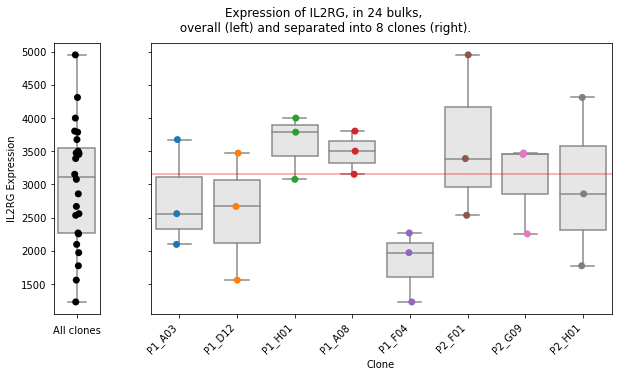

In [17]:
fig,ax = plt.subplots(1,2, sharey = True, figsize=(10,5), 
                      gridspec_kw = {'width_ratios':[1,10]})

allplot_df = pd.DataFrame(IL2RG)
allplot_df.columns=['IL2RG Expression']
allplot_df['Clone'] = meta_df.Clone_ID
allmean = allplot_df['IL2RG Expression'].median()

randclones = allplot_df['Clone'].value_counts()[:8].index
allplot_df = allplot_df[allplot_df['Clone'].isin(randclones)]

sns.boxplot(y='IL2RG Expression', color=(0.9,0.9,0.9,1), data = allplot_df, ax=ax[0], orient='v', whis=np.inf)
sns.stripplot(y='IL2RG Expression', color='black', data = allplot_df, 
              jitter=0.05, ax=ax[0], orient='v',s=7.0)

sns.boxplot(y='IL2RG Expression', x='Clone', color=(0.9,0.9,0.9,1), data = allplot_df, 
            ax=ax[1], orient='v', whis=np.inf)

sns.stripplot(y='IL2RG Expression', x='Clone', hue='Clone', data = allplot_df, 
              jitter=0.05, ax=ax[1], orient='v',s=7.0)

ax[0].set_xlabel('All clones')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation = 45, ha="right")
ax[1].axhline(allmean, color=(1,0,0,0.4))
ax[1].set_ylabel('')
ax[1].legend_.remove()

plt.suptitle('Expression of IL2RG, in {} bulks,'
             '\n overall (left) and separated into {} clones (right).'.format(len(allplot_df), len(allplot_df['Clone'].unique())))
plt.show()

## Loading ATAC peak data

Next, we load the data for each ATAC peak interval. For each interval, we have a score (related to peak height) for each 1000-ish cell bulk. We also have a series of transcription factors that could bind at that interval, as a series of booleans.  Oh, how I dread looking at transcription factors.

In [18]:
filename = 'peakMappingNormCounts_narrowPeaks_edJEM.csv' # Earlier version 'P9855_peakMappingNormCounts.csv'

interval_df = pd.read_csv(filename, sep=',',
                       index_col=0, header=0, low_memory=False)
interval_df.head()
intervals = list(interval_df.index)

We separate the interval data into metadata and peak height dataframes.

In [19]:
peak_meta = pd.DataFrame(index=interval_df.index)
peak_meta['chr'] = interval_df['Chr']
peak_meta['start'] = interval_df['Start']
peak_meta['end'] = interval_df['End']
peak_meta['mid'] = interval_df[['Start','End']].mean(axis=1)

# We create a column for interval type (IType) from the annotations.
annotations = interval_df['Annotation']
interval_types = annotations.apply(lambda A : A[:A.find('(') - 1])
peak_meta['itype'] = interval_types

# We create a column to extract the associated gene from the annotation.
def get_gene(ann):
    if 'ENSG' in ann:
        ensg_loc = ann.find('ENSG')
        return ann[ensg_loc:ensg_loc+15]
    else:
        return None
    
peak_meta['in_gene'] = interval_df['Annotation'].apply(get_gene)

peaks = list(peak_meta.index)
print('{} peak intervals found.'.format(len(intervals)))
print(interval_types.value_counts())

80599 peak intervals found.
intron          35400
Intergen        21591
promoter-TSS    15359
TTS              4367
exon             3882
Name: Annotation, dtype: int64


In [20]:
peak_meta.head()

chr      start        end          mid         itype  \
PeakID                                                                
Interval_77062   9  115079369  115080094  115079731.5        intron   
Interval_18293  12  117543772  117544007  117543889.5        intron   
Interval_51938   3  156852601  156852899  156852750.0      Intergen   
Interval_33832  19    1671931    1672563    1672247.0      Intergen   
Interval_13433  11   82996620   82997741   82997180.5  promoter-TSS   

                        in_gene  
PeakID                           
Interval_77062  ENSG00000119314  
Interval_18293  ENSG00000258285  
Interval_51938             None  
Interval_33832             None  
Interval_13433  ENSG00000137500

Now we extract the peak heights and put them in a data frame.  The first function finds the sample (P9855****) for each ATAC sample label (Clone*R*)

In [21]:
def find_sample(clone, s_df = meta_df):
    clonenum = clone[5:-3]
    if (len(clonenum) == 1) or (clonenum[0] == '5'):
        clonenum = '0' + clonenum
    cID = 'P9855_'+clonenum
    matches = s_df[s_df['Clone_ID_InVitro'] == cID]
    matches = matches[matches['Clone ID'].str.contains('ATAC')]
    repl = 'rep' + clone[-1]
    matches_R = matches[matches['Clone ID'].str.contains(repl)]
    if len(matches_R) == 1:
        matches = matches_R        
    if len(matches) != 1:
        print('No unique match found for {}'.format(clone))
        return None
    return matches.index[0]

In [23]:
ATAC_clones = [col for col in interval_df.columns if col[:5] == 'clone']
ATACR_clones = [clone for clone in ATAC_clones if 
                ( (clone[:-1]+'1' in ATAC_clones) and (clone[:-1]+'2' in ATAC_clones))]
parents = [clone[:-3] for clone in ATACR_clones if clone[-1] == '1']
print('{} clones found in ATAC data: {}'.format(len(ATAC_clones), ', '.join(ATAC_clones)))
print('')
print('{} clones have two replicates: {}'.format(len(parents), ', '.join(parents)))

29 clones found in ATAC data: clone1_R1, clone1_R2, clone10_R1, clone11_R1, clone13_R1, clone14_R1, clone15_R1, clone15_R2, clone16_R1, clone17_R1, clone18_R1, clone19_R1, clone2_R1, clone20_R1, clone21_R1, clone22_R1, clone22_R2, clone23_R1, clone23_R2, clone24_R1, clone3_R1, clone4_R1, clone5a_R1, clone5b_R1, clone7_R1, clone8_R1, clone8_R2, clone9_R1, clone9_R2

6 clones have two replicates: clone1, clone15, clone22, clone23, clone8, clone9


Note the clone names are different from the clone IDs in the sample metadata.  But they are convenient for later things.

In [24]:
ATAC_df = interval_df[ATAC_clones].copy()
ATACR_df = interval_df[ATACR_clones].copy()
ATAC_df.head()

clone1_R1   clone1_R2  clone10_R1  clone11_R1  clone13_R1  \
PeakID                                                                       
Interval_77062    8.216276   12.122195   17.707330   18.830673    5.776231   
Interval_18293    0.000000    1.212219    0.000000    8.070288    5.776231   
Interval_51938    9.129196   14.546634    8.853665    5.380192    6.931477   
Interval_33832    7.303357    7.879427    4.426832   13.450481    6.931477   
Interval_13433  289.395502  260.021076  258.969696  228.658173  256.464651   

                clone14_R1  clone15_R1  clone15_R2  clone16_R1  clone17_R1  \
PeakID                                                                       
Interval_77062    5.217534    9.334886   10.081574    8.457537   11.805156   
Interval_18293    1.739178    0.000000    0.000000    0.939726    0.000000   
Interval_51938    3.478356   13.643294   24.816182    0.000000    3.219588   
Interval_33832   10.435068   10.771022   10.857080   14.095894    6.439176   
Interval_13433  260.876702  294.407932  300.120701  258.424730  230.737136   

                ...  clone24_R1   clone3_R1   clone4_R1  clone5a_R1  \
PeakID          ...                                                   
Interval_77062  ...    8.610686    8.254851   10.759247   14.659954   
Interval_18293  ...    4.305343    4.127426    1.793208    0.771577   
Interval_51938  ...    6.458014   10.318564   30.484532   12.345224   
Interval_33832  ...    6.458014   10.318564    8.966039    6.172612   
Interval_13433  ...  301.374006  293.047225  242.083047  281.625427   

                clone5b_R1   clone7_R1   clone8_R1   clone8_R2   clone9_R1  \
PeakID                                                                       
Interval_77062   15.118595    7.577804    9.477101   14.875670   12.605361   
Interval_18293    0.000000    0.000000    0.592319    1.190054    1.939286   
Interval_51938   17.867431   15.844499    5.330869    5.950268   15.999112   
Interval_33832    8.246507    6.888912   10.069420   13.090589   15.029469   
Interval_13433  272.134718  274.867609  231.596660  265.976971  229.320605   

                 clone9_R2  
PeakID                      
Interval_77062    5.760340  
Interval_18293    3.291623  
Interval_51938   17.281019  
Interval_33832   12.755038  
Interval_13433  226.299053  

[5 rows x 29 columns]

Now we create a new version with sample numbers instead of labels like clone*R*.  That allows us to use the sample metadata when we compare ATAC peaks and gene expression.

In [25]:
ATACS_df = ATAC_df.copy()
ATACS_df.columns = [find_sample(col) for col in ATACS_df.columns]
ATACS_df.head()

P9855_2085  P9855_2093  P9855_2092  P9855_2097  P9855_2099  \
PeakID                                                                       
Interval_77062    8.216276   12.122195   17.707330   18.830673    5.776231   
Interval_18293    0.000000    1.212219    0.000000    8.070288    5.776231   
Interval_51938    9.129196   14.546634    8.853665    5.380192    6.931477   
Interval_33832    7.303357    7.879427    4.426832   13.450481    6.931477   
Interval_13433  289.395502  260.021076  258.969696  228.658173  256.464651   

                P9855_2100  P9855_2101  P9855_2102  P9855_2103  P9855_2106  \
PeakID                                                                       
Interval_77062    5.217534    9.334886   10.081574    8.457537   11.805156   
Interval_18293    1.739178    0.000000    0.000000    0.939726    0.000000   
Interval_51938    3.478356   13.643294   24.816182    0.000000    3.219588   
Interval_33832   10.435068   10.771022   10.857080   14.095894    6.439176   
Interval_13433  260.876702  294.407932  300.120701  258.424730  230.737136   

                ...  P9855_2113  P9855_2094  P9855_2087  P9855_2098  \
PeakID          ...                                                   
Interval_77062  ...    8.610686    8.254851   10.759247   14.659954   
Interval_18293  ...    4.305343    4.127426    1.793208    0.771577   
Interval_51938  ...    6.458014   10.318564   30.484532   12.345224   
Interval_33832  ...    6.458014   10.318564    8.966039    6.172612   
Interval_13433  ...  301.374006  293.047225  242.083047  281.625427   

                P9855_2095  P9855_2088  P9855_2089  P9855_2090  P9855_2091  \
PeakID                                                                       
Interval_77062   15.118595    7.577804    9.477101   14.875670   12.605361   
Interval_18293    0.000000    0.000000    0.592319    1.190054    1.939286   
Interval_51938   17.867431   15.844499    5.330869    5.950268   15.999112   
Interval_33832    8.246507    6.888912   10.069420   13.090589   15.029469   
Interval_13433  272.134718  274.867609  231.596660  265.976971  229.320605   

                P9855_2096  
PeakID                      
Interval_77062    5.760340  
Interval_18293    3.291623  
Interval_51938   17.281019  
Interval_33832   12.755038  
Interval_13433  226.299053  

[5 rows x 29 columns]

We also create a pseudolog-transformed peak-height dataframe.  We use log-base-2, so that a difference of 1 corresponds roughly to a 2-fold difference (in visualizations).

In [26]:
ATACS_logdf = log2p(ATACS_df) 
ATACS_logdf.head()

P9855_2085  P9855_2093  P9855_2092  P9855_2097  P9855_2099  \
PeakID                                                                       
Interval_77062    3.204184    3.713937    4.225532    4.309662    2.760483   
Interval_18293    0.000000    1.145495    0.000000    3.181148    2.760483   
Interval_51938    3.340448    3.958530    3.300660    2.673600    2.987590   
Interval_33832    3.053695    3.150467    2.440110    3.853046    2.987590   
Interval_13433    8.181875    8.028022    8.022200    7.843344    8.008231   

                P9855_2100  P9855_2101  P9855_2102  P9855_2103  P9855_2106  \
PeakID                                                                       
Interval_77062    2.636343    3.369451    3.470091    3.241464    3.678653   
Interval_18293    1.453743    0.000000    0.000000    0.955853    0.000000   
Interval_51938    2.162969    3.872168    4.690204    0.000000    2.077102   
Interval_33832    3.515393    3.557168    3.567677    3.916084    2.895143   
Interval_13433    8.032744    8.206565    8.234198    8.019172    7.856345   

                ...  P9855_2113  P9855_2094  P9855_2087  P9855_2098  \
PeakID          ...                                                   
Interval_77062  ...    3.264639    3.210210    3.555724    3.969008   
Interval_18293  ...    2.407446    2.358235    1.481923    0.825034   
Interval_51938  ...    2.898792    3.500619    4.976571    3.738252   
Interval_33832  ...    2.898792    3.500619    3.317020    2.842499   
Interval_13433  ...    8.240190    8.199904    7.925305    8.142747   

                P9855_2095  P9855_2088  P9855_2089  P9855_2090  P9855_2091  \
PeakID                                                                       
Interval_77062    4.010654    3.100608    3.389168    3.988746    3.766103   
Interval_18293    0.000000    0.000000    0.671129    1.130966    1.555466   
Interval_51938    4.237826    4.074206    2.662404    2.797069    4.087387   
Interval_33832    3.208908    2.979826    3.468508    3.816660    4.002655   
Interval_13433    8.093469    8.107832    7.861687    8.060571    7.847500   

                P9855_2096  
PeakID                      
Interval_77062    2.757096  
Interval_18293    2.101523  
Interval_51938    4.192275  
Interval_33832    3.781888  
Interval_13433    7.828448  

[5 rows x 29 columns]

## Figure panel:  Clustering based on ATAC peak heights

We try a few different kinds of clustering based on ATAC peak heights.  First, we set things up for figures of size/quality for publication.

In [27]:
def setfontsize():
    SMALL_SIZE = 5
    MEDIUM_SIZE = 6
    BIGGER_SIZE = 7

    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [159]:
def desetfontsize():
    SMALL_SIZE = 10
    MEDIUM_SIZE = 11
    BIGGER_SIZE = 12

    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [28]:
from matplotlib.image import imread
from tempfile import NamedTemporaryFile

def get_size(fig, dpi=300):
    with NamedTemporaryFile(suffix='.png') as f:
        fig.savefig(f.name, bbox_inches='tight', dpi=dpi)
        height, width, _channels = imread(f.name).shape
        return width / dpi, height / dpi

def set_size(fig, size, dpi=300, eps=1e-2, give_up=2, min_size_px=10):
    target_width, target_height = size
    set_width, set_height = target_width, target_height # reasonable starting point
    deltas = [] # how far we have
    while True:
        fig.set_size_inches([set_width, set_height])
        actual_width, actual_height = get_size(fig, dpi=dpi)
        set_width *= target_width / actual_width
        set_height *= target_height / actual_height
        deltas.append(abs(actual_width - target_width) + abs(actual_height - target_height))
        if deltas[-1] < eps:
            return True
        if len(deltas) > give_up and sorted(deltas[-give_up:]) == deltas[-give_up:]:
            return False
        if set_width * dpi < min_size_px or set_height * dpi < min_size_px:
            return False

Now we carry out UMAP clustering on the peak data.  In the UMAP clustering figure, I've chosen some parameters that make a good-looking plot, and are kind of middle-ground.  

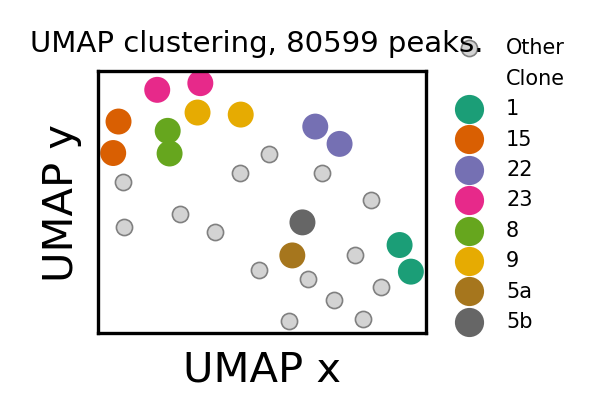

In [29]:
n_components = 20
n_neighbors = 10
min_dist = 0.25

fig, ax = plt.subplots(1,1,figsize=(2.0,1.4), dpi=300)
setfontsize()

X = ATAC_df.T
clr_list = ['1', '15', '22', '23', '8', '9', '5a', '5b']
def clone_rename(cl):
    cl_strip = cl.split('_')[0]
    if cl_strip[5:] in clr_list:
        return cl_strip[5:] #'Clone '+cl_strip[5:]
    else:
        return 'Other'
    
y = [clone_rename(cl) for cl in ATAC_df.columns]
hue_order = clr_list # ['Clone '+a for a in clr_list]

pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X) # Apply PCA with 10 components.
X_embedded = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, 
                           random_state = 42, metric='cosine').fit_transform(X_pca) # Reduce from 10 components to 2-dimensions.

cl_df = pd.DataFrame(X_embedded, columns = ['UMAP x', 'UMAP y'], index=X.index) # Just for graphing.
cl_df['Clone'] = y

sns.scatterplot(x='UMAP x', y='UMAP y', data = cl_df[cl_df['Clone'] == 'Other'], s=15, 
                color='lightgray', edgecolor='gray', linewidth=0.4, ax=ax, label='Other')

sns.scatterplot(x='UMAP x', y='UMAP y', hue='Clone', hue_order = hue_order, palette='Dark2',
                data = cl_df[cl_df['Clone'] != 'Other'], s=30, edgecolor=None, ax=ax)

ax.set_xticks([])
ax.set_yticks([])

plt.legend(loc='upper left', bbox_to_anchor=(1.01, 1.2), ncol=1, framealpha=0.0)

plt.suptitle("UMAP clustering, {} peaks.".format(len(X.T)), 
            y=1.0)

set_size(fig, (2.0, 1.4))
plt.savefig("Figure4_panels/UMAP.pdf", bbox_inches='tight')

plt.show()

To verify the robustness of the UMAP plot, especially the proximity of the sister clones, we try an array of *other* parameters, and plot the pairwise distances between clones.

In [34]:
n_comp_array = [5,10,20] # PCA components.  Can't be more than the number of samples!
n_neigh_array = [3,5,10]
min_dist_array = [0.1, 0.25, 0.5]

X = ATAC_df.T
clr_list = ['1', '15', '22', '23', '8', '9', '5a', '5b']
def clone_rename(cl):
    cl_strip = cl.split('_')[0]
    if cl_strip[5:] in clr_list:
        return 'Clone '+cl_strip[5:]
    else:
        return 'Other'
    
y = [clone_rename(cl) for cl in ATAC_df.columns]
hue_order = ['Clone '+a for a in clr_list]

dist_df = pd.DataFrame(index=range(len(n_comp_array)*len(n_neigh_array)*len(min_dist_array)), 
                       columns=['n_components','n_neighbors','min_dist','rep_dist','sis_dist','nonrep_dist'])

j = 0
dm = {}
for n_components in n_comp_array:
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X) # Apply PCA with 10 components.
    for n_neighbors in n_neigh_array:
        for min_dist in min_dist_array:
            X_embedded = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, 
                                   random_state = 42, metric='cosine').fit_transform(X_pca) # Reduce from 10 components to 2-dimensions.

            cl_df = pd.DataFrame(X_embedded, columns = ['UMAP x', 'UMAP y'], index=X.index) # Just for graphing.
            #cl_df['Clone'] = y
            dm[j] = pd.DataFrame(distance_matrix(cl_df.values, cl_df.values), index=cl_df.index, columns=cl_df.index)
            rep_dist = np.array([dm[j].loc['clone'+num+'_R1', 'clone'+num+'_R2'] for num in ['1','15','22','23','8','9']])
            nonreps = [cl for cl in cl_df.index if cl.split('_')[0] not in 
                      ['clone'+num for num in clr_list]]
            dm_nonrep = dm[j].loc[nonreps][nonreps]
            nonrep_dist = dm_nonrep.values.flatten().mean()
            sis_dist = dm[j].loc['clone5a_R1','clone5b_R1']
            dist_df.loc[j] = {'n_components':n_components,
                             'n_neighbors':n_neighbors,
                             'min_dist':min_dist,
                             'rep_dist':rep_dist.mean() / nonrep_dist.mean(),
                             'sis_dist':sis_dist / nonrep_dist.mean(),
                             'nonrep_dist':nonrep_dist}
            j += 1
display(dist_df)
        

n_components n_neighbors min_dist   rep_dist   sis_dist nonrep_dist
0             5           3      0.1  0.0447763   0.091293     7.80898
1             5           3     0.25  0.0533232   0.111925     8.73861
2             5           3      0.5  0.0971278   0.166995     7.04662
3             5           5      0.1  0.0747414   0.070958     6.44006
4             5           5     0.25  0.0652092  0.0904141     7.96396
5             5           5      0.5   0.147182   0.220532     4.76262
6             5          10      0.1   0.223229    0.25372     1.81459
7             5          10     0.25   0.281978   0.289867     1.94994
8             5          10      0.5   0.287756   0.524055     2.35423
9            10           3      0.1  0.0887139    0.13891     3.49105
10           10           3     0.25   0.162269   0.219446     2.89243
11           10           3      0.5   0.270293   0.327331     2.73377
12           10           5      0.1   0.158461   0.169882     2.05484
13           10           5     0.25   0.222714   0.266646     2.05899
14           10           5      0.5   0.259524   0.307047     2.49772
15           10          10      0.1   0.244382    0.30198     1.73036
16           10          10     0.25   0.271067   0.313593     1.79233
17           10          10      0.5   0.305084   0.381358     2.26556
18           20           3      0.1   0.417248   0.052209     3.29143
19           20           3     0.25   0.242096   0.206418     2.43658
20           20           3      0.5   0.275667   0.210946     2.99054
21           20           5      0.1    0.18094    0.18515     1.94419
22           20           5     0.25   0.211387    0.26917     2.13276
23           20           5      0.5   0.304048   0.298598     2.23631
24           20          10      0.1   0.221462   0.326412     1.84335
25           20          10     0.25   0.287306    0.36364     1.89919
26           20          10      0.5   0.286923   0.369801     2.44944

In [58]:
print('The mean UMAP distance between replicate clones is '
      '{:0.1%} +/- {:0.1%} of the mean non-replicate distance.'.format(dist_df.rep_dist.mean(), dist_df.rep_dist.std()))

print('The mean UMAP distance between sister clones 5a/5b is '
      '{:0.1%} +/- {:0.1%} of the mean non-replicate distance.'.format(dist_df.sis_dist.mean(), dist_df.sis_dist.std()))

The mean UMAP distance between replicate clones is 21.1% +/- 9.4% of the mean non-replicate distance.
The mean UMAP distance between sister clones 5a/5b is 24.2% +/- 11.1% of the mean non-replicate distance.


The numbers (0--26) in the above table will be used to label the plot below.

In [35]:
def upper_values(sq_df):
    n = len(sq_df)
    if sq_df.shape != (n,n):
        print('Not square!')
        return None
    index_list = [[i,j] for i in range(n) for j in range(n) if j > i]
    return np.array([sq_df.values[il[0],il[1]] for il in index_list])

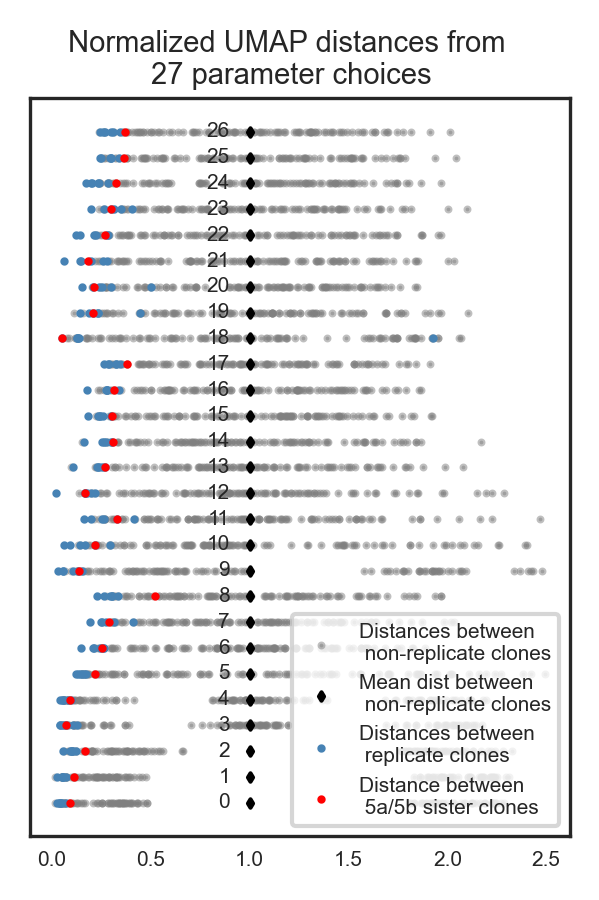

In [43]:
dist_df['Distance between replicates'] = dist_df['rep_dist'] / dist_df['nonrep_dist']
dist_df['Distance between 5a/5b'] = dist_df['sis_dist'] / dist_df['nonrep_dist']

fig,ax = plt.subplots(figsize=(2.0, 3.0), dpi=300)
sns.set_style('white')
setfontsize()

for j in dist_df.index:
    dd = dist_df.loc[j]
    
    # First, the nonreplicates.
    
    nonreps = [cl for cl in cl_df.index if cl.split('_')[0] not in 
                      ['clone'+num for num in clr_list]]
    dm_nonrep = dm[j].loc[nonreps][nonreps]
    nonrep_dist = upper_values(dm_nonrep) # All distances between distinct non-replicates
    nonrep_dist = nonrep_dist / nonrep_dist.mean()
    
    ax.scatter(nonrep_dist,[j]*len(nonrep_dist), s=0.8, color='gray', alpha=0.5, 
               label = 'Distances between \n non-replicate clones')
    
    ax.scatter(1.0, j, s=2, color='k', marker='d', label='Mean dist between \n non-replicate clones')
    
    # Then, the replicates.
    rep_dist = np.array([dm[j].loc['clone'+num+'_R1', 'clone'+num+'_R2'] 
                         for num in ['1','15','22','23','8','9']])
    rep_dist = rep_dist / dd.nonrep_dist
    ax.scatter(rep_dist,[j]*len(rep_dist), s=1, color='steelblue', 
              label = 'Distances between \n replicate clones')
    
    # Finally, the sisters 5a/5b.
    ax.scatter(dd.sis_dist,j, s=1, color='red', marker='o', 
              label = 'Distance between \n 5a/5b sister clones')
    
    if j == 0:
        ax.legend(loc = 'lower right')
        
    ax.text(0.9,j,str(j),ha='right',va='center')

ax.set_yticks([])
ax.tick_params(axis='x', which='major', pad=0)

plt.suptitle('Normalized UMAP distances from \n'
            '27 parameter choices', y=0.95)

set_size(fig, (2.0, 3.0))
plt.savefig("Figure4_panels/UMAP_dist.pdf", bbox_inches='tight')

plt.show()

We see that the distance between 5a/5b sister clones is consistently below the distances between other non-replicate clones.  In fact, it's very close to the distances between *replicate* clones (in blue, above), across most of the 27 parameter-choices.

Just for comparison, we produce a tSNE plot, and also plot the top two principal components.

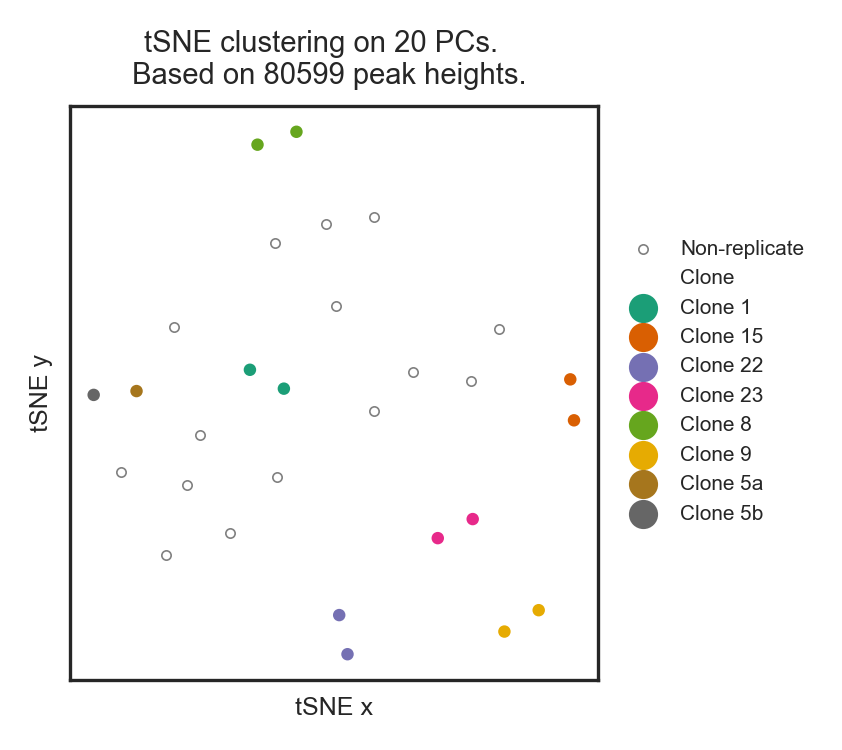

In [44]:
n_components = 20
perplexity=10
min_dist = 0.25

fig, ax = plt.subplots(1,1,figsize=(2.8,2.5), dpi=300)
setfontsize()

X = ATAC_df.T
clr_list = ['1', '15', '22', '23', '8', '9', '5a', '5b']
def clone_rename(cl):
    cl_strip = cl.split('_')[0]
    if cl_strip[5:] in clr_list:
        return 'Clone '+cl_strip[5:]
    else:
        return 'Other'
    
y = [clone_rename(cl) for cl in ATAC_df.columns]
hue_order = ['Clone '+a for a in clr_list]

pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X) # Apply PCA with 10 components.
X_embedded = TSNE(n_components=2, perplexity=perplexity,  
                           random_state = 42, metric='cosine').fit_transform(X_pca) # Reduce from 10 components to 2-dimensions.

cl_df = pd.DataFrame(X_embedded, columns = ['tSNE x', 'tSNE y'], index=X.index) # Just for graphing.
cl_df['Clone'] = y

sns.scatterplot(x='tSNE x', y='tSNE y', data = cl_df[cl_df['Clone'] == 'Other'], s=5, 
                color='white', edgecolor='gray', linewidth=0.4, ax=ax, label='Non-replicate')

sns.scatterplot(x='tSNE x', y='tSNE y', hue='Clone', hue_order = hue_order, palette='Dark2',
                data = cl_df[cl_df['Clone'] != 'Other'], s=5, edgecolor=None, ax=ax)

ax.set_xticks([])
ax.set_yticks([])

plt.legend(loc='upper left', bbox_to_anchor=(1.01, 0.8), ncol=1, framealpha=0.0)

plt.suptitle("tSNE clustering on {} PCs. \n "
             "Based on {} peak heights.".format(n_components, len(X.T)), 
            y=0.98)

set_size(fig, (2.8, 2.5))
plt.savefig("Figure4_panels/tSNE.pdf", bbox_inches='tight')

plt.show()

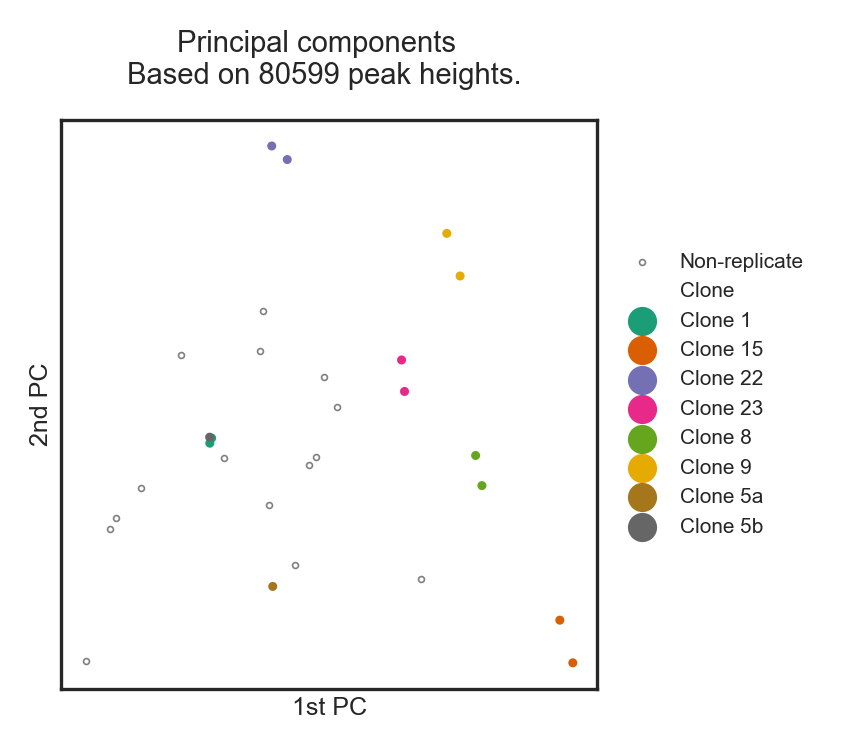

In [45]:
sns.set_style("white")

fig, ax = plt.subplots(1,1,figsize=(2.8,2.5), dpi=300)
setfontsize()

X = ATAC_df.T
clr_list = ['1', '15', '22', '23', '8', '9', '5a', '5b']
def clone_rename(cl):
    cl_strip = cl.split('_')[0]
    if cl_strip[5:] in clr_list:
        return 'Clone '+cl_strip[5:]
    else:
        return 'Other'
    
y = [clone_rename(cl) for cl in ATAC_df.columns]
hue_order = ['Clone '+a for a in clr_list]

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X) # Apply PCA with 10 components.

cl_df = pd.DataFrame(X_pca, columns = ['1st PC', '2nd PC'], index=X.index) # Just for graphing.
cl_df['Clone'] = y

sns.scatterplot(x='1st PC', y='2nd PC', data = cl_df[cl_df['Clone'] == 'Other'], s=2, 
                color='white', edgecolor='gray', linewidth=0.4, ax=ax, label='Non-replicate')

sns.scatterplot(x='1st PC', y='2nd PC', hue='Clone', hue_order = hue_order, palette='Dark2',
                data = cl_df[cl_df['Clone'] != 'Other'], s=2, edgecolor=None, ax=ax)

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.xaxis.labelpad = -5
ax.yaxis.labelpad = -5


plt.legend(loc='upper left', bbox_to_anchor=(1.01, 0.8), ncol=1, framealpha=0.0)

plt.suptitle("Principal components \n "
             "Based on {} peak heights.".format(len(X.T)), 
            y=1.0)

set_size(fig, (2.8, 2.5))
plt.savefig("Figure4_panels/PCA.pdf", bbox_inches='tight')

plt.show()

Note that the PC plot puts Clone 5b right on top of Clone 1 (and somewhat far from clone 5a).  So two principal components do not suffice to detect the proximity of the sister clones!

#  Comparison to gene expression in P1902 and P3128

Here we load some gene significance data from P1902 and P3128.

In [59]:
gene_info_P1902 = pd.read_pickle('P1902_gene_info.pkl')
gene_info_P1902.head()

Gene_name  Mean_expression    F_logp    H_logp  \
Gene stable ID                                                       
ENSG00000227232        WASH7P         0.807160  3.872295  2.685482   
ENSG00000225630      MTND2P28         3.764171  1.884708  1.903048   
ENSG00000237973  hsa-mir-6723         2.937019  1.324402  1.229997   
ENSG00000248527      MTATP6P1         8.953032  7.264160  7.580882   
ENSG00000188976         NOC2L         0.570183  0.412777  0.530897   

                 Onoff_logp   Onratio  
Gene stable ID                         
ENSG00000227232    2.779310  0.115942  
ENSG00000225630    0.033072  0.704348  
ENSG00000237973    0.390385  0.434783  
ENSG00000248527   -0.000000  1.000000  
ENSG00000188976    0.375674  0.072464

In [60]:
gene_info_P3128 = pd.read_pickle('P3128_gene_info.pkl')
gene_info_P3128.head()

Gene_name  Mean_expression    F_logp    H_logp  \
Gene stable ID                                                       
ENSG00000227232        WASH7P         1.729623  6.390167  5.568994   
ENSG00000225630      MTND2P28         5.370519  1.007011  1.797389   
ENSG00000237973  hsa-mir-6723         3.616551  4.067691  3.258932   
ENSG00000248527      MTATP6P1         9.238850  2.886275  2.551824   
ENSG00000228794     LINC01128         0.472638  0.155799  0.126303   

                   Onoff_logp   Onratio  
Gene stable ID                           
ENSG00000227232  5.308303e-01  0.386364  
ENSG00000225630 -0.000000e+00  0.993506  
ENSG00000237973  2.737561e-10  0.844156  
ENSG00000248527 -0.000000e+00  1.000000  
ENSG00000228794  1.656758e-01  0.068182

In [61]:
genes_overlap = [gene for gene in gene_info_P1902.index if gene in gene_info_P3128.index]
print('There are {} genes considered in both experiments P1902 and P3128.'.format(len(genes_overlap)))

There are 7190 genes considered in both experiments P1902 and P3128.


We consolidate the data from the two experiments into one dataframe.

In [62]:
gene_info = pd.DataFrame(index=genes_overlap)
statlist = ['Mean_expression','F_logp','Onoff_logp','Onratio'] 
for stat in statlist:
    gene_info[stat+'_P1902'] = gene_info_P1902[stat]
    gene_info[stat+'_P3128'] = gene_info_P3128[stat]

gene_info.head()

Mean_expression_P1902  Mean_expression_P3128  F_logp_P1902  \
ENSG00000227232               0.807160               1.729623      3.872295   
ENSG00000225630               3.764171               5.370519      1.884708   
ENSG00000237973               2.937019               3.616551      1.324402   
ENSG00000248527               8.953032               9.238850      7.264160   
ENSG00000188976               0.570183               1.594490      0.412777   

                 F_logp_P3128  Onoff_logp_P1902  Onoff_logp_P3128  \
ENSG00000227232      6.390167          2.779310      5.308303e-01   
ENSG00000225630      1.007011          0.033072     -0.000000e+00   
ENSG00000237973      4.067691          0.390385      2.737561e-10   
ENSG00000248527      2.886275         -0.000000     -0.000000e+00   
ENSG00000188976      1.002545          0.375674      5.727705e-01   

                 Onratio_P1902  Onratio_P3128  
ENSG00000227232       0.115942       0.386364  
ENSG00000225630       0.704348       0.993506  
ENSG00000237973       0.434783       0.844156  
ENSG00000248527       1.000000       1.000000  
ENSG00000188976       0.072464       0.217532

We study patterns of overlapping significance among genes in these two experiments.

In [160]:
def rect_venn(x_ser, y_ser, xtitle = '', ytitle = '', title='', num = 7, figsize=(8,8)):
    desetfontsize()
    if len(x_ser.index) != len(y_ser.index):
        print('Indices must match.')
        return None
    else:
        index = x_ser.index
    
    x_max = x_ser.max()
    y_max = y_ser.max()
    
    x_cuts = [0,2] + [int(x*x) for x in np.linspace(2,np.sqrt(x_max+1),num-2)]
    y_cuts = [0,2] + [int(y*y) for y in np.linspace(2,np.sqrt(y_max+1),num-2)]
    
    x_rtcuts = [np.sqrt(x) for x in x_cuts]
    y_rtcuts = [np.sqrt(y) for y in y_cuts]
    
    sns.set()
    fig,ax = plt.subplots(figsize=figsize)
    ax.set_xticks(x_rtcuts)
    ax.set_xticklabels(x_cuts)
    ax.set_yticks(y_rtcuts)
    ax.set_yticklabels(y_cuts)

    for i in range(len(x_cuts) - 1):
        for j in range(len(y_cuts) - 1):
            xmin, xmax = x_rtcuts[i], x_rtcuts[i+1]
            ymin, ymax = y_rtcuts[j], y_rtcuts[j+1]
            color = (1-i*0.05,1,1-j*0.05)
            inbox = [ind for ind in index if x_ser[ind] >= x_cuts[i] and x_ser[ind] < x_cuts[i+1] and
                     y_ser[ind] >= y_cuts[j] and y_ser[ind] < y_cuts[j+1]]
        
        
            left, width = xmin, xmax - xmin
            bottom, height = ymin, ymax-ymin
            right = left + width
            top = bottom + height
            ax.add_patch(plt.Rectangle((left,bottom), width, height, zorder=-2, color=color))
        
            offset = 0
            if len(inbox) == 1:
                plural = ''
            else:
                plural = 's'
            ax.text(0.5 * (left + right), 0.5 * (bottom + top) - offset, '{} \n gene{}'.format(
                len(inbox),plural), horizontalalignment='center', verticalalignment='center', color = 'k')

    sns.scatterplot(np.sqrt(x_ser), np.sqrt(y_ser), ax=ax, c=[(0.7,0.3,0.2,0.8)], s=1.5, 
                    edgecolor = None, legend=None) #color=(1,0.9,0.9))
    ax.set_xlabel(xtitle)
    ax.set_ylabel(ytitle)

    #sig_genes = [gene for gene in genes if H_logp[gene] > 2 and F_logp[gene] > 2]

    plt.suptitle(title)
    plt.show()

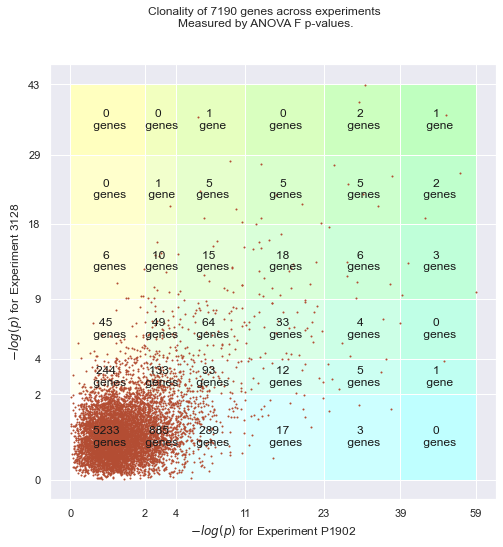

In [161]:
rect_venn(gene_info['F_logp_P1902'], gene_info['F_logp_P3128'], xtitle='$-log(p)$ for Experiment P1902', 
         ytitle='$-log(p)$ for Experiment 3128', title='Clonality of {} genes across experiments \n'
         'Measured by ANOVA F p-values.'.format(len(gene_info)))

In [65]:
for cut in [0, 2, 3, 6, 12, 20, 40]:
    genes_above = gene_info[gene_info['F_logp_P1902'] > cut]
    siggenes_above = genes_above[genes_above['F_logp_P3128'] > 2]
    ratio = len(siggenes_above) / len(genes_above)
    if cut == 0:
        print('{:1.1%} of all genes are significant (p<0.01) in P3128.'.format(ratio,cut))
    else:
        print('{:1.1%} of genes with p < 1e-{} in experiment P1902 are significant (p<0.01) in P3128.'.format(ratio,cut))

10.6% of all genes are significant (p<0.01) in P3128.
28.2% of genes with p < 1e-2 in experiment P1902 are significant (p<0.01) in P3128.
38.4% of genes with p < 1e-3 in experiment P1902 are significant (p<0.01) in P3128.
64.7% of genes with p < 1e-6 in experiment P1902 are significant (p<0.01) in P3128.
83.8% of genes with p < 1e-12 in experiment P1902 are significant (p<0.01) in P3128.
89.1% of genes with p < 1e-20 in experiment P1902 are significant (p<0.01) in P3128.
100.0% of genes with p < 1e-40 in experiment P1902 are significant (p<0.01) in P3128.


In [66]:
genes_bothsig = gene_info[(gene_info['F_logp_P1902'] > 6) & (gene_info['F_logp_P3128'] > 6)]
genes_bothsig = list(genes_bothsig.index)

In [67]:
print('The following genes are signifcant at the p<0.000001 level in both experiments:', ', '.join([gene_names[gene] for gene in genes_bothsig]))

The following genes are signifcant at the p<0.000001 level in both experiments: ISG15, TNFRSF18, None, ID3, SH3BGRL3, CD52, CSF1, REG4, S100A4, SLAMF7, SELL, CREM, SRGN, ENTPD1, IFITM2, IFITM1, IFITM3, MALAT1, CTSW, SMCO4, CADM1, CD9, CD27, LAG3, KLRB1, CLECL1, KLRD1, KLRC3, KLRC2, KLRC1, None, IFNG, PHLDA1, PMCH, ALOX5AP, LPAR6, RCBTB2, GZMH, GZMB, ASB2, B2M, ISG20, IDH2, LRRC28, IL32, MAF, COTL1, CCL5, CCL23, HOXB2, CD7, CD70, ZBTB32, RPS19, FTL, LAIR2, None, EPAS1, TMSB10, CAPG, CD28, CTLA4, SIRPG, APOBEC3C, EOMES, CMTM6, CXCR6, CCR2, RPL38P4, GPR15, TRAT1, STAP1, GZMA, SOX4, HLA-B, HLA-DRB5, HLA-DRB6, HLA-DRB1, HLA-DQB1, HLA-DMA, HLA-DPA1, CDKN1A, SAMD3, PDE7B, ACTB, LAT2, ERI1, DPYSL2, RDH10, LINC00861, ANXA1, CTSL, MT-RNR2, MT-TE, MT-CYB, ITM2A, PLS3, CD40LG, None


# Analysis of gene expression in P9855

Here we look at clonal variation in gene expression in P9855.  We also compare the clonal genes in P9855 to the other experiments P1902 and P3128.  We restrict attention to the clones which have 3 samples in each.  The figures here are not prepared for publication. 

In [68]:
E_3samples = [sample for sample in E_samples if meta_df.Clone_ID[sample] in E_3clones]
EM_3 = EM.loc[E_3samples]
print('{} samples belong to the {} 3-sample clones.'.format(len(E_3samples), len(E_3clones)))

69 samples belong to the 23 3-sample clones.


Now we run an ANOVA F test on these 23 groups of 3 samples each.

In [69]:
EM_var = pd.DataFrame(index = EM_3.columns)
N = len(EM_3)
K = len(E_3clones)
EM_varwithin = (2 / (N-K)) * EM_3.groupby(meta_df.Clone_ID).var().sum()
EM_clonal = EM_3.groupby(meta_df.Clone_ID).mean()
EM_vargroup = 3*EM_clonal.var()
EM_var['F'] = EM_vargroup / EM_varwithin
EM_var['p'] = pd.Series(ss.f.sf(EM_var['F'], N-1, K-1), index=EM_var.index)
EM_var['logp'] = -np.log10(EM_var['p'])
EM_var.head()

F         p      logp
ENSG00000000419  1.028906  0.491184  0.308756
ENSG00000000457  1.033881  0.485703  0.313629
ENSG00000000460  1.224516  0.304779  0.516014
ENSG00000001036  2.076253  0.028856  1.539770
ENSG00000001084  0.930641  0.605065  0.218198

In [70]:
EM_var.to_csv('P9855_clonalgenes.csv')

Since the sample size is pretty small (3 per group), we run permute the clone labels just to assess the validity of the p-values above.

In [71]:
clone_shuff = meta_df.loc[E_3samples].copy()
clone_shuff['Clone_ID'] = np.random.permutation(clone_shuff['Clone_ID'])
clone_shuff = clone_shuff['Clone_ID']
EM_var_shuff = pd.DataFrame(index = EM_3.columns)

EM_varwithin_shuff = (2 / (N-K)) * EM_3.groupby(clone_shuff).var().sum()
EM_clonal_shuff = EM_3.groupby(clone_shuff).mean()
EM_vargroup_shuff = 3*EM_clonal_shuff.var()
EM_var_shuff['F'] = EM_vargroup_shuff / EM_varwithin_shuff
EM_var_shuff['p'] = pd.Series(ss.f.sf(EM_var_shuff['F'], N-1, K-1), index=EM_var_shuff.index)
EM_var_shuff['logp'] = -np.log10(EM_var_shuff['p'])
EM_var_shuff.head()

F         p      logp
ENSG00000000419  0.672917  0.890743  0.050248
ENSG00000000457  0.891051  0.652825  0.185203
ENSG00000000460  0.855614  0.695614  0.157632
ENSG00000001036  0.833305  0.722277  0.141296
ENSG00000001084  1.390237  0.195628  0.708570

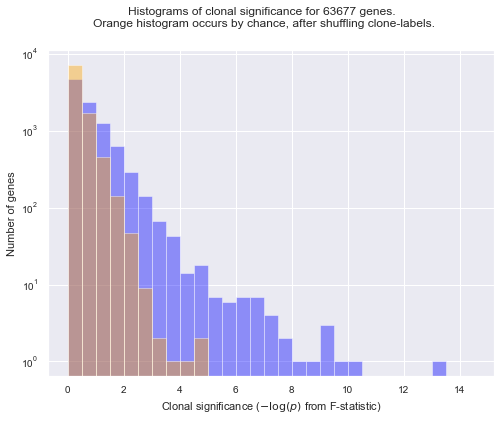

In [162]:
desetfontsize()

fig,ax = plt.subplots(figsize=(8,6))
bins = np.arange(0,15,0.5)
sns.distplot(EM_var['logp'], kde=False, color='blue', bins=bins)
sns.distplot(EM_var_shuff['logp'], kde=False, color='orange', bins=bins)
ax.set_xlabel('Clonal significance ($-\log(p)$ from F-statistic)')
ax.set_ylabel('Number of genes')
plt.yscale('log')
plt.suptitle('Histograms of clonal significance for {} genes. \n'
            'Orange histogram occurs by chance, after shuffling clone-labels.'.format(len(genes)))
plt.show()

Note that we are using *unadjusted* p-values in the plots above.  So if we pull out the genes with p<0.01, we'll get a lot of false hits.  

In [75]:
genes_sig_9855 = EM_var[EM_var['logp'] > 2].index
print('{} genes found with p<0.01, and {} expected by chance'.format(len(genes_sig_9855), len(EM_3.columns) * 0.01))

617 genes found with p<0.01, and 95.87 expected by chance


In [76]:
genes_sig_1902 = gene_info[gene_info['F_logp_P1902'] > 2].index
genes_sig_3128 = gene_info[gene_info['F_logp_P3128'] > 2].index

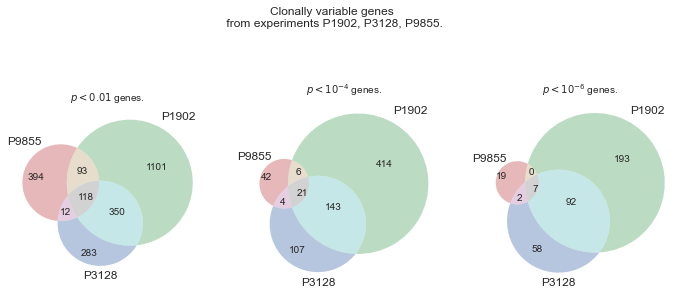

In [163]:
desetfontsize()
fig,ax = plt.subplots(1,3,figsize=(12,5))
pcuts = [2,4,6]
labels = ['$p<0.01$','$p<10^{-4}$','$p<10^{-6}$']
for j in [0,1,2]:
    gs_1902 = gene_info[gene_info['F_logp_P1902'] > pcuts[j]].index
    gs_3128 = gene_info[gene_info['F_logp_P3128'] > pcuts[j]].index
    gs_9855 = EM_var[EM_var['logp'] > pcuts[j]].index
    v = venn3([set(gs_9855), set(gs_1902), set(gs_3128)], ax=ax[j])
    v.get_label_by_id('A').set_text('P9855')
    v.get_label_by_id('B').set_text('P1902')
    v.get_label_by_id('C').set_text('P3128')
    ax[j].set_title(labels[j]+' genes.')
plt.suptitle('Clonally variable genes \n from experiments P1902, P3128, P9855.',y=1.02)
plt.show()

# Analysis of ATAC peaks

## Dispersion between replicates, and the distribution of peak heights

We begin by looking at the general distribution of peak heights.  By looking at the six pairs of replicates, we can study the "noise" manifest as dispersion between replicates.  Once we understand this noise, we can assess peak height variability between clones, properly accounting for this noise. 

For each of the six clones with replicates (Clones 1, 15, 22, 23, 8, 9), and each peak interval, we have two measured peak heights:  $R_1$ and $R_2$.  We place these in separate dataframes, along with their difference $\delta = R_2 - R_1$ and mean $\mu = \frac{1}{2}(R_1 + R_2)$, and $\delta^2$ (squared-difference), and dispersion $\delta^2 / 2 \mu$.  

In [78]:
ATAC_pairs_dfdict = {}
for parent in parents:
    ATAC_par = ATAC_df[[parent+'_R1', parent+'_R2']].copy()
    ATAC_par.columns = ['R1','R2']
    ATAC_par['mean'] = ATAC_par.mean(axis=1)
    ATAC_par['delta'] = ATAC_par['R2'] - ATAC_par['R1']
    ATAC_par['deltasq'] = ATAC_par['delta']**2
    ATAC_par['disp'] = ATAC_par['deltasq'] / (2*ATAC_par['mean'])
    ATAC_pairs_dfdict[parent] = ATAC_par
ATAC_pairs_dfdict['clone1'].head()

R1          R2        mean      delta     deltasq  \
PeakID                                                                      
Interval_77062    8.216276   12.122195   10.169235   3.905919   15.256200   
Interval_18293    0.000000    1.212219    0.606110   1.212219    1.469476   
Interval_51938    9.129196   14.546634   11.837915   5.417438   29.348634   
Interval_33832    7.303357    7.879427    7.591392   0.576070    0.331857   
Interval_13433  289.395502  260.021076  274.708289 -29.374426  862.856877   

                    disp  
PeakID                    
Interval_77062  0.750115  
Interval_18293  1.212219  
Interval_51938  1.239603  
Interval_33832  0.021857  
Interval_13433  1.570497

The average value of $\delta$ should be close to zero.  Otherwise, there might be an experimental error leading to Replicate 2 being systematically higher or lower than Replicate 1.  Let's check.

In [79]:
for parent in parents:
    print('The average difference R_2 - R_1 among {} is {}'.format(
        parent, ATAC_pairs_dfdict[parent].mean().delta))

The average difference R_2 - R_1 among clone1 is 0.06318093738120803
The average difference R_2 - R_1 among clone15 is 0.1638463200699437
The average difference R_2 - R_1 among clone22 is -0.1676348985986052
The average difference R_2 - R_1 among clone23 is -0.09270227849902253
The average difference R_2 - R_1 among clone8 is -0.14860082193270682
The average difference R_2 - R_1 among clone9 is -0.24007166899724422


## Distribution of mean peak heights

Now we study the distribution of the means, $\frac{1}{2} (R_1 + R_2)$, for each clone separately.  We expect these distributions to be similar, from one clone to the next.

In [80]:
dist_df = pd.DataFrame(index = parents, columns=['slope', 'intercept'])

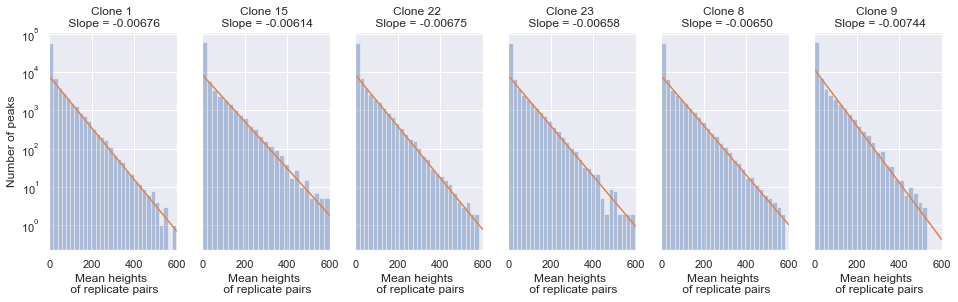

In [81]:
fig,ax = plt.subplots(1,6,figsize=(16,4), sharey=True)
histy = {}
bins = 30
j=0
for parent in parents:
    if j == 0:
        ax[j].set_ylabel('Number of peaks')
    histp = np.histogram(ATAC_pairs_dfdict[parent]['mean'], bins=bins)
    histy[parent] = pd.DataFrame(index = histp[1][:-1], columns=['Actual', 'Expon'])
    histy[parent]['Actual'] = histp[0]
    reg = ss.linregress(histp[1][5:20], np.log10(histp[0][5:20]))
    histy[parent]['Expon'] = 10**(reg.intercept + reg.slope*histp[1][:-1])
    dist_df.loc[parent].slope = reg.slope
    dist_df.loc[parent].intercept = reg.intercept
    
    ax[j].set_xlim(0,600)
    ax[j].set_title('Clone {} \n Slope = {:1.5f}'.format(parent[5:], reg.slope))
    sns.distplot(ATAC_pairs_dfdict[parent]['mean'], kde=False, bins=30, ax=ax[j])
    #sns.lineplot(histy[1][3:20], histy[0][3:20], ax=ax[j])
    
    ax[j].plot([0, 600], [10**(reg.intercept), 10**(reg.intercept + 600*reg.slope)])
    ax[j].set_xlabel('Mean heights \n of replicate pairs')
    #print(reg.slope)
    j += 1
plt.yscale('log')

Note that the distributions -- for all six clones -- look like exponential distributions.  We've plotted the histograms above on a log-scale, and all look linear, with roughly the same slope.  The exception is at the very low end, where we see an excess of peaks in all six clones with height near zero.  We focus on these low-height peaks below.

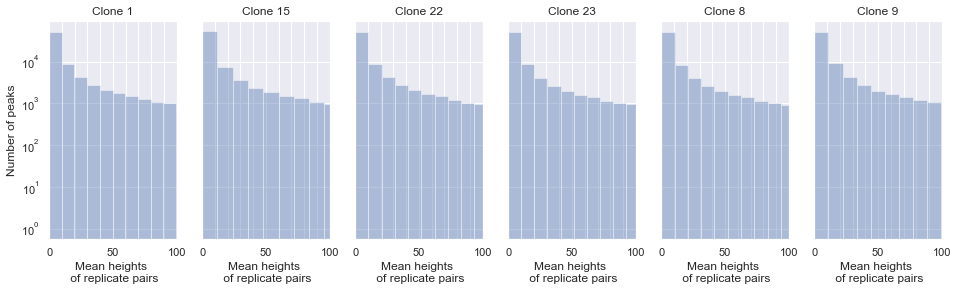

In [82]:
fig,ax = plt.subplots(1,6,figsize=(16,4), sharey=True)
j=0
for parent in parents:
    if j == 0:
        ax[j].set_ylabel('Number of peaks')
    ax[j].set_xlim(0,100)
    ax[j].set_xticks(range(0,101,10))
    ax[j].set_xticklabels(['0','','','','','50','','','','','100'])
    ax[j].set_title('Clone {}'.format(parent[5:]))
    sns.distplot(ATAC_pairs_dfdict[parent]['mean'], kde=False, ax=ax[j], bins=60)
    ax[j].set_xlabel('Mean heights \n of replicate pairs')
    j += 1
plt.yscale('log')

We fit the exponential distributions here, just based on the peaks of heights between 25 and 250.

In [83]:

for parent in parents:
    data = ATAC_pairs_dfdict[parent]['mean']
    loc, scale = expon.fit(data[(data > 25) & (data < 250)].values,floc=0) # No shift!
    lam = 1/scale
    print('Clone {} fits the exponential distribution with loc {:1.3} and lambda {:1.4}.'.format(parent[5:],loc, lam))

Clone 1 fits the exponential distribution with loc 0.0 and lambda 0.01227.
Clone 15 fits the exponential distribution with loc 0.0 and lambda 0.01151.
Clone 22 fits the exponential distribution with loc 0.0 and lambda 0.01212.
Clone 23 fits the exponential distribution with loc 0.0 and lambda 0.01185.
Clone 8 fits the exponential distribution with loc 0.0 and lambda 0.01186.
Clone 9 fits the exponential distribution with loc 0.0 and lambda 0.01214.


## Distribution within replicate pairs.

Now we look at the "noise" -- the distribution of the pairs of peak heights within each replicate, i.e., the differences $R_1 - R_2$ the difference-squared $(R_1 - R_2)^2$ and the dispersion.

In [84]:
def qq_clone(clone, dist='norm', mlist=[10,25,50,75,100,200,300]):
    fig,ax = plt.subplots(1,len(mlist), figsize=(len(mlist)*4,3))

    for j in range(len(mlist)):
        m = mlist[j]
        data = ATAC_pairs_dfdict[clone]
        data = data[(m-2 < data['mean']) & (data['mean'] < m+2)]
        sd = np.sqrt(data.disp.mean() * m / 2)
        if dist == 'norm':
            sm.qqplot(data.R2.values, loc=m, scale=sd, line='45', ax=ax[j], c='blue')
            sm.qqplot(data.R1.values, loc=m, scale=sd, line='45', ax=ax[j], c='green')
        elif dist == 'gamma':
            sm.qqplot(data.R2.values, dist=dist, fit=True, line='45', ax=ax[j], c='blue')
            sm.qqplot(data.R1.values, dist=dist, fit=True, line='45', ax=ax[j], c='green')
        stat, p = ss.shapiro(data.R2.values)
        ax[j].set_title('Q-Q plot for {} replicates with \n mean peak height ${} \pm 2$. \n'
                 'Shapiro-Wilk p-value {:1.3}'.format(len(data), m, p))
        if j > 0:
            ax[j].set_ylabel('')
        for sig in [-2,-1,0,1,2]:
            if sig == 0:
                color='black'
            else:
                color='lightgray'
            ax[j].axvline(m + sig*sd, color=color)
    plt.show()

Here we provide Q-Q plots for replicate pairs, near 6 peak heights.  Green dots = Replicate 1 and blue dots = Replicate 2.  Deviation from diagonal indicates deviation from normality, also detected by small Shapiro-Wilk p-value.

/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


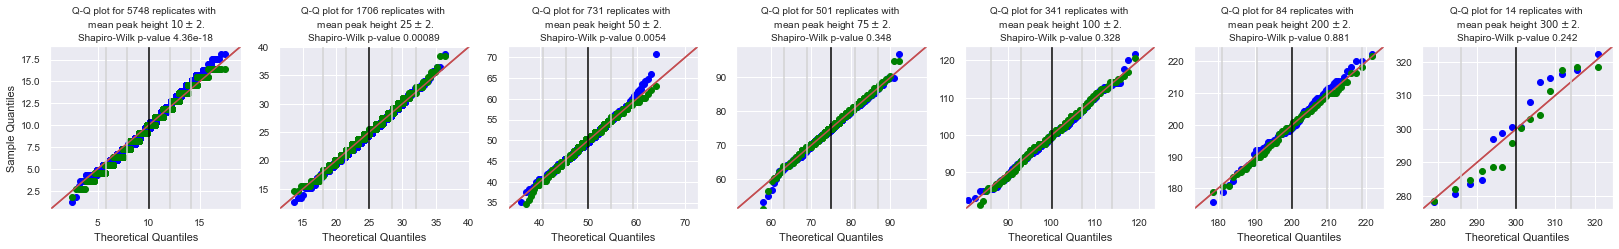

/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


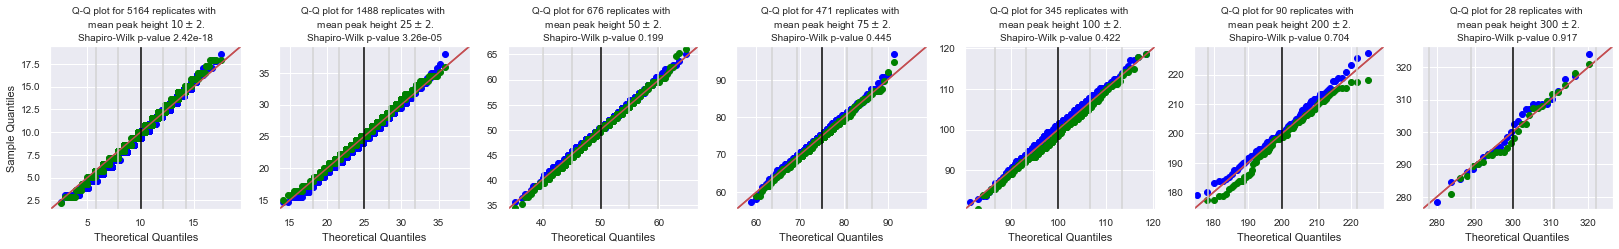

/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


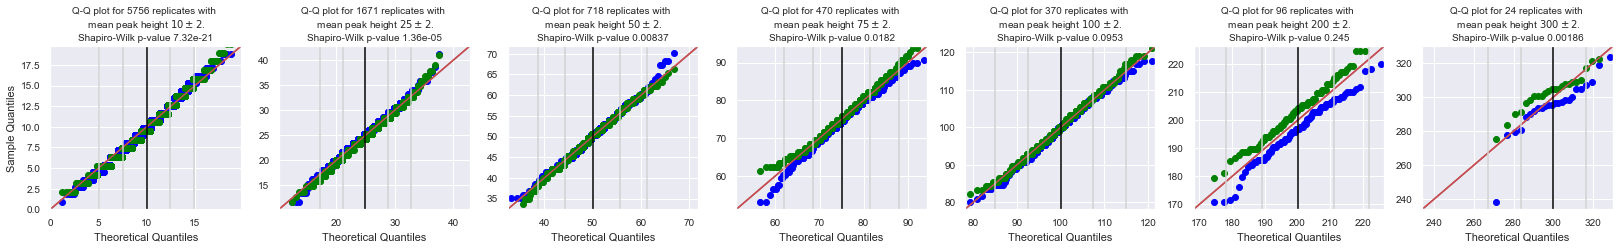

/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


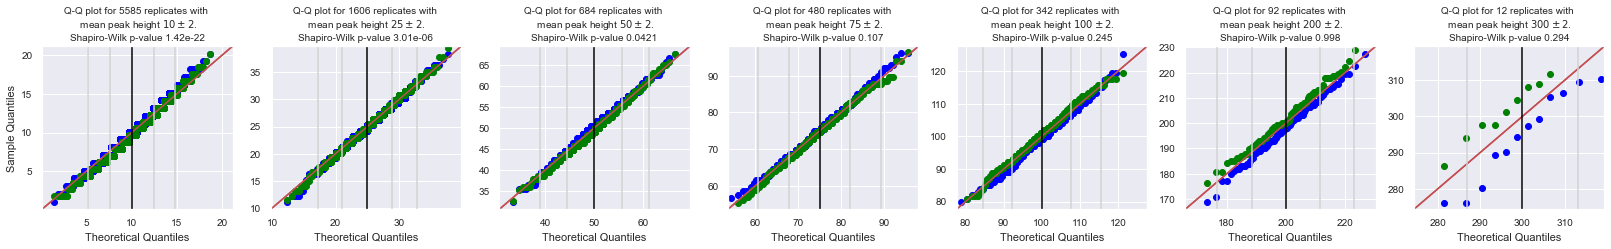

/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


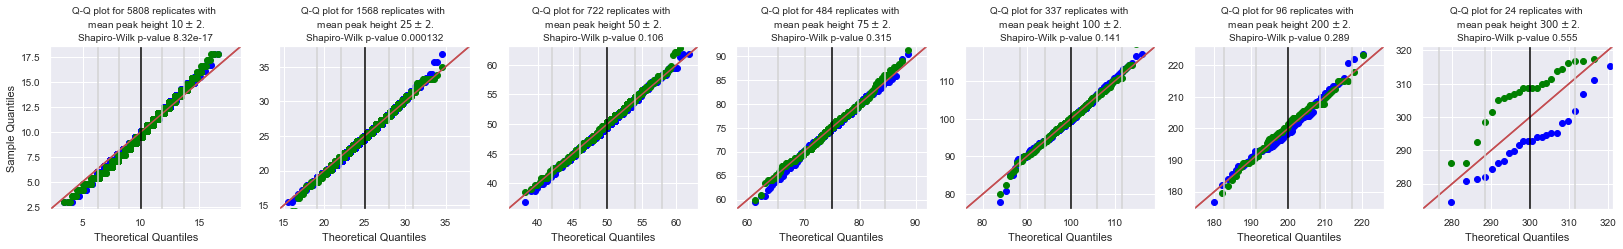

/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


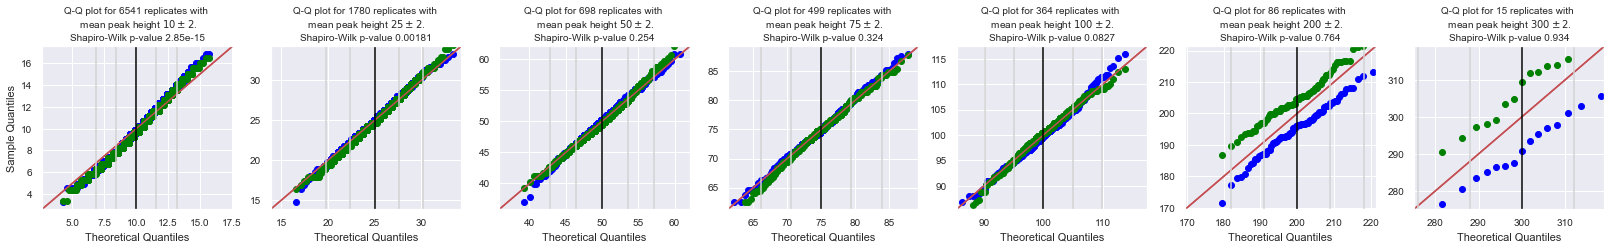

In [164]:
desetfontsize()
for parent in parents:
    qq_clone(parent, dist='norm')

Next we look at the relationship between mean peak height and dispersion, again taking a closer look at small peaks due to differences in distributions at the low end.  We take a rolling median and rolling 95th percentile to look at median dispersion and 95th percentile of dispersion, as a function of mean peak height.

In [86]:
ATAC_disp_dict = {}
for parent in parents:
    ATAC_meanroll = ATAC_pairs_dfdict[parent].sort_values(['mean']).rolling(1000)
    ATAC_qr_df = pd.DataFrame(ATAC_meanroll.mean()['mean'])
    ATAC_qr_df['disp95'] = ATAC_meanroll.quantile(0.95)['disp']
    ATAC_qr_df['med'] = ATAC_meanroll.quantile(0.5)['disp']
    ATAC_qr_df.dropna(inplace=True)
    ATAC_disp_dict[parent] = ATAC_qr_df

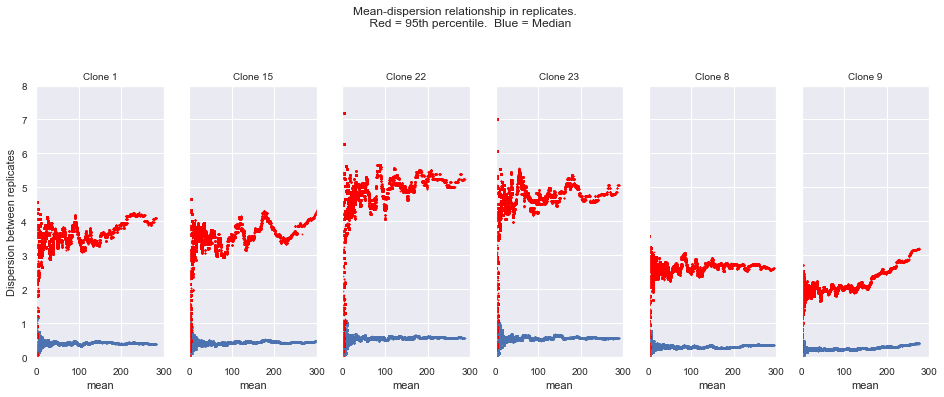

In [165]:
desetfontsize()
fig,ax = plt.subplots(1,6,figsize=(16,5), sharey=True)
j=0
for parent in parents:
    
    ax[j].set_xlim(0,300)
    ax[j].set_ylim(0,8)
    ax[j].set_xlabel('Mean height of replicate pair')
    #ax[j].set_xticks(range(0,101,10))
    #ax[j].set_xticklabels(['0','','','','','50','','','','','100'])
    ax[j].set_title('Clone {}'.format(parent[5:]))
    sns.scatterplot(ATAC_disp_dict[parent]['mean'], ATAC_disp_dict[parent]['med'] , ax=ax[j],
                   edgecolor=None, s=1.0)
    sns.scatterplot(ATAC_disp_dict[parent]['mean'], ATAC_disp_dict[parent]['disp95'] , ax=ax[j],
                   edgecolor=None, s=1.0, color='red')
    if j == 0:
        ax[j].set_ylabel('Dispersion between replicates')
    j += 1
plt.suptitle('Mean-dispersion relationship in replicates.  \n Red = 95th percentile.  Blue = Median', y=1.1)
plt.show()

Here we look at peak heights $y$ that occur in a replicate pair with $0$, i.e., pairs with $R_1 = 0$ and $R_2 = y$.  What is the distribution of such peak heights $y$?

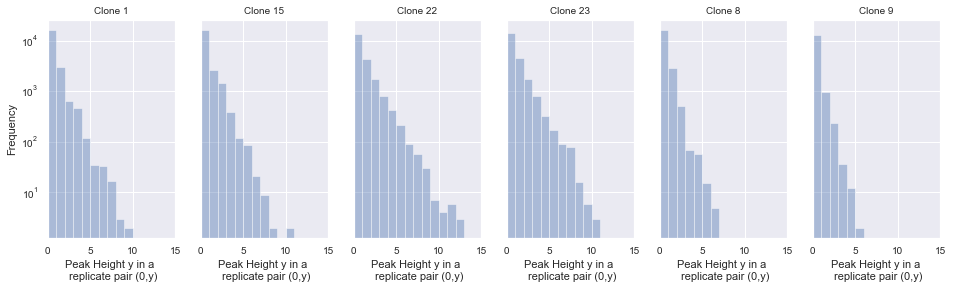

In [166]:
desetfontsize()
fig,ax = plt.subplots(1,6,figsize=(16,4), sharey=True)
j=0
for parent in parents:
    ATAC_mm = ATAC_pairs_dfdict[parent][['R1','R2']].copy()
    ATAC_mm['min'], ATAC_mm['max'] = ATAC_mm.min(axis=1), ATAC_mm.max(axis=1)
    ATAC_zeros = ATAC_mm[ATAC_mm['min'] == 0.0]
    sns.distplot(ATAC_zeros['max'], kde=False, ax=ax[j], bins=list(range(20)))
    ax[j].set_title('Clone {}'.format(parent[5:]))
    ax[j].set_xlim(0,15)
    if j == 0:
        ax[j].set_ylabel('Frequency')
    ax[j].set_xlabel('Peak Height y in a \n replicate pair (0,y)')
    j += 1
plt.yscale('log')

Note that replicate pairs in clones 22 and 23 exhibit a higher dispersion here, at the low end.  This also occurs in the graphs above showing the mean-dispersion relationship.

## Quantile regression for peak-height variability.

We use quantile regression to determine when a pair of peak heights $(a,b)$ is more dispersed than one would expect from replicates (pairs from the same clone.)  If the minimum is $min(R_1,R_2)$, we find the 90th, 95th, etc. quantiles of $\delta^2 = (R_2-R_1)^2$ among replicate pairs with minimum near $x$.  

From this, we can assign a significance score to a pair of peak heights $(a,b)$ -- a p-value $p(a,b)$ where $p(a,b)$ small indicates that the pair of peak heights probably does not come from the same clone.  In such cases, there is clonal variability in peak height.

First, we merge all the replicate-pairs into one large dataframe.

In [89]:
ATAC_pairs_df = pd.concat(ATAC_pairs_dfdict)
print('{} dataframes merged.'.format(len(ATAC_pairs_df) / len(ATAC_df)) ) # This should be 6!
ATAC_pairs_df['min'] = ATAC_pairs_df[['R1','R2']].min(axis=1)
ATAC_pairs_df['max'] = ATAC_pairs_df[['R1','R2']].max(axis=1)
display(ATAC_pairs_df.head())
print('{} peak/duplicate pairs.'.format(len(ATAC_pairs_df)))

6.0 dataframes merged.


R1          R2        mean      delta  \
       PeakID                                                          
clone1 Interval_77062    8.216276   12.122195   10.169235   3.905919   
       Interval_18293    0.000000    1.212219    0.606110   1.212219   
       Interval_51938    9.129196   14.546634   11.837915   5.417438   
       Interval_33832    7.303357    7.879427    7.591392   0.576070   
       Interval_13433  289.395502  260.021076  274.708289 -29.374426   

                          deltasq      disp         min         max  
       PeakID                                                        
clone1 Interval_77062   15.256200  0.750115    8.216276   12.122195  
       Interval_18293    1.469476  1.212219    0.000000    1.212219  
       Interval_51938   29.348634  1.239603    9.129196   14.546634  
       Interval_33832    0.331857  0.021857    7.303357    7.879427  
       Interval_13433  862.856877  1.570497  260.021076  289.395502

483594 peak/duplicate pairs.


Now we apply quantile regression for $\delta^2$ as it depends on $min(R_1, R_2)$.  I.e., how does the squared-difference between replicate peak heights depend on the *smallest* of the two peak heights.  We begin with median regression to test it out.

In [90]:
mod = smf.quantreg('deltasq ~ min', ATAC_pairs_df)
res = mod.fit(q=.5)
print(res.summary())

                         QuantReg Regression Results                          
Dep. Variable:                deltasq   Pseudo R-squared:               0.1036
Model:                       QuantReg   Bandwidth:                      0.4564
Method:                 Least Squares   Sparsity:                        3.732
Date:                Sun, 13 Sep 2020   No. Observations:               483594
Time:                        11:03:45   Df Residuals:                   483592
                                        Df Model:                            1
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1693      0.003     56.602      0.000       0.163       0.175
min            0.7725   5.53e-05    1.4e+04      0.000       0.772       0.773


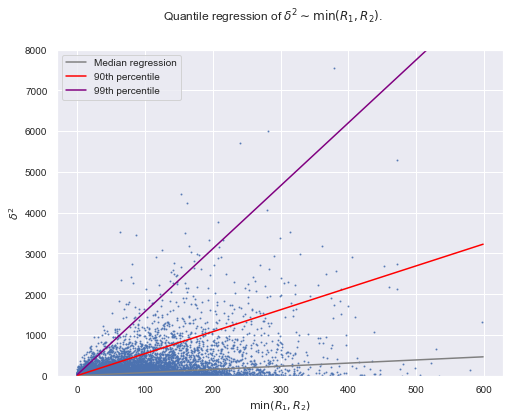

In [167]:
desetfontsize()
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(ATAC_pairs_df['min'][::10], ATAC_pairs_df.deltasq[::10], alpha=.8, s=1.0)
xlist = np.arange(0,600)
mod = smf.quantreg('deltasq ~ min', ATAC_pairs_df)
res = mod.fit(q=.5)
ax.plot(xlist, res.params['min'] * xlist + res.params['Intercept'], color='gray', label='Median regression')
res = mod.fit(q=.9)
ax.plot(xlist, res.params['min'] * xlist + res.params['Intercept'], color='red', label='90th percentile')
res = mod.fit(q=.99)
ax.plot(xlist, res.params['min'] * xlist + res.params['Intercept'], color='purple', label='99th percentile')
plt.legend()
ax.set_ylabel('$\delta^2$')
ax.set_xlabel('$\min(R_1, R_2)$')
ax.set_ylim(0,8000)
plt.suptitle('Quantile regression of $\delta^2 \sim \min(R_1, R_2)$.')
plt.show()

We examine quantiles from 90th to 99.99th, in regular intervals below.

In [92]:
arten = np.arange(9)
quantiles = np.concatenate([0.9 + arten / 100, 0.99 + arten/1000, 0.999 + arten/10000, [0.9999]])
print(quantiles)

[0.9    0.91   0.92   0.93   0.94   0.95   0.96   0.97   0.98   0.99
 0.991  0.992  0.993  0.994  0.995  0.996  0.997  0.998  0.999  0.9991
 0.9992 0.9993 0.9994 0.9995 0.9996 0.9997 0.9998 0.9999]


In [93]:
mod = smf.quantreg('deltasq ~ min', ATAC_pairs_df)
qlines_df = pd.DataFrame(index=quantiles, columns=['intercept', 'slope'])
for q in quantiles:
    res = mod.fit(q=q)
    qlines_df.loc[q] = pd.Series({'intercept':res.params['Intercept'], 'slope':res.params['min']})
qlines_df.head()

intercept    slope
0.90   4.09004  5.37809
0.91    4.6406  5.75316
0.92   5.31122  6.17478
0.93    5.8779  6.67922
0.94   7.26607  7.23845

In [94]:
qlines_df['logp'] = -np.log10((1-np.array(qlines_df.index)))
qlines_df.head()

intercept    slope      logp
0.90   4.09004  5.37809  1.000000
0.91    4.6406  5.75316  1.045757
0.92   5.31122  6.17478  1.096910
0.93    5.8779  6.67922  1.154902
0.94   7.26607  7.23845  1.221849

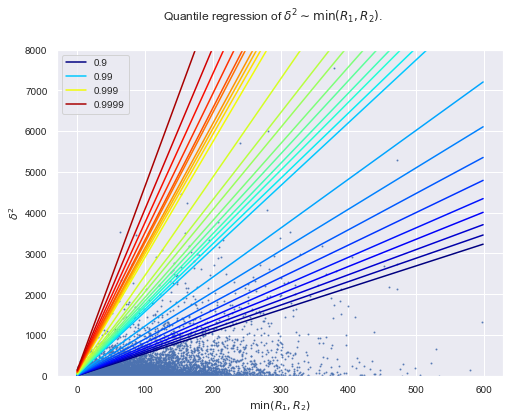

In [168]:
desetfontsize()
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(ATAC_pairs_df['min'][::10], ATAC_pairs_df.deltasq[::10], alpha=.8, s=1.0)
xlist = np.arange(0,600)
colors = {quantiles[j] : cm.jet(j / len(quantiles)) for j in range(len(quantiles)) }
for q in quantiles:
    if q in [0.9, 0.99, 0.999, 0.9999]:
        label = '{:1.4}'.format(q)
    else:
        label = None
    ax.plot(xlist, qlines_df.loc[q,'slope'] * xlist + qlines_df.loc[q,'intercept'], 
            color=colors[q], label=label)
    
plt.legend()
ax.set_ylabel('$\delta^2$')
ax.set_xlabel('$\min(R_1, R_2)$')
ax.set_ylim(0,8000)
plt.suptitle('Quantile regression of $\delta^2 \sim \min(R_1, R_2)$.')
plt.show()

The family of quantile lines can be interpolated, using an empirical linear dependence of the parameters (slope, intercept) on $\log(p)^2$.  Note that deviations at the low end will not have a big effect, since we will ignore cases with $\log(p)^2 < 2$

In [96]:
qlines_df['logpsq'] = qlines_df['logp']**2
qlines_df['intercept'] = qlines_df['intercept'].astype(float)
qlines_df['slope'] = qlines_df['slope'].astype(float)

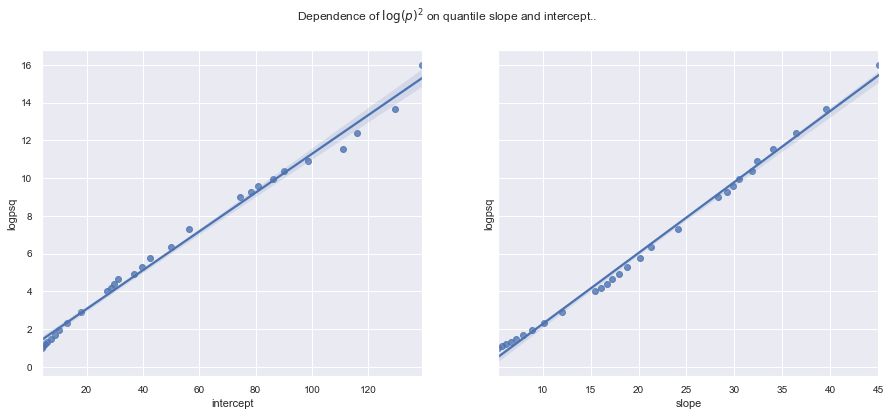

In [169]:
desetfontsize()
fig,ax = plt.subplots(1,2,figsize=(15,6), sharey=True)
sns.regplot(qlines_df['intercept'], qlines_df['logpsq'], ax=ax[0])
sns.regplot(qlines_df['slope'], qlines_df['logpsq'], ax=ax[1])
plt.suptitle('Dependence of $\log(p)^2$ on quantile slope and intercept..')
plt.show()

Let $L = \log(p)^2$.  Let $B$ be the intercept and $M$ the slope.  We find linear relationships of the form $M = aL + b$ and $B = cL + d$.  So if we have a point on a quantile line $y = Mx + B$, then we find that
$$y = (aL + b)x + (cL + d).$$
We can find $L$ using the $x,y$ coordinates and constants, using the formula
$$L = \frac{y - bx - d}{ax + c}.$$
This gives us the (squared-log) p-value.

In [99]:
a,b,r,p,s = ss.linregress(qlines_df['logpsq'], qlines_df['slope']) # Find constants a,b.
c,d,r,p,s = ss.linregress(qlines_df['logpsq'], qlines_df['intercept']) # Find constants c,d.

## Clonally variable peaks, and quality control

Now we use quantile regression on replicates to assign every peak-pair (x,y) a score -- this score approximates $-log_{10}(p)$, where the p-value represents how extremely y exceeds x.  We use this as quality control at the same time... excluding replicates (x,y) whose p-value shows that max(x,y) is much greater than min(x,y).

In [100]:
def compare_peaks(cloneA, cloneB, Adf = ATAC_df):
    df = Adf[[cloneA, cloneB]].copy()
    mu = 0.5*(df[cloneA] + df[cloneB])
    delta = df[cloneA] - df[cloneB]
    deltasq = delta**2
    num = deltasq - b*mu - d
    denom = a*mu + c
    L = num/denom
    L = L.clip(0)
    L = np.sqrt(L)
    sgns = (delta<0) * (-2) + 1.0
    L = sgns * L
    return L 

In [101]:
comp_df = pd.DataFrame(index = ATAC_df.index)
qual_df = pd.DataFrame(index = ATAC_df.index)
AT_df = pd.DataFrame(index = ATAC_df.index)
for pA in parents:
    for pB in parents:
        if pA != pB:
            AT_df['A1'] = ATAC_df[pA+'_R1']
            AT_df['A2'] = ATAC_df[pA+'_R2']
            AT_df['B1'] = ATAC_df[pB+'_R1']
            AT_df['B2'] = ATAC_df[pB+'_R2']
            AT_df['Amin'] = AT_df[['A1','A2']].min(axis=1)
            AT_df['Bmax'] = AT_df[['B1','B2']].max(axis=1)
            comp_df[pA+'>'+pB] = compare_peaks('Amin', 'Bmax', Adf = AT_df).clip(0.0)
        else:
            AT_df['min'] = ATAC_df[[pA+'_R1',pB+'_R2']].min(axis=1)
            AT_df['max'] = ATAC_df[[pA+'_R1',pB+'_R2']].max(axis=1)
            qual_df[pA+'max>min'] = compare_peaks('max', 'min', Adf = AT_df).clip(0.0)

The dataframe `qual_df` has a number for each peak, and each replicate pair.  The number reflects whether the pair of peak heights is farther apart than one expects.  A score above 2 indicates that the peak-height-pair is further apart than 99% of comparable peak-height-pairs.

In [102]:
qual_df.head()

clone1max>min  clone15max>min  clone22max>min  clone23max>min  \
PeakID                                                                          
Interval_77062       0.000000        0.000000        1.802153        0.000000   
Interval_18293       0.864613        0.986249        0.000000        0.986249   
Interval_51938       0.000000        0.967114        0.000000        1.141323   
Interval_33832       0.000000        0.000000        1.494537        0.000000   
Interval_13433       0.000000        0.000000        0.000000        1.778159   

                clone8max>min  clone9max>min  
PeakID                                        
Interval_77062       0.000000       0.751874  
Interval_18293       0.715849       0.201776  
Interval_51938       0.000000       0.000000  
Interval_33832       0.000000       0.000000  
Interval_13433       0.529937       0.000000

In [103]:
omnicomp_df = pd.DataFrame(index = ATAC_df.index)
AT_df = pd.DataFrame(index = ATAC_df.index)
for cloneA in ATAC_clones:
    for cloneB in ATAC_clones:
        AT_df['A'] = interval_df[cloneA]
        AT_df['B'] = interval_df[cloneB]
        omnicomp_df[cloneA+'>'+cloneB] = compare_peaks('A','B',Adf=AT_df).clip(0.0)

The dataframe `omnicomp` has a number for *every* pair of peaks, reflecting whether it is more spaced out than *replicate pairs* of peaks.  In this way, it compares peak heights against the null hypothesis that they come from a replicate pair.

In [104]:
omnicomp_df.head()

clone1_R1>clone1_R1  clone1_R1>clone1_R2  \
PeakID                                                     
Interval_77062             0.000000                 -0.0   
Interval_18293             0.986249                  0.0   
Interval_51938             0.000000                 -0.0   
Interval_33832             0.000000                 -0.0   
Interval_13433             0.000000                  0.0   

                clone1_R1>clone10_R1  clone1_R1>clone11_R1  \
PeakID                                                       
Interval_77062              0.000000               0.00000   
Interval_18293              0.986249               0.00000   
Interval_51938              0.000000               0.00000   
Interval_33832              0.000000               0.00000   
Interval_13433              0.000000               1.95342   

                clone1_R1>clone13_R1  clone1_R1>clone14_R1  \
PeakID                                                       
Interval_77062                   0.0              0.000000   
Interval_18293                   0.0              0.000000   
Interval_51938                   0.0              0.776748   
Interval_33832                   0.0             -0.000000   
Interval_13433                   0.0              0.000000   

                clone1_R1>clone15_R1  clone1_R1>clone15_R2  \
PeakID                                                       
Interval_77062             -0.000000             -0.000000   
Interval_18293              0.986249              0.986249   
Interval_51938             -0.000000              0.000000   
Interval_33832             -0.000000             -0.000000   
Interval_13433             -0.000000             -0.000000   

                clone1_R1>clone16_R1  clone1_R1>clone17_R1  ...  \
PeakID                                                      ...   
Interval_77062             -0.000000             -0.000000  ...   
Interval_18293              0.000000              0.986249  ...   
Interval_51938              1.848752              0.863932  ...   
Interval_33832              0.000000              0.000000  ...   
Interval_13433              0.000000              1.854519  ...   

                clone9_R2>clone24_R1  clone9_R2>clone3_R1  \
PeakID                                                      
Interval_77062             -0.000000            -0.000000   
Interval_18293             -0.000000            -0.000000   
Interval_51938              1.383602             0.218169   
Interval_33832              0.541587             0.000000   
Interval_13433              0.000000             0.000000   

                clone9_R2>clone4_R1  clone9_R2>clone5a_R1  \
PeakID                                                      
Interval_77062             0.000000              0.000000   
Interval_18293             0.290815              0.708629   
Interval_51938             0.000000              0.000000   
Interval_33832             0.000000              0.647285   
Interval_13433            -0.000000              0.000000   

                clone9_R2>clone5b_R1  clone9_R2>clone7_R1  \
PeakID                                                      
Interval_77062               0.00000            -0.000000   
Interval_18293               0.98469             0.984690   
Interval_51938              -0.00000             0.000000   
Interval_33832               0.00000             0.342478   
Interval_13433               0.00000             0.000000   

                clone9_R2>clone8_R1  clone9_R2>clone8_R2  clone9_R2>clone9_R1  \
PeakID                                                                          
Interval_77062            -0.000000             0.000000             0.000000   
Interval_18293             0.773197             0.553321             0.201776   
Interval_51938             1.640811             1.499962             0.000000   
Interval_33832             0.000000            -0.000000            -0.000000   
Interval_13433            -0.000000             0.

Now we perform a quality-control check, using the replicate pairs.

In [105]:
def Holm_min(df):
    '''
    Input should be a dataframe of -log_10(p) for p-values p.
    Each row should contain multiple pairwise comparisons.
    Output is minimum of Holm-Bonferroni adjusted p-values (each row separately)
    '''
    sort_df = (10.0**(-df)).values
    sort_df = np.sort(sort_df, axis=1)
    sort_df = pd.DataFrame(sort_df, df.index)
    dist_to_end = len(sort_df.T) - np.array(sort_df.T.index)
    Holm_df = sort_df.T.multiply(dist_to_end, axis=0) # Multiply sorted p-values by m+1-j
    Holm_df = Holm_df.clip(0.0,1.0) # Clip p-values at 1.0
    Holm_df = Holm_df.cummax()
    return Holm_df.min()

In [106]:
peak_quality = Holm_min(qual_df).sort_values()
qual_peaks = peak_quality[peak_quality > 0.05].index
print('{} out of {} peaks pass the quality control test, based on replicate-craziness.'.format(len(qual_peaks), 
                                                                                               len(interval_df)))

79762 out of 80599 peaks pass the quality control test, based on replicate-craziness.


Now we assess the clonal variability of all peaks, based on comparison to replicate pairs.

In [108]:
all_pairs = [cloneA+'>'+cloneB for cloneA in ATAC_clones for cloneB in ATAC_clones if cloneA != cloneB]
print(len(all_pairs), len(ATAC_clones) * (len(ATAC_clones) - 1)) # Should be equal.

812 812


Now we apply the Holm-Bonferroni correction to all 812 comparisons of different clones, to find adjusted p-values.  We output a list of peaks and the minimum adjusted p-value that occurs.  Note that this adjusted p-value is adjusted for individual peaks.  We have *not* adjusted for the abundance (80000+) of peaks that occur!

In [109]:
ATAC_p = Holm_min(omnicomp_df[all_pairs])

In [110]:
print('{} out of {} peaks show significant variability (unadjusted p<0.01).'.format(len(ATAC_p[ATAC_p < 0.01]), 
                                                                         len(interval_df)))


5054 out of 80599 peaks show significant variability (unadjusted p<0.01).


In [111]:
ATAC_p[ATAC_p < 0.01].sort_values()

PeakID
Interval_20259    4.333728e-14
Interval_33636    5.117112e-13
Interval_53565    7.136408e-13
Interval_64397    1.723510e-12
Interval_42183    2.976815e-12
                      ...     
Interval_78073    9.961264e-03
Interval_65238    9.974157e-03
Interval_36804    9.986741e-03
Interval_66713    9.993782e-03
Interval_31906    9.994982e-03
Length: 5054, dtype: float64

In [ ]:
# ATAC_omnivar = omnicomp_df.sum(axis=1) - qual_df.sum(axis=1)
# ATAC_omnivar.head()

In [112]:
var_peaks = ATAC_p[(ATAC_p < 0.05) & (peak_quality > 0.05)].index
print('{} highly variable (top 5%), high quality peaks found'.format(len(var_peaks)))

9365 highly variable (top 5%), high quality peaks found


## Panel:  Clonally significant peaks

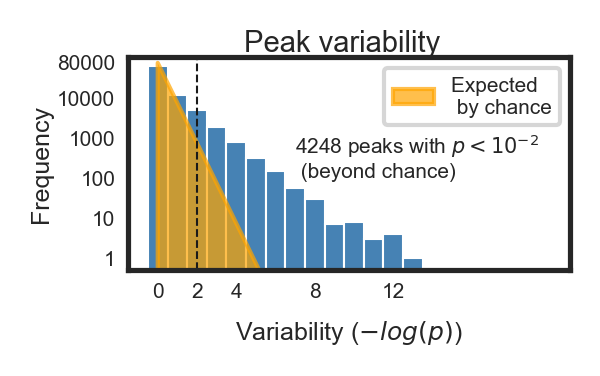

In [171]:
sns.set_style("white")

fig, ax = plt.subplots(1,1,figsize=(2.0,1.25), dpi=300)
setfontsize()

ax.hist(-np.log10((ATAC_p).clip(0,1)), bins=np.arange(0-0.5,15-0.5,1), color='steelblue', 
         linewidth=0.5, edgecolor='white')


prange = np.arange(0,21)
exp_hist = len(ATAC_p) / 10**prange
exp_hist = exp_hist - np.append(exp_hist[1:],0)
ax.fill_between(prange, 0, exp_hist, color='orange', alpha=0.7, zorder=2, label='Expected \n by chance')

cutoff = 2
signo = int(len(ATAC_p[ATAC_p < 10**(-cutoff)]) - len(ATAC_p)*10**(-cutoff))
ax.axvline(cutoff, linewidth=0.5, linestyle='--', color='k')
ax.text(7,100,'{} peaks with $p<{}$ \n (beyond chance)'.format(signo, '10^{-2}'))

ax.legend()
ax.set_xticks([0,2,4,8,12])
ax.set_xlabel('Variability ($-log(p)$)')
ax.set_ylabel('Frequency')
plt.suptitle('Peak variability')
plt.yscale('log')
plt.ylim(0.5,100000)

ax.tick_params(axis='both', which='major', pad=-3)
ax.yaxis.labelpad = 1

ax.set_yticks([1, 10, 100, 1000, 10000, 80000])
ax.get_yaxis().set_major_formatter(ScalarFormatter())

set_size(fig, (2.0,1.25))

plt.savefig("Figure4_panels/Peaks_ClonalSig.pdf", bbox_inches='tight')

plt.show()

## Visualizations

The following is a tool for visualizing peak heights for one or more peaks.

In [172]:
A_clones = ATAC_df.columns
A_clones_num = pd.Series(index=A_clones, dtype=int)
for clone in A_clones:
    cnums = re.findall('\d+',clone)
    cnums = [int(ns) for ns in cnums]
    A_clones_num[clone] = cnums[0]*100 + cnums[1]
A_clones_num['clone5a_R1'] = 503
A_clones_num['clone5b_R1'] = 504
A_clones_num = A_clones_num.sort_values()

A_clones = ATAC_df.columns
A_clones_num = pd.Series(index=A_clones, dtype=int)
for clone in A_clones:
    cnums = re.findall('\d+',clone)
    cnums = [int(ns) for ns in cnums]
    A_clones_num[clone] = cnums[0]*100 + cnums[1]
A_clones_num['clone5a_R1'] = 503
A_clones_num['clone5b_R1'] = 504
A_clones_num = A_clones_num.sort_values()

def ATAC_vis(peaks, height=2):
    desetfontsize()
    def plot_peak(peak, ax):
        heights = ATAC_df.loc[peak].copy()
        data = pd.DataFrame(index = A_clones_num.index, columns = ['Clone', 'Height', 'Replicate'])
        data['Clone'] = A_clones_num // 100
        data['Height'] = heights
        data['Replicate'] = A_clones_num % 100
        sns.stripplot(x="Clone", y="Height", hue = 'Replicate', data=data, ax=ax)
        xtl = list(ax.get_xticklabels())
        xtl = [x.get_text() for x in xtl]
        xtl = ['5a/b' if label == '5' else label for label in xtl]
        ax.set_xticklabels(xtl)
        
    sns.set(style="darkgrid")
    rect = Rectangle((0,0),22,10,linewidth=0,edgecolor=None,facecolor=(0.5,0.5,0.5,0.5))
    if type(peaks) == str:
        no_peaks = 1
        fig,ax = plt.subplots(figsize=(len(A_clones) / 2.5,height))
        plot_peak(peaks, ax)
        ptitle = 'ATAC peak heights for {}.  \n'.format(peaks.replace('_',' '))
        ptitle += 'Variability p = {:1.2e}, Quality p = {:1.2e}.'.format(
            ATAC_p[peaks], peak_quality[peaks])
        ax.tick_params(labeltop=False, labelright=True)
        rect = Rectangle((0,0),22,10,linewidth=0,edgecolor=None,facecolor=(0.5,0.5,0.5,0.5))
        rectb = Rectangle((0,10),22,5,linewidth=0,edgecolor=None,facecolor=(0.5,0.5,0.5,0.25))
        ax.add_patch(rect)
        ax.add_patch(rectb)
        plt.legend().remove()
    elif type(peaks) in [list, np.array, pd.Index]:
        no_peaks = len(peaks)
        fig,ax = plt.subplots(no_peaks, 1, figsize=(len(A_clones) / 2.5,no_peaks*height), sharex=True)
        for j in range(no_peaks):
            plot_peak(peaks[j], ax[j])
            ax[j].tick_params(labeltop=False, labelright=True)
            ax[j].legend().remove()
            rect = Rectangle((0,0),22,10,linewidth=0,edgecolor=None,facecolor=(0.5,0.5,0.5,0.5))
            rectb = Rectangle((0,10),22,5,linewidth=0,edgecolor=None,facecolor=(0.5,0.5,0.5,0.25))
            ax[j].add_patch(rect)
            ax[j].add_patch(rectb)
            if j < no_peaks-1:
                ax[j].set_xlabel('')
            ax[j].set_title('Interval {}, Variability p = {:1.2e}, Quality p = {:1.2e}'.format(
                peaks[j].split('_')[1], ATAC_p[peaks[j]], peak_quality[peaks[j]]))
        ptitle = 'ATAC peak heights for Intervals {}.'.format(', '.join(
            [peak.replace('Interval_','') for peak in peaks]))
    
    plt.suptitle(ptitle, y=max(0.9, 1.05 - 0.01*no_peaks))
    
    plt.show()

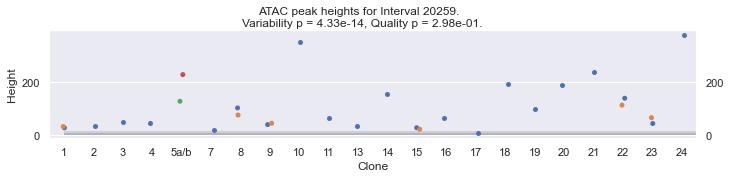

In [173]:
ATAC_vis('Interval_20259')

## Possible panel:  peak variability breakdown...

We plot peak variability, separating differently annotated peaks, and peaks annotated with clonal and non-clonal genes.

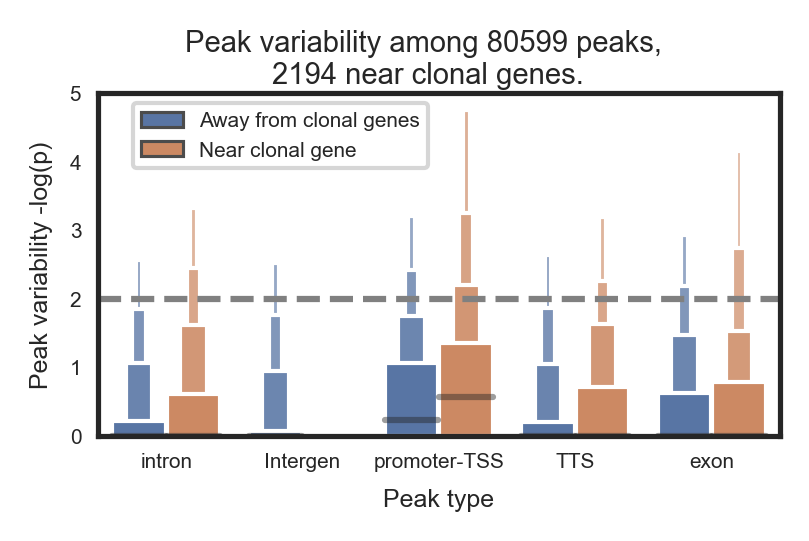

In [175]:
sns.set_style("white")

fig, ax = plt.subplots(1,1,figsize=(2.7,1.8), dpi=300)
setfontsize()


data = pd.DataFrame(index = ATAC_p.index)
data['Peak variability -log(p)'] = -np.log10(ATAC_p)
data['Peak type'] = peak_meta['itype']
data['Near clonal gene'] = peak_meta.in_gene.isin(genes_sig_9855)

sns.boxenplot(x = 'Peak type', y='Peak variability -log(p)', hue = 'Near clonal gene', 
              showfliers=False, data=data, ax=ax)
plt.suptitle('Peak variability among {} peaks, \n'
             '{} near clonal genes.'.format(len(data), data['Near clonal gene'].sum()), y=1.02)

leg = ax.get_legend()
leg.set_title('')
# replace labels
new_labels = ['Away from clonal genes', 'Near clonal gene']
for t, l in zip(leg.texts, new_labels): t.set_text(l)

leg.set_bbox_to_anchor((0,1,0.5,0))

plt.ylim(0,5)
ax.axhline(2, linestyle='--', color='gray')
ax.tick_params(axis='both', which='major', pad=-2)

set_size(fig, (2.7, 1.8))
plt.savefig("Figure4_panels/Peakvar_near_Geneclonal.pdf", bbox_inches='tight')

plt.show()

This is a version not for publication :)

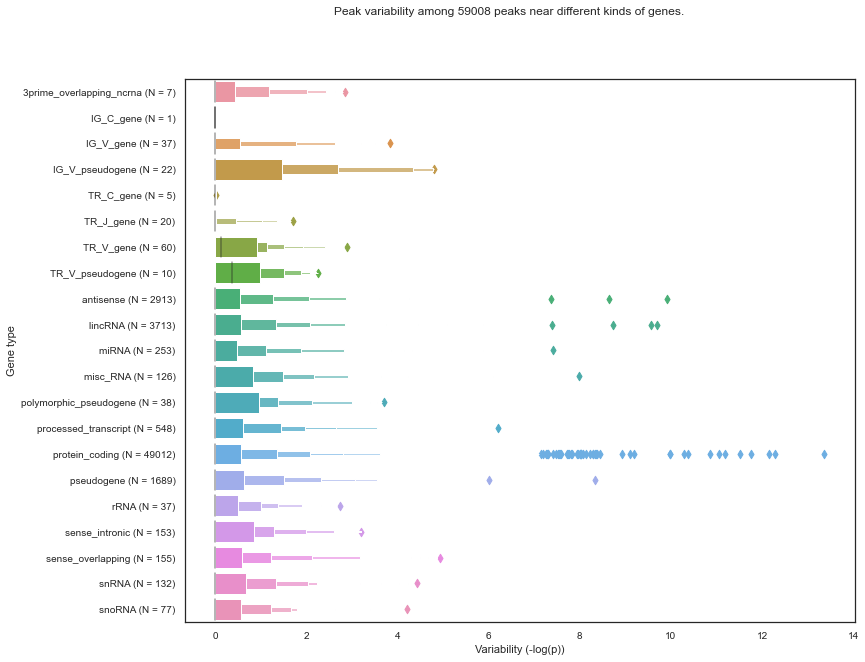

In [176]:
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR') # Annoying matplotlib bug.  

desetfontsize()
gene_biotypes = gene_metadata.gene_biotype.unique()
gene_biotypes.sort()
gbt = gene_metadata.gene_biotype.copy()
gbt = gbt[~gbt.index.duplicated(keep='first')]
pgb = peak_meta.in_gene.map(gbt).dropna()
data = pd.DataFrame(index = pgb.index)
data['Variability (-log(p))'] = -np.log10(ATAC_p.loc[data.index])
data['Gene type'] = pgb
fig, ax = plt.subplots(figsize = (12,10))
sns.boxenplot(x='Variability (-log(p))', y = 'Gene type', data=data, order = data['Gene type'].values.sort(), ax=ax)
yl = [ax.get_yticklabels()[j].get_text() for j in range(len(data['Gene type'].unique()))]
yl = [label + ' (N = {})'.format(pgb.value_counts()[label]) for label in yl]
ax.set_yticklabels(yl)
plt.suptitle('Peak variability among {} peaks near different kinds of genes.'.format(len(data)))
plt.show()

# Analysis of ATAC peaks and nearby genes

This is where the meat is, looking at peaks near certain genes (and sometimes the other way around).

##  Find peaks near a gene, genes near a peak.

Recall that our peak metadata has location information.

In [144]:
peak_meta.head()

chr      start        end          mid         itype  \
PeakID                                                                
Interval_77062   9  115079369  115080094  115079731.5        intron   
Interval_18293  12  117543772  117544007  117543889.5        intron   
Interval_51938   3  156852601  156852899  156852750.0      Intergen   
Interval_33832  19    1671931    1672563    1672247.0      Intergen   
Interval_13433  11   82996620   82997741   82997180.5  promoter-TSS   

                        in_gene  
PeakID                           
Interval_77062  ENSG00000119314  
Interval_18293  ENSG00000258285  
Interval_51938             None  
Interval_33832             None  
Interval_13433  ENSG00000137500

The following function returns the peaks near a given gene.  Here "near" refers to an adjustable window size, with a bit of room on either side to accommodate peak-width.  We use the TSSUp method, meaning that we include peaks that are within 50000kb *upstream* of the gene TSS, and peaks within the gene length (up to tolerance).

In [145]:
def peaks_near(gene, pm = peak_meta, window=50000, tol = 5000.0, method='TSSUp'):
    if gene[:4] == 'ENSG':
        gn = gene
    else:
        if '!' in gene:
            gn = gene.split('!')[0]
            gn = gene_names[gene_names == gn].index[0]
        else:
            gn = gene_names[gene_names == gene].index[0]
    gn_info = gene_locs.loc[gn]
    p_df = pm[pm['chr'] == gn_info.chr]
    dist_peak_TSS = gn_info['dir']*(gn_info.TSS - p_df.mid)
    if method == 'TSSCenter':
        p_range = abs(dist_peak_TSS) < window
    elif method == 'TSSUp':
        up_range = (dist_peak_TSS < window) & (dist_peak_TSS >= -tol)
        in_range = (p_df.mid > gn_info['start'] - tol) & (p_df.mid < gn_info['end'] + tol)
        p_range = up_range | in_range
    else:
        print('Method unknown.')
        return None
    p_df = p_df[p_range]
    return p_df.index

We might want to find peaks within a window around a gene too.

In [146]:
def genes_near(peak, window=50000):
    if peak[:8] == 'Interval':
        pk = peak
    else:
        pk = 'Interval_'+peak # No need to enter Interval_ in input.
    pk_info = peak_meta.loc[pk]
    g_df = gene_locs[gene_locs['chr'] == pk_info.chr]
    g_df = g_df[np.abs(g_df.start + g_df.end - 2*pk_info['mid']) < window]
    return g_df.index

We create a data frame listing all peaks near all genes.  We use a window that includes the entire length of the gene, plus 50000bp upstream.  This will take a minute or two to create.  

In [147]:
pn_df = pd.DataFrame(index=gene_locs.index)
pn_df['open'] = gene_locs['start'].copy()
pn_df['close'] = gene_locs['end'].copy()
pn_df['chr'] = gene_locs['chr'].copy()
pn_df['open'] = pn_df['open'] - 25000*(gene_locs['dir']+1)  # dir = 1 yields start - 50000.  dir=-1 yields start.
pn_df['close'] = pn_df['close'] - 25000*(gene_locs['dir']-1) # dir = -1 yields end + 50000.  dir = 1 yields end.
pn_df['peaklist'] = None
for chrome in pn_df['chr'].unique():
    pk_df = peak_meta[(peak_meta['chr'] == chrome)]
    for gene in pn_df[pn_df['chr'] == chrome].index:
        png = pn_df.loc[gene]
        if len(pk_df) > 0:
            pns = (pk_df[(pk_df['mid'] >= png['open']) & (pk_df['mid'] <= png['close'])]).index
            if len(pns) > 0:
                pn_df.at[gene, 'peaklist'] = sorted(list(pns))

pn_df_pl = pn_df['peaklist'].copy()
pn_df_pl[pn_df_pl.isnull()] = pn_df_pl[pn_df_pl.isnull()].apply(lambda x : [])
pn_df['peaklist'] = pn_df_pl

pn_df.head()

open     close          chr peaklist
ensembl_gene_id                                          
ENSG00000261657  66069285  66465398  HG991_PATCH       []
ENSG00000223116  23551994  23602136           13       []
ENSG00000233440  23658313  23708703           13       []
ENSG00000207157  23726725  23776825           13       []
ENSG00000229483  23743974  23794736           13       []

Here we tally the *number* of peaks near each gene.

In [148]:
num_peaksnear = pn_df.peaklist.explode().groupby('ensembl_gene_id').count()
num_peaksnear.describe()

count    63677.000000
mean         2.897326
std          3.655764
min          0.000000
25%          0.000000
50%          2.000000
75%          4.000000
max         65.000000
Name: peaklist, dtype: float64

On average, each gene has about 2.9 peaks nearby, but some genes have far more (up to 65!) peaks nearby.  Here we plot the histogram, for the number of nearby peaks, on a log-scale.  Note that there are hundreds of genes with 10-20 nearby peaks.  And thousands with 5-10 nearby peaks.  We'll include something publication ready later.

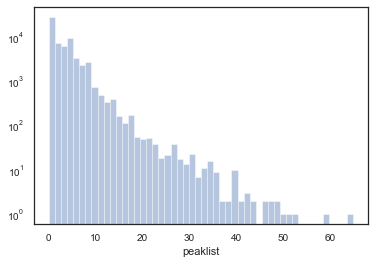

In [177]:
desetfontsize()
sns.distplot(num_peaksnear, kde=False)
plt.yscale('log')

## Gene/ATAC clonal means and variability

To start to look at RNA/ATAC correlations, we create some dataframes with clonal averages.

In [151]:
AM = ATACS_logdf.T # log-normalized ATAC matrix.
AM_clonal = AM.groupby(meta_df.Clone_ID).mean() # Use log-normalized peak height.
AM_clonal = AM_clonal.T.reindex(qual_peaks)
AM_clonal = AM_clonal.loc[(AM_clonal.max(axis=1) >= np.log1p(10))].T # Only keep peaks where max clonal height >10.

In [152]:
EM_clonal.head()

ENSG00000000419  ENSG00000000457  ENSG00000000460  ENSG00000001036  \
Clone_ID                                                                       
P1_A03           1.967390         1.138069         0.562371         0.000000   
P1_A05           4.969397         0.000000         0.000000         1.614030   
P1_A08           3.276843         0.000000         0.000000         4.047299   
P1_A12           4.201513         1.241266         0.000000         0.000000   
P1_B10           4.692374         1.542909         0.000000         5.395082   

          ENSG00000001084  ENSG00000001167  ENSG00000001461  ENSG00000001497  \
Clone_ID                                                                       
P1_A03           0.000000         0.565960         5.492732         1.987396   
P1_A05           1.261104         3.517510         5.859394         4.204581   
P1_A08           1.548509         0.000000         2.323102         0.000000   
P1_A12           1.727179         3.632520         5.687729         4.368161   
P1_B10           3.312645         3.392121         4.221664         3.396654   

          ENSG00000001561  ENSG00000001629  ...  ENSG00000273226  \
Clone_ID                                    ...                    
P1_A03           1.942282         3.354769  ...         0.000000   
P1_A05           0.286494         1.672892  ...         1.314825   
P1_A08           3.183625         0.000000  ...         1.667963   
P1_A12           1.677616         3.551127  ...         3.140424   
P1_B10           2.022591         1.674071  ...         1.519317   

          ENSG00000273247  ENSG00000273271  ENSG00000273319  ENSG00000273338  \
Clone_ID                                                                       
P1_A03           1.133774         1.172654         3.471863         3.041229   
P1_A05           2.008793         0.000000         5.577959         2.964174   
P1_A08           0.120871         0.000000         3.096394         2.179842   
P1_A12           1.775588         0.000000         5.234832         2.541891   
P1_B10           1.350074         0.339037         3.051119         5.539101   

          ENSG00000273344  ENSG00000273356  ENSG00000273437  ENSG00000273445  \
Clone_ID                                                                       
P1_A03           2.270048         1.767338         1.651205         2.026470   
P1_A05           1.414876         0.000000         1.790296         0.000000   
P1_A08           0.000000         1.687515         1.958868         1.159195   
P1_A12           2.227474         1.025735         0.000000         0.000000   
P1_B10           0.000000         1.215797         0.000000         2.332122   

          ENSG00000273451  
Clone_ID                   
P1_A03           1.586085  
P1_A05           0.000000  
P1_A08           0.000000  
P1_A12           1.602386  
P1_B10           1.292923  

[5 rows x 9587 columns]

In [153]:
AM_clonal.head()

PeakID    Interval_17997  Interval_79477  Interval_37795  Interval_69270  \
Clone_ID                                                                   
P1_A03          1.106543        5.729414        4.996538        6.822516   
P1_A05          0.913780        5.498211        2.656233        6.578717   
P1_A08          2.440110        5.271578        5.186447        5.871568   
P1_A12          3.742252        5.470471        4.435437        5.825792   
P1_B10          3.181148        5.272820        4.099344        7.082200   

PeakID    Interval_33952  Interval_12664  Interval_7004  Interval_52606  \
Clone_ID                                                                  
P1_A03          6.997750        5.807709       4.340860        7.655203   
P1_A05          6.889579        4.827983       3.642895        7.604298   
P1_A08          6.990555        5.758143       3.593005        8.105718   
P1_A12          7.100190        5.401707       4.130083        7.752388   
P1_B10          6.572183        4.655974       3.555863        8.047830   

PeakID    Interval_38759  Interval_23304  ...  Interval_60864  Interval_30052  \
Clone_ID                                  ...                                   
P1_A03          7.522702        2.304040  ...        3.901909        5.038863   
P1_A05          7.655798        2.845555  ...        3.162818        5.380690   
P1_A08          7.511754        2.933620  ...        3.593005        4.999451   
P1_A12          7.496199        1.615281  ...        3.210210        4.798479   
P1_B10          7.244558        3.555863  ...        4.802243        5.845290   

PeakID    Interval_56513  Interval_59616  Interval_22353  Interval_52  \
Clone_ID                                                                
P1_A03          6.024774        8.202164        5.058056     2.637994   
P1_A05          5.779325        8.080084        4.353849     2.656233   
P1_A08          6.484406        8.445041        4.531953     0.000000   
P1_A12          6.194362        8.288269        4.290824     4.130083   
P1_B10          5.703539        8.339011        4.493184     2.673600   

PeakID    Interval_25224  Interval_63948  Interval_9874  Interval_23945  
Clone_ID                                                                 
P1_A03          5.666753        4.654731       2.633390        4.266406  
P1_A05          5.779325        4.997253       3.012891        4.002484  
P1_A08          6.121345        4.896001       1.684108        4.043862  
P1_A12          5.716794        5.329502       2.358235        4.290824  
P1_B10          5.460793        5.056634       3.555863        4.099344  

[5 rows x 68162 columns]

In [154]:
len(AM_clonal) == len(EM_clonal) # Hope to use same number of clones!

True

In [155]:
A_samples = AM.index
AE_clones = [clone for clone in AM_clonal.index if clone in EM_clonal.index]
print('{} clones in ATAC data and expression matrix.'.format(len(AE_clones)))

23 clones in ATAC data and expression matrix.


We might have to convert names, using the following cloneconvert table.

In [156]:
cloneconvert = meta_df.groupby('Clone ID').first()['Clone_ID_InVitro'].apply(lambda s : str(s)[6:8])
cloneconvert.head()

Clone ID
Negative                          
None                              
P1_A03                          01
P1_A03_ATAC_wellA1_rep1_1000    01
P1_A03_ATAC_wellA2_rep2_1000    01
Name: Clone_ID_InVitro, dtype: object

Here's a little visualization for exploration (not publication).

In [178]:
def r2(x, y):
    return ss.pearsonr(x, y)[0] ** 2
    
def AE_reg(gn, peak, return_data = False, annotate = True):
    desetfontsize()
    fig,ax = plt.subplots(figsize=(8,6))
    gene = get_ensg(gn)
    data = pd.DataFrame(index = AE_clones)
    data['x'] = EM_clonal[gene]
    data['y'] = AM_clonal[peak]
    goodxindex = data['x'].dropna().index
    goodyindex = data['y'].dropna().index
    goodindex = [i for i in goodxindex if i in goodyindex]
    data = data.loc[goodindex]
    Rsq = r2(data['x'], data['y'])
    data['Replicate'] = cloneconvert[data.index].astype(int)
    rep_clones = data[data['Replicate'].isin([1,15,22,23,8,9])]
    nonrep_clones = data[~data['Replicate'].isin([1,15,22,23,8,9])]
    
    sns.regplot('x', 'y', data=data)
    ax.set_xlabel('Gene expression (log(TPM))')
    ax.set_ylabel('Peak height (log-normalized)')
    rect = Rectangle((0,0),data['x'].max(),np.log1p(15),linewidth=0,edgecolor=None,facecolor=(0.5,0.5,0.5,0.25))
    rectb = Rectangle((0,0),data['x'].max(),np.log1p(10),linewidth=0,edgecolor=None,facecolor=(0.5,0.5,0.5,0.25))
    ax.add_patch(rect)
    ax.add_patch(rectb)
    
    if annotate:
        offset = (data['x'].max() - data['x'].min())*0.02
        for line in range(0,data.shape[0]):
            ax.text(data.x[line]+offset, data.y[line], data.Replicate[line], 
                    horizontalalignment='left', verticalalignment='center', size='medium', color='black')
    pltitle = 'Height of {} vs expression of {}. \n {} clones, $R^2 = {:1.3f}$'.format(
        peak.replace('_',' '), gn, len(data), Rsq)
    plt.suptitle(pltitle)
    plt.show()
    if return_data:
        return data

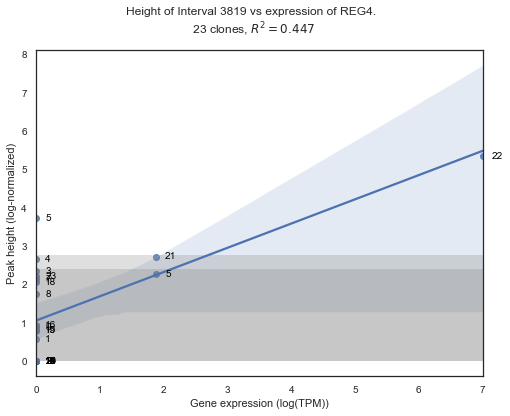

In [180]:
AE_reg('REG4', 'Interval_3819')

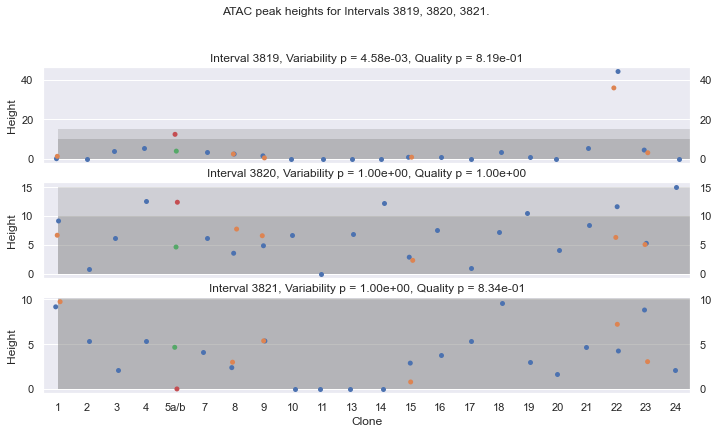

In [181]:
ATAC_vis(peaks_near('REG4'))

## Gene/peak correlations, chromosome scale

For every gene, we compute the (Pearson) correlations of gene expression with peak heights -- for all peaks on the same chromosome.  This will take a little while to compute.. but not too long :)

In [186]:
peak_chromes = sorted(peak_meta.chr.unique())
print('There are {} chromosomes represented among the ATAC intervals: {}'.format(
    len(peak_chromes), ', '.join(peak_chromes)))

There are 24 chromosomes represented among the ATAC intervals: 1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 2, 20, 21, 22, 3, 4, 5, 6, 7, 8, 9, X, Y


In [187]:
gene_chromes = sorted(gene_locs.chr.unique())
print('There are {} chromosomes represented among the gene metadata.'.format(len(gene_chromes)))

There are 265 chromosomes represented among the gene metadata.


In [188]:
def pg_sort(df):
    sort_df = df.sort_index()
    cols = list(df.columns)
    cols = gene_locs_name.loc[cols].sort_values('TSS').index
    sort_df = sort_df[cols]
    return sort_df

def pg_corr(chrome, AMc = AM_clonal, EMc = EM_clonal, trunc=10000, method='pearson'):
    chr_peaks = peak_meta.loc[AMc.columns][peak_meta.chr == chrome].index
    chr_genes = gene_locs[gene_locs.chr == chrome].index
    chr_genes = [gene for gene in chr_genes if gene in E_genes] # Only genes with expression data
    print('Making corr. matrix for chromosome {} with {} peaks and {} genes.'.format(
        chrome, len(chr_peaks), len(chr_genes)))
    #AE_clones = [clone for clone in AM_clonal.index if clone in EM_clonal.index]
    A = AMc[chr_peaks[:trunc]]
    E = EMc[chr_genes[:trunc]]
    if method == 'spearman':
        A = A.rank()
        E = E.rank()
    Az = (A - A.mean())
    Ez = (E - E.mean())
    C = Az.T.dot(Ez).div(len(A)).div(Ez.std(ddof=0)).div(Az.std(ddof=0), axis=0)
    return C.sort_index()

We make the correlation matrices... it might take a minute.

In [189]:
pg_corr_dfs = {}
for chrome in peak_chromes:
    pg_corr_dfs[chrome] = pg_corr(chrome)

<ipython-input-188-87d68aa8fbd9>:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  chr_peaks = peak_meta.loc[AMc.columns][peak_meta.chr == chrome].index


Making corr. matrix for chromosome 1 with 6343 peaks and 1012 genes.
Making corr. matrix for chromosome 10 with 3110 peaks and 368 genes.
Making corr. matrix for chromosome 11 with 3325 peaks and 528 genes.
Making corr. matrix for chromosome 12 with 3433 peaks and 541 genes.
Making corr. matrix for chromosome 13 with 1687 peaks and 174 genes.
Making corr. matrix for chromosome 14 with 2204 peaks and 325 genes.
Making corr. matrix for chromosome 15 with 2139 peaks and 314 genes.
Making corr. matrix for chromosome 16 with 2364 peaks and 425 genes.
Making corr. matrix for chromosome 17 with 3143 peaks and 590 genes.
Making corr. matrix for chromosome 18 with 1306 peaks and 139 genes.
Making corr. matrix for chromosome 19 with 2658 peaks and 618 genes.
Making corr. matrix for chromosome 2 with 5527 peaks and 670 genes.
Making corr. matrix for chromosome 20 with 1707 peaks and 241 genes.
Making corr. matrix for chromosome 21 with 817 peaks and 94 genes.
Making corr. matrix for chromosome 22

We make a permuted version, to see what R^2 values might arise by chance alone.

In [190]:
pg_corr_shuff_dfs = {}
for chrome in peak_chromes:
    pg_corr_shuff_dfs[chrome] = pg_corr(chrome, EMc=EM_clonal_shuff)

<ipython-input-188-87d68aa8fbd9>:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  chr_peaks = peak_meta.loc[AMc.columns][peak_meta.chr == chrome].index


Making corr. matrix for chromosome 1 with 6343 peaks and 1012 genes.
Making corr. matrix for chromosome 10 with 3110 peaks and 368 genes.
Making corr. matrix for chromosome 11 with 3325 peaks and 528 genes.
Making corr. matrix for chromosome 12 with 3433 peaks and 541 genes.
Making corr. matrix for chromosome 13 with 1687 peaks and 174 genes.
Making corr. matrix for chromosome 14 with 2204 peaks and 325 genes.
Making corr. matrix for chromosome 15 with 2139 peaks and 314 genes.
Making corr. matrix for chromosome 16 with 2364 peaks and 425 genes.
Making corr. matrix for chromosome 17 with 3143 peaks and 590 genes.
Making corr. matrix for chromosome 18 with 1306 peaks and 139 genes.
Making corr. matrix for chromosome 19 with 2658 peaks and 618 genes.
Making corr. matrix for chromosome 2 with 5527 peaks and 670 genes.
Making corr. matrix for chromosome 20 with 1707 peaks and 241 genes.
Making corr. matrix for chromosome 21 with 817 peaks and 94 genes.
Making corr. matrix for chromosome 22

In [191]:
random_corrs = {chrome : (pg_corr_shuff_dfs[chrome]**2).values.flatten() for chrome in peak_chromes}
random_corrs['1']

array([0.01572689, 0.13501254, 0.07535529, ..., 0.18097384, 0.09806048,
       0.00153054])

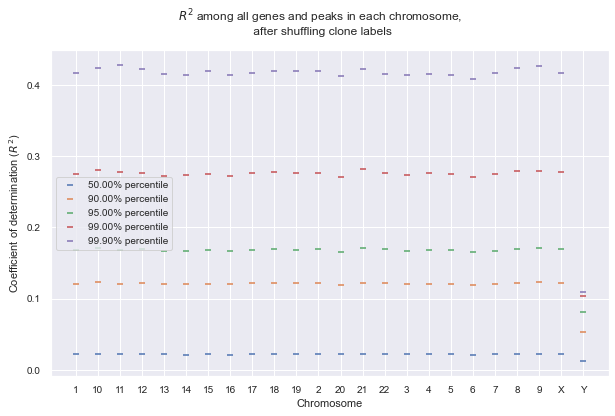

In [192]:
#random_corr_quants = pd.DataFrame(index = peak_chromes, columns = quantiles)
desetfontsize()
fig,ax = plt.subplots(figsize = (10,6))
quantiles = [0.5, 0.9, 0.95, 0.99, 0.999]
for q in quantiles:
    random_corr_quants = {chrome : pd.Series(random_corrs[chrome]).quantile(q) for chrome in peak_chromes}
    ax.scatter(random_corr_quants.keys(), random_corr_quants.values(), 
               marker='_', label='{:1.2%} percentile'.format(q))

ax.set_xlabel('Chromosome')
ax.set_ylabel('Coefficient of determination ($R^2$)')
plt.suptitle('$R^2$ among all genes and peaks in each chromosome, \n after shuffling clone labels')
plt.legend()
plt.show()

We can see that $R^2 > 0.4$ arises by chance, in about 1/1000 of gene/peak pairs.  This is true across chromosomes, except for the Y-chromosome.

In [193]:
def peak_corr_with(gn, shuffle=False):
    '''
    Input:  a gene.
    Output:  All peaks on the same chromosome as the gene, with their correlations to that gene.
    '''
    gene = get_ensg(gn)
    chrome = gene_locs.chr[gene]
    if chrome in pg_corr_dfs.keys():
        if shuffle:
            return pg_corr_shuff_dfs[gene_locs.chr[gene]][gene]
        else:
            return pg_corr_dfs[gene_locs.chr[gene]][gene]
    else:
        return []

We can use this precomputed data to explore a bit.

In [195]:
peak_corr_with('CTLA4') # All correlations to peaks on the same chromosome.

PeakID
Interval_36634   -0.139261
Interval_36635   -0.298580
Interval_36637    0.378685
Interval_36638    0.321247
Interval_36639   -0.271177
                    ...   
Interval_43312    0.151948
Interval_43313    0.129976
Interval_43314    0.036121
Interval_43315   -0.419912
Interval_43316   -0.105167
Name: ENSG00000163599, Length: 5527, dtype: float64

In [196]:
pcw = peak_corr_with('TALDO1')
pcw[(pcw > 0.2) & (ATAC_p < 0.01)] # All peaks with corr > 0.5 with TALDO1.

PeakID
Interval_10945    0.224443
Interval_11498    0.249087
Interval_11512    0.271666
Interval_11522    0.318197
Interval_11959    0.250884
Interval_11989    0.215118
Interval_12171    0.319407
Interval_13152    0.240270
Interval_14257    0.261751
Interval_14503    0.233568
Interval_14511    0.207177
Interval_14592    0.281370
Interval_14601    0.275889
Interval_14663    0.248338
Interval_14769    0.297497
Interval_14798    0.416020
Interval_14805    0.208641
Name: ENSG00000177156, dtype: float64

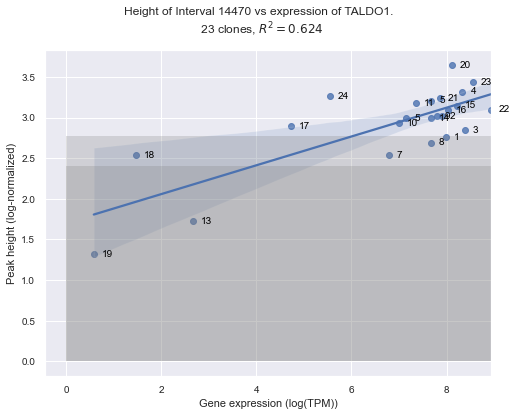

In [197]:
AE_reg('TALDO1','Interval_14470')

## Panel:  Distribution of R^2 near TSS of all genes

Now we look at the location of correlated peaks, relative to the TSS.  For each gene, we look at the peaks within a 500kb window.  We divide the window into 200 bins, and look at the $R^2$ statistic for all peaks within each bin.  Then we add up these statistics for *all* genes.  In this way, we see a concentration of $R^2$ near the TSS of *all* genes.

In [198]:
genelist = EM.columns # All genes in our expression matrix.
TSS_list = gene_locs.loc[genelist]['TSS'] # Location of TSS's

# Make windows around each gene.
window_width = 500000 # Distance from TSS.
num_bins = 200

window = (window_width*2/num_bins) * np.arange(-num_bins // 2, (num_bins // 2) + 1)
window_df = pd.DataFrame(np.add.outer(TSS_list.values, window), index=TSS_list.index, columns=window)
window_df.head()

# Make bins
bins_rel = list(pd.cut(window_df.columns, bins=num_bins)[1:])

# Initialize dataframe.
pcw_wins = pd.DataFrame(index=window_df.index, columns=bins_rel, dtype=np.float)

# Add up R^2 values within each bin around each gene.
for gene in window_df.index:
    gene_win = window_df.loc[gene]
    pcw = peak_corr_with(gene)
    if len(pcw) > 0:
        pmids = peak_meta['mid'].loc[pcw.index] # Midpoints of peaks on same chromosome.
        pcw = pcw[(gene_win[-500000] <= pmids) & (gene_win[500000] >= pmids) ]
        pcw = pcw**2 # Use R^2 values.
        pmids = pmids.loc[pcw.index]
        groups = pcw.groupby(pd.cut(pmids, gene_win.values))
        pcw_wins.loc[gene] = groups.sum().values

In [199]:
genes_sorted = pcw_wins.sum(axis=1).sort_values(ascending=False).index
pcw_wins = pcw_wins.reindex(genes_sorted)
pcw_wins

(-501000.0, -495000.0]  (-495000.0, -490000.0]  \
ENSG00000134539                0.000156                0.003591   
ENSG00000187866                0.000000                0.000000   
ENSG00000170638                0.000000                0.000000   
ENSG00000198502                0.000000                0.153705   
ENSG00000183625                0.103730                0.000000   
...                                 ...                     ...   
ENSG00000210194                     NaN                     NaN   
ENSG00000210049                     NaN                     NaN   
ENSG00000210195                     NaN                     NaN   
ENSG00000210196                     NaN                     NaN   
ENSG00000198786                     NaN                     NaN   

                 (-490000.0, -485000.0]  (-485000.0, -480000.0]  \
ENSG00000134539                0.004129                0.106279   
ENSG00000187866                0.000000                0.000000   
ENSG00000170638                0.000000                0.000000   
ENSG00000198502                0.000000                0.159158   
ENSG00000183625                0.071544                0.000000   
...                                 ...                     ...   
ENSG00000210194                     NaN                     NaN   
ENSG00000210049                     NaN                     NaN   
ENSG00000210195                     NaN                     NaN   
ENSG00000210196                     NaN                     NaN   
ENSG00000198786                     NaN                     NaN   

                 (-480000.0, -475000.0]  (-475000.0, -470000.0]  \
ENSG00000134539                0.161741                0.013498   
ENSG00000187866                0.000000                0.000000   
ENSG00000170638                0.000000                0.000000   
ENSG00000198502                0.000000                0.000000   
ENSG00000183625                0.000000                0.017369   
...                                 ...                     ...   
ENSG00000210194                     NaN                     NaN   
ENSG00000210049                     NaN                     NaN   
ENSG00000210195                     NaN                     NaN   
ENSG00000210196                     NaN                     NaN   
ENSG00000198786                     NaN                     NaN   

                 (-470000.0, -465000.0]  (-465000.0, -460000.0]  \
ENSG00000134539                0.029644                0.050133   
ENSG00000187866                0.000000                0.000000   
ENSG00000170638                0.019482                0.005591   
ENSG00000198502                0.000000                0.000000   
ENSG00000183625                0.052300                0.000000   
...                                 ...                     ...   
ENSG00000210194                     NaN                     NaN   
ENSG00000210049                     NaN                     NaN   
ENSG00000210195                     NaN                     NaN   
ENSG00000210196                     NaN                     NaN   
ENSG00000198786                     NaN                     NaN   

                 (-460000.0, -455000.0]  (-455000.0, -450000.0]  ...  \
ENSG00000134539                0.000000                     0.0  ...   
ENSG00000187866                0.000000                     0.0  ...   
ENSG00000170638                0.000000                     0.0  ...   
ENSG00000198502                0.248237                     0.0  ...   
ENSG00000183625                0.000000                     0.0  ...   
...                                 ...                     ...  ...   
ENSG00000210194                     NaN                     NaN  ...   
ENSG00000210049                     NaN                     NaN  ...   
ENSG00000210195                     NaN                     NaN  ...   
ENSG00000210196                     NaN                     NaN  ...   
ENSG0

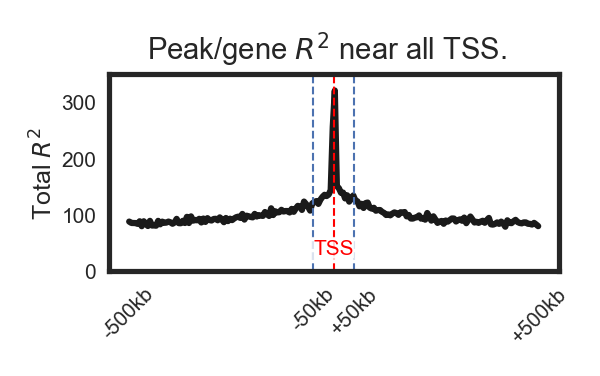

In [203]:
sns.set_style("white")

fig, ax = plt.subplots(1,1,figsize=(2.0,1.25), dpi=300)
setfontsize()

sns.lineplot(pcw_wins_sum.index, pcw_wins_sum.values, color='k')
ax.axvline(-50000, linewidth=0.5, linestyle='--')
ax.axvline(50000, linewidth=0.5, linestyle='--')
ax.axvline(0,linewidth=0.5, linestyle='--', color='red')
ax.text(0,30,'TSS', color='red', ha='center', bbox=dict(facecolor='white', alpha=0.8, pad=0))
plt.ylim(0,350)

ax.set_xticks([-500000,-50000,0,50000,500000])
ax.set_xticklabels(['-500kb','-50kb','','+50kb','+500kb'], rotation=45)

ax.set_ylabel('Total $R^2$')
ax.tick_params(axis='both', which='major', pad=-3)
ax.yaxis.labelpad = 1

plt.suptitle('Peak/gene $R^2$ near all TSS.', y=1.05)
set_size(fig, (2.0, 1.25))

plt.savefig("Figure4_panels/LocR2TSS.pdf", bbox_inches='tight')

plt.show()

## Exploration near a given gene

Now we give an exploratory tool for looking at peak correlations in expanding windows around a given gene.

In [208]:
def near_corr_vis(gn):
    gene = get_ensg(gn)
    desetfontsize()
    fig,ax = plt.subplots(3,1,figsize=(12,10), sharey=True)
    pcw = peak_corr_with(gene)**2
    x_ser = peak_meta.loc[pcw.index]['mid']
    y_ser = pcw
    pmi = peak_meta.loc[pcw.index]['itype']
    pmg = peak_meta.loc[pcw.index]['in_gene']
    c_ser = -np.log10(ATAC_p[pcw.index])
    #c_ser = ((pmi == 'promoter-TSS') & (pmg == gene))
    #c_ser = c_ser.replace({True: 'red', False:'blue'})
    TSSloc = gene_locs.loc[gene,'TSS']
    for j in range(3):
        im = ax[j].scatter(x_ser, y_ser, c=c_ser, vmin=0, vmax=3.0, cmap='OrRd', s=25.0-10*j)
        ax[j].axvline(TSSloc, color='gray')
        ax[j].set_xlim(TSSloc - (10000 * 10**(j+1)), TSSloc + (10000 * 10**(j+1)))
        ax[j].set_xticks([TSSloc - (5000 * 10**(j+1)), TSSloc, TSSloc + (5000 * 10**(j+1))])
        ax[j].set_xticklabels(['TSS - {:,}'.format(5000 * 10**(j+1)), 'TSS', 'TSS + {:,}'.format(5000 * 10**(j+1))])
        fig.colorbar(im, ax=ax[j])
    plt.ylim(0,1)
    plt.suptitle('Correlation (Pearson R^2), of peaks near {}. \n'
                 'Color = clonal significance of peak-height variation.'.format(gn))
    plt.show()

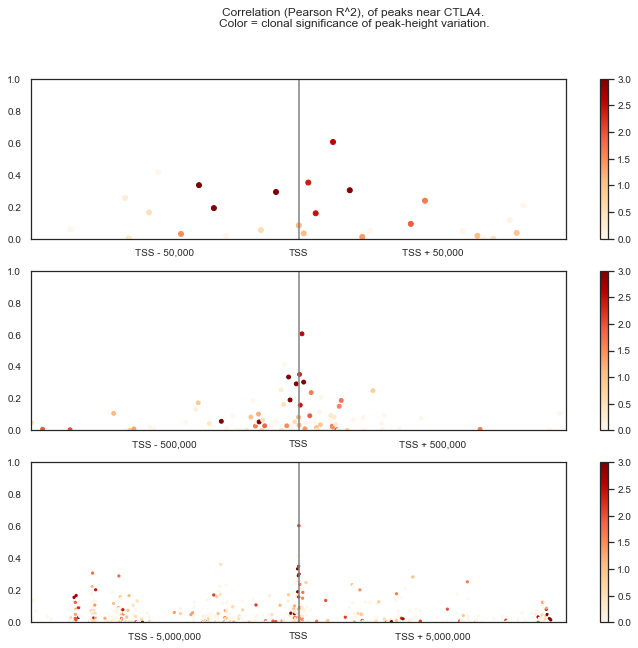

In [209]:
near_corr_vis('CTLA4')

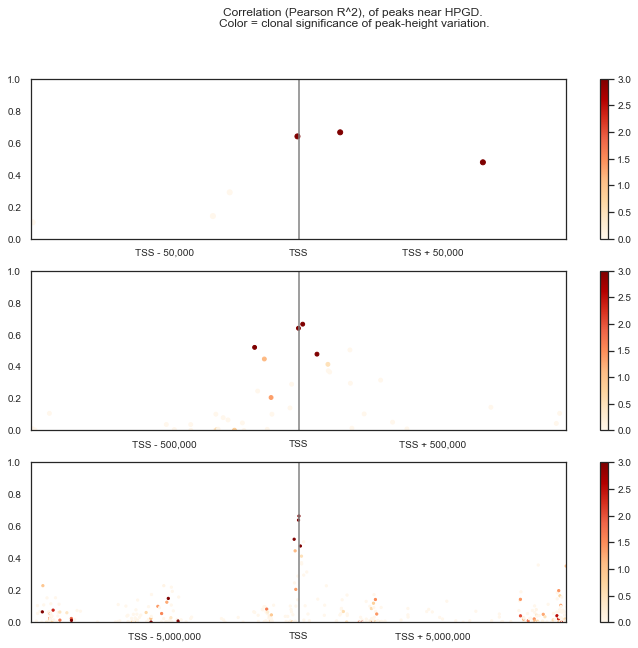

In [210]:
near_corr_vis('HPGD')

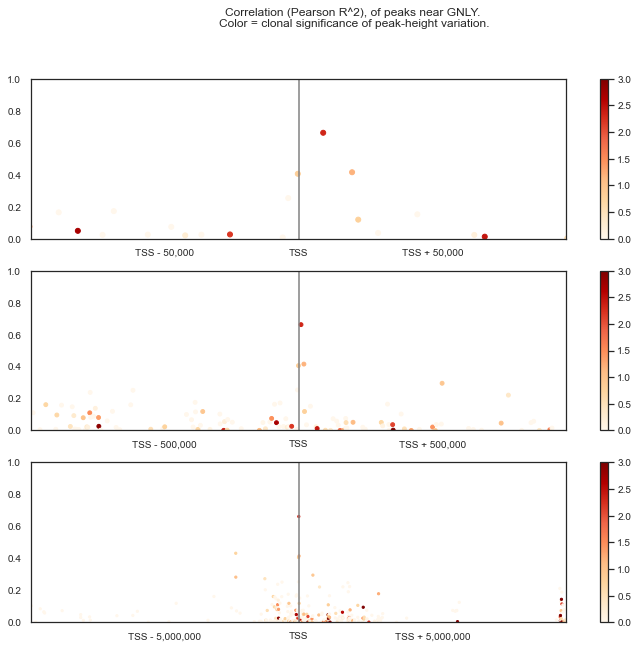

In [211]:
near_corr_vis('GNLY')

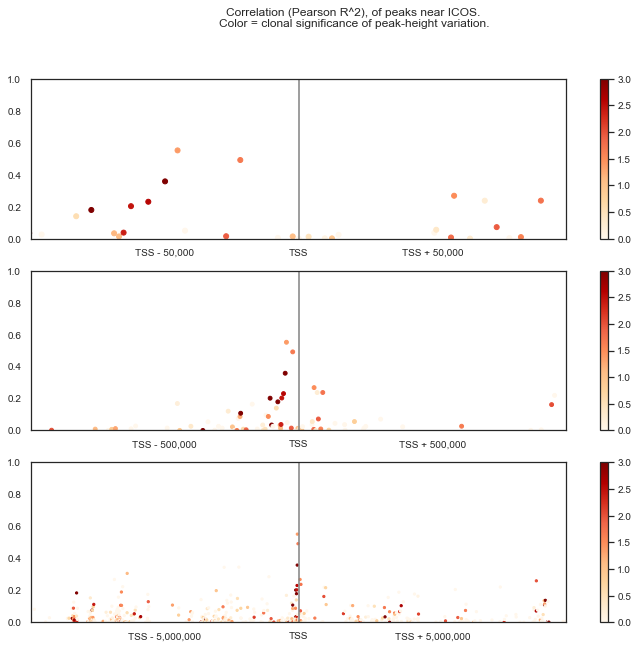

In [212]:
near_corr_vis('ICOS')

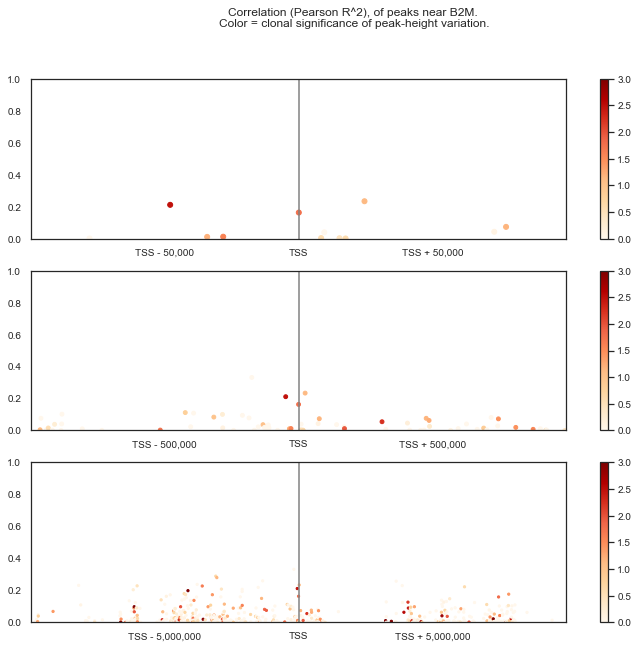

In [213]:
near_corr_vis('B2M')

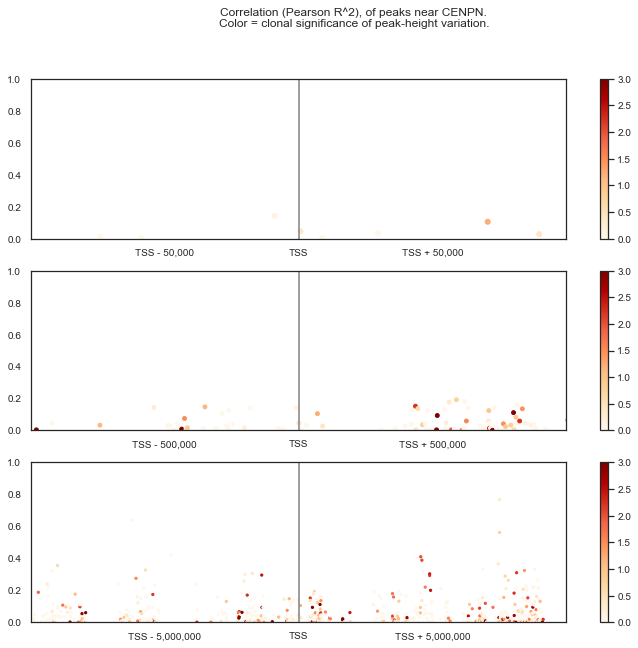

In [214]:
near_corr_vis('CENPN')

## Preparing for large-scale analysis.

We precompute some things, for large-scale analysis of gene/peak correlations.  

The following function is used to convert a list of nearby peaks into a "hot-one" representation, for downstream use.

In [215]:
def pir_fast(df, lcol):
    v = df[lcol].values
    l = [len(x) for x in v.tolist()]
    f, u = pd.factorize(np.concatenate(v))
    n, m = len(v), u.size
    i = np.arange(n).repeat(l)

    dummies = pd.DataFrame(
        np.bincount(i * m + f, minlength=n * m).reshape(n, m),
        df.index, u
    )
    return dummies
    #return df.drop(lcol, 1).join(dummies)

In [216]:
pir_fast(pn_df[pn_df['chr'] == '10'], 'peaklist').T.head()

ensembl_gene_id  ENSG00000182077  ENSG00000128802  ENSG00000107623  \
Interval_8165                  1                0                0   
Interval_8594                  0                1                1   
Interval_8595                  0                1                1   
Interval_8596                  0                0                1   
Interval_8597                  0                0                1   

ensembl_gene_id  ENSG00000099246  ENSG00000095564  ENSG00000198879  \
Interval_8165                  0                0                0   
Interval_8594                  0                0                0   
Interval_8595                  0                0                0   
Interval_8596                  0                0                0   
Interval_8597                  0                0                0   

ensembl_gene_id  ENSG00000221164  ENSG00000199201  ENSG00000227382  \
Interval_8165                  0                0                0   
Interval_8594                  0                0                0   
Interval_8595                  0                0                0   
Interval_8596                  0                0                0   
Interval_8597                  0                0                0   

ensembl_gene_id  ENSG00000222197  ...  ENSG00000204682  ENSG00000180592  \
Interval_8165                  0  ...                0                0   
Interval_8594                  0  ...                0                0   
Interval_8595                  0  ...                0                0   
Interval_8596                  0  ...                0                0   
Interval_8597                  0  ...                0                0   

ensembl_gene_id  ENSG00000078403  ENSG00000136770  ENSG00000223601  \
Interval_8165                  0                0                0   
Interval_8594                  0                0                0   
Interval_8595                  0                0                0   
Interval_8596                  0                0                0   
Interval_8597                  0                0                0   

ensembl_gene_id  ENSG00000148444  ENSG00000269897  ENSG00000168283  \
Interval_8165                  0                0                0   
Interval_8594                  0                0                0   
Interval_8595                  0                0                0   
Interval_8596                  0                0                0   
Interval_8597                  0                0                0   

ensembl_gene_id  ENSG00000077327  ENSG00000150867  
Interval_8165                  0                0  
Interval_8594                  0                0  
Interval_8595                  0                0  
Interval_8596                  0                0  
Interval_8597                  0                0  

[5 rows x 2260 columns]

In [217]:
peaks_near('ENSG00000128802') # Should match the 1s in the above dataframe.

Index(['Interval_8594', 'Interval_8595'], dtype='object', name='PeakID')

We use the hot-one representation to make "masks" to consider only peaks within a certain window.

In [218]:
pn_masks = {}
for chrome in peak_chromes:
    mask = pir_fast(pn_df[pn_df['chr'] == chrome], 'peaklist').T
    mask = mask.reindex(pg_corr_dfs[chrome].index)
    pn_masks[chrome] = mask.replace(np.nan, 0)
    #print('Mask made for chromosome {}'.format(chrome))

In [219]:
corr_nears = {}
for chrome in peak_chromes:
    mask = pn_masks[chrome].copy()
    #mask.columns = mask.columns.map(gene_names)
    corrs = pg_corr_dfs[chrome]
    mask = mask[corrs.columns]
    mask = mask.loc[corrs.index]
    corr_nears[chrome] = mask * corrs
    #print('Nearby correlations made for chromosome {}'.format(chrome))

In [220]:
def top_corrs(peak):
    chrome = peak_meta.loc[peak]['chr']
    #print(pg_corr_dfs[chrome])
    corrs = pg_corr_dfs[chrome].loc[peak]
    return (corrs**2).sort_values(ascending=False)

It's now easy to find things like the highest correlated peak near a given gene.

In [222]:
corr_near_max = pd.Series(name='max_R2', dtype=np.float64)
cnm = []
for chrome in peak_chromes:
    cnm.append((corr_nears[chrome]**2).max())
corr_near_max = pd.concat(cnm)
corr_near_max.name = 'max_R2'
corr_near_max.head()

ensembl_gene_id
ENSG00000236624    0.128532
ENSG00000164008    0.076797
ENSG00000131236    0.265146
ENSG00000221643    0.113948
ENSG00000224550    0.000000
Name: max_R2, dtype: float64

# Linked genes

Here we use a strategy from a Science paper (citation needed!) to identify sets of peaks "linked" with a given gene.  The process is outlined below.

1.  Keep only nearby intervals with r>0.04 correlation with gene expression.
2.  Look at peak height of promoter (or sum of peak heights, if >1 promoter) for each gene.
3.  Run LASSO regression, gene expression ~ promoter peak height(s) + other nearby peak heights.
4.  Use this LASSO to "link" a subset of nearby intervals to each gene.
5.  Report on how many DE genes have linked peaks with cross-validated R^2 above threshold (p<0.01).

In [224]:
goodpeak_meta = peak_meta.reindex(AM_clonal.columns)

The following links gene expression to heights of promoters.

In [225]:
def promoter_reg(gn, cutoff=0.04):
    gene = get_ensg(gn)
    plist = goodpeak_meta[goodpeak_meta['in_gene'] == gene]
    plist = plist[plist['itype'] == 'promoter-TSS']
    pcw = peak_corr_with(gene)[plist.index]
    plist = list(pcw[pcw > cutoff].index)
    if len(plist) == 0:
        gp_dict = {}
        gp_dict['promoters'] = plist
        gp_dict['intercept'] = 0
        gp_dict['Rsq'] = 0
        return gp_dict
    
    endog = EM_clonal[gene]
    exog = AM_clonal[plist].loc[endog.index]
    #exog = exog.sum(axis=1)
    model = LinearRegression()
    model.fit(exog, endog)
    coeffs = model.coef_
    intercept = model.intercept_
    gp_dict = {plist[j] : coeffs[j] for j in range(len(plist))}
    gp_dict['promoters'] = plist
    gp_dict['intercept'] = intercept
    gp_dict['Rsq'] = model.score(exog, endog)
    return gp_dict

The following function uses LASSO to find a set of peaks that "best" predict gene expression.  Here there is a penalty for using more peaks, so it's finding peaks that are not only predictive, but suitably independent that the benefit in prediction outweighs the penalty of more peaks.

In [226]:
def genepeak_lasso(gn, window=50000, method='TSSUp', minvar = 0.0, 
                   cutoff = 0.04, criterion='aic', select='IC'):
    gene = get_ensg(gn)
    plist = peaks_near(gene, pm = goodpeak_meta, window=window, method=method)
    pcw = peak_corr_with(gene)[plist]
    plist = list(pcw[pcw > cutoff].index)
    endog = EM_clonal[gene]
    exog = AM_clonal[plist].loc[endog.index]
    
    if len(plist) == 0:
        gp_dict = {}
        gp_dict['selected_peaks'] = []
        gp_dict['intercept'] = 0
        gp_dict['Rsq'] = 0
        gp_dict['near_peaks'] = []
        gp_dict['peakcorr'] = np.array([])
        return gp_dict
    if select == 'IC':
        model_aic = LassoLarsIC(criterion=criterion)
    elif select == 'CV':
        model_aic = LassoLarsCV()
    model_aic.fit(exog, endog)
    coeffs = model_aic.coef_
    intercept = model_aic.intercept_
    
    gp_dict = {plist[j] : coeffs[j] for j in range(len(plist)) if np.abs(coeffs[j]) > 0}
    gp_dict['selected_peaks'] = list(gp_dict.keys())
    gp_dict['intercept'] = intercept
    gp_dict['Rsq'] = model_aic.score(exog,endog)
    gp_dict['near_peaks'] = plist
    gp_dict['peakcorr'] = exog.corr()
        
    return gp_dict

In [227]:
promoter_reg('CTLA4')

{'Interval_42082': 1.8088965365583696,
 'promoters': ['Interval_42082'],
 'intercept': -4.075972602495597,
 'Rsq': 0.08244361304860637}

In [228]:
genepeak_lasso('CTLA4')

{'Interval_42081': 0.5899476987297173,
 'Interval_42077': 0.6952717025382669,
 'Interval_42078': 0.138290204733853,
 'Interval_42084': 1.3298456265858323,
 'selected_peaks': ['Interval_42081',
  'Interval_42077',
  'Interval_42078',
  'Interval_42084'],
 'intercept': -9.580002549512846,
 'Rsq': 0.44288921196271347,
 'near_peaks': ['Interval_42080',
  'Interval_42085',
  'Interval_42081',
  'Interval_42077',
  'Interval_42079',
  'Interval_42078',
  'Interval_42084',
  'Interval_42082'],
 'peakcorr': PeakID          Interval_42080  Interval_42085  Interval_42081  \
 PeakID                                                           
 Interval_42080        1.000000        0.202613        0.214379   
 Interval_42085        0.202613        1.000000        0.432831   
 Interval_42081        0.214379        0.432831        1.000000   
 Interval_42077        0.213100        0.653705        0.503319   
 Interval_42079       -0.351733        0.172713       -0.126624   
 Interval_42078        0.23

Now we carry this out for all our genes.  It will take a few minutes, but will update along the way.

In [229]:
def make_links(genelist):
    gp_links = pd.DataFrame(index = genelist, columns = 
                            ['name','near_peaks','selected_peaks','promoters','num_near_peaks','num_selected_peaks',
                             'num_promoters','Rsq','promoter_Rsq'])
    n = 0
    for gene in genelist:
        if n%100 == 0:
            print('{} genes linked.'.format(n))
        n += 1
        gp_links.loc[gene,'name'] = gene_names[gene]
        glasso = genepeak_lasso(gene) 
        gpr = promoter_reg(gene)
        gp_links.loc[gene,'near_peaks'] = glasso['near_peaks']
        gp_links.loc[gene,'selected_peaks'] = glasso['selected_peaks'] 
        gp_links.loc[gene,'promoters'] = gpr['promoters']
        gp_links.loc[gene,'Rsq'] = glasso['Rsq']
        gp_links.loc[gene, 'promoter_Rsq'] = gpr['Rsq']
        
    for ll in ['near_peaks','selected_peaks','promoters']:
        gp_links['num_'+ll] = gp_links[ll].map(lambda x : len(x))
    N = len(EM_clonal)
    gp_links['Rsq'] = 1 - (1 - gp_links['Rsq'])*(N-1)/(N-gp_links['num_selected_peaks']-1) # Adjusted Rsq.
    gp_links['promoter_Rsq'] = 1 - (1 - gp_links['promoter_Rsq'])*(N-1)/(N-gp_links['num_promoters']-1) # Adjusted Rsq.
    return gp_links


We exclude some genes without good nearby peak data, location data, etc.

In [230]:
print(len(EM.columns))
genes_good = [gene for gene in EM.columns if gene in gene_locs.index]
print(len(genes_good))
genes_good = [gene for gene in genes_good if gene_locs['chr'][gene] in peak_chromes]
print(len(genes_good))

9587
9587
9554


In [231]:
gp_all_links = make_links(genes_good)

0 genes linked.
100 genes linked.
200 genes linked.
300 genes linked.
400 genes linked.
500 genes linked.
600 genes linked.
700 genes linked.
800 genes linked.
900 genes linked.
1000 genes linked.
1100 genes linked.
1200 genes linked.
1300 genes linked.
1400 genes linked.
1500 genes linked.
1600 genes linked.
1700 genes linked.
1800 genes linked.
1900 genes linked.
2000 genes linked.
2100 genes linked.
2200 genes linked.
2300 genes linked.
2400 genes linked.
2500 genes linked.
2600 genes linked.
2700 genes linked.
2800 genes linked.
2900 genes linked.
3000 genes linked.
3100 genes linked.
3200 genes linked.
3300 genes linked.
3400 genes linked.
3500 genes linked.
3600 genes linked.
3700 genes linked.
3800 genes linked.
3900 genes linked.
4000 genes linked.
4100 genes linked.
4200 genes linked.
4300 genes linked.
4400 genes linked.
4500 genes linked.
4600 genes linked.
4700 genes linked.
4800 genes linked.
4900 genes linked.
5000 genes linked.
5100 genes linked.
5200 genes linked.
5300 

In [232]:
gp_all_links.head()

name                                        near_peaks  \
ENSG00000000419      DPM1                  [Interval_44807, Interval_44809]   
ENSG00000000457     SCYL3     [Interval_4974, Interval_4977, Interval_4975]   
ENSG00000000460  C1orf112     [Interval_4959, Interval_4970, Interval_4966]   
ENSG00000001036     FUCA2  [Interval_66241, Interval_66240, Interval_66237]   
ENSG00000001084      GCLC                                  [Interval_63959]   

                                   selected_peaks         promoters  \
ENSG00000000419                                []  [Interval_44807]   
ENSG00000000457                                []   [Interval_4975]   
ENSG00000000460                                []                []   
ENSG00000001036  [Interval_66241, Interval_66237]                []   
ENSG00000001084                                []                []   

                 num_near_peaks  num_selected_peaks  num_promoters       Rsq  \
ENSG00000000419               2                   0              1         0   
ENSG00000000457               3                   0              1         0   
ENSG00000000460               3                   0              0         0   
ENSG00000001036               3                   2              0  0.390425   
ENSG00000001084               1                   0              0         0   

                promoter_Rsq  
ENSG00000000419    0.0277248  
ENSG00000000457   -0.0210649  
ENSG00000000460            0  
ENSG00000001036            0  
ENSG00000001084            0

We portray the results of this analysis below.

## LASSO results panel

In [233]:
num_corr_peaks_dict = {gene : (peak_corr_with(gene).loc[gp_all_links.loc[gene].near_peaks]**2 > 0.2).sum()
                          for gene in gp_all_links.index}
num_corr_peaks = pd.Series(num_corr_peaks_dict)

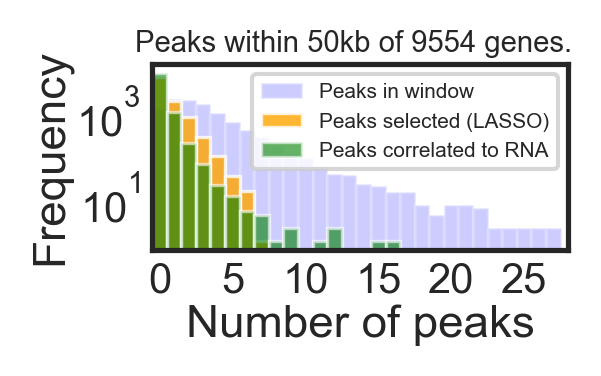

In [235]:
sns.set_style("white")

fig, ax = plt.subplots(1,1,figsize=(2,1.25), dpi=300)
setfontsize()

plt.hist(gp_all_links['num_near_peaks'], bins=np.arange(0-0.5,30-0.5,1), color='blue', alpha=0.2, 
         linewidth=0.8, edgecolor='white', label='Peaks in window')

plt.hist(gp_all_links['num_selected_peaks'], bins=np.arange(0-0.5,30-0.5,1), color='orange', alpha=0.8,
        linewidth=0.8, edgecolor='white', label='Peaks selected (LASSO)')

plt.hist(num_corr_peaks, bins=np.arange(0-0.5,30-0.5,1), color='green', alpha=0.6,
        linewidth=0.8, edgecolor='white', label='Peaks correlated to RNA')

ax.legend()
plt.xlim(-0.5,28)
ax.set_xlabel('Number of peaks')
ax.set_ylabel('Frequency')
plt.suptitle('Peaks within 50kb of {} genes.'.format(len(gp_all_links)),y=1.02)
plt.yscale('log')

ax.tick_params(axis='both', which='major', pad=-3)
ax.yaxis.labelpad = 1
ax.xaxis.labelpad = 1

set_size(fig, (2, 1.25))

plt.savefig("Figure4_panels/Peaksnear_Histogram_50.pdf", bbox_inches='tight')

plt.show()

(Based on https://science.sciencemag.org/content/sci/361/6409/1380.full.pdf, p.4)

Begin with 617 genes, with clonal significance p<0.01 in gene expression from P9855.  (Around 80 expected by chance.)
Among these, 545 have peaks within the window around the gene (length of gene, + 50000 bp upstream).
These peaks have between 1 and 27 peaks within the window (median 3 peaks, 75th percentile 5 peaks).

Among the 545 genes, 48 exhibit a correlation just with promoter peak(s) (adjusted $R^2 > 0.2$).  But 159 exhibit a correlation with selected peaks within the window (adjusted $R^2 > 0.2$, LASSO model fit with AIC for model selection).

In [238]:
gp_sig_links[gp_sig_links.num_near_peaks > 0.0].describe()

num_near_peaks  num_selected_peaks  num_promoters
count      545.000000          545.000000     545.000000
mean         4.244037            0.970642       0.522936
std          3.656316            1.197063       0.644495
min          1.000000            0.000000       0.000000
25%          2.000000            0.000000       0.000000
50%          3.000000            1.000000       0.000000
75%          5.000000            2.000000       1.000000
max         27.000000            6.000000       3.000000

In [241]:
gp_sig_links = gp_all_links.reindex(genes_sig_9855)
gp_sig_links
print('We are looking at {} genes.'.format(len(genes_sig_9855)))
print('Among these, {} have peaks within the window.'.format(len(gp_sig_links[gp_sig_links.num_near_peaks > 0.0])))
print('Among these, the number of nearby peaks is below.')
print(gp_sig_links.num_near_peaks.value_counts().sort_index())
print('Among these, the number of selected peaks is below.')
print(gp_sig_links.num_selected_peaks.value_counts())
print('Among the significant genes, {} exhibit R^2 > 0.2 with the selected genes.'
      'And {} with just the promoter.'.format((gp_sig_links.Rsq > 0.2).sum(), (gp_sig_links.promoter_Rsq > 0.2).sum()))

We are looking at 617 genes.
Among these, 545 have peaks within the window.
Among these, the number of nearby peaks is below.
0.0      67
1.0      96
2.0     102
3.0      99
4.0      63
5.0      65
6.0      25
7.0      31
8.0      13
9.0      11
10.0     11
11.0      3
12.0      3
13.0      7
14.0      3
15.0      1
16.0      2
17.0      2
18.0      1
20.0      2
21.0      1
22.0      2
26.0      1
27.0      1
Name: num_near_peaks, dtype: int64
Among these, the number of selected peaks is below.
0.0    321
1.0    150
2.0     79
3.0     37
4.0     17
5.0      6
6.0      2
Name: num_selected_peaks, dtype: int64
Among the significant genes, 159 exhibit R^2 > 0.2 with the selected genes.And 48 with just the promoter.


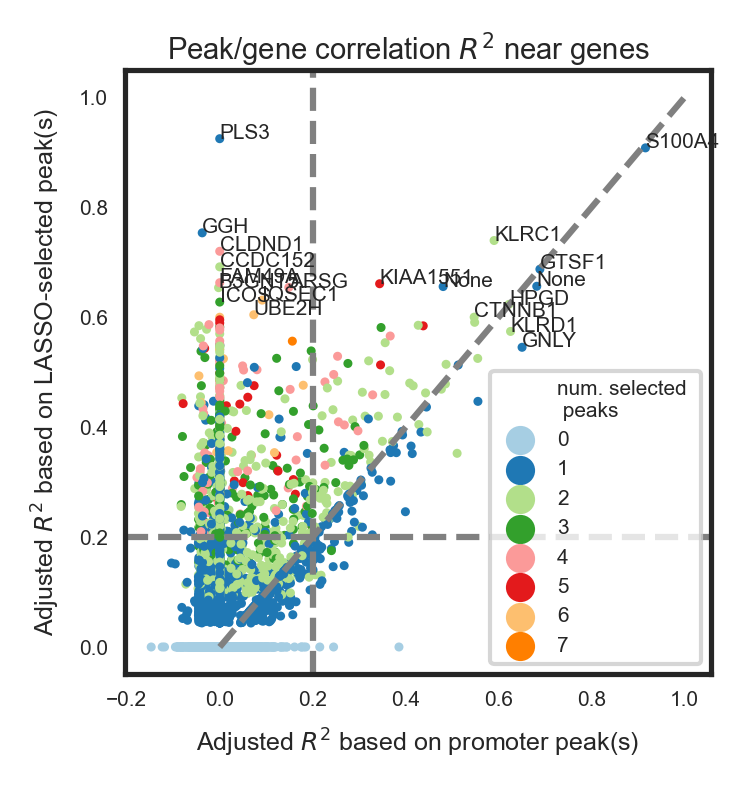

In [243]:
sns.set_style("white")

fig, ax = plt.subplots(1,1,figsize=(2.5,2.5), dpi=300)
setfontsize()

sns.scatterplot(x='promoter_Rsq', y='Rsq', data=gp_all_links, hue='num_selected_peaks', palette='Paired', 
                edgecolor=None, s=2.0)

gp_ann_links = gp_all_links[(gp_all_links['promoter_Rsq'] > 0.6) | (gp_all_links['Rsq'] > 0.6)]

for gene in gp_ann_links.index:
    gal = gp_ann_links.loc[gene]
    ax.text(gal['promoter_Rsq'], gal['Rsq'], gal['name'])

#nonsiggenes = [gene for gene in gp_all_links.index if gene not in gp_sig_links.index]
#sns.scatterplot(x='promoter_Rsq', y='Rsq', data=gp_all_links.loc[nonsiggenes] , color='black', 
#                edgecolor=None, alpha=0.9, s=0.5) #.sample(len(gp_sig_links))


ax.axhline(0.2, color='gray', linestyle='--')
ax.axvline(0.2, color='gray', linestyle='--')
ax.plot([0, 1], [0, 1], color='gray', linestyle='--')

ax.set_xlabel('Adjusted $R^2$ based on promoter peak(s)')
ax.set_ylabel('Adjusted $R^2$ based on LASSO-selected peak(s)')


leg = ax.get_legend()
leg.set_title('')
# replace labels
new_labels = ['num. selected \n peaks', '0', '1','2','3','4','5']
for t, l in zip(leg.texts, new_labels): 
    t.set_text(l)

#leg.set_bbox_to_anchor((0,1,0.5,0))

ax.tick_params(axis='both', which='major', pad=-2)

set_size(fig, (2.5, 2.5))
plt.suptitle('Peak/gene correlation $R^2$ near genes', y=0.93) # \n From promoters and selected nearby peaks', y=1.0)

plt.savefig("Figure4_panels/Peakvar_near_Geneclonal.pdf", bbox_inches='tight')

plt.show()

# Visualizing peak/gene/protein correlations

Here we visualization gene expression for a single gene, and peak heights and (possibly) a protein expression.

In [245]:
def quickvis_gp(gn, peaklist, protein = '', window=50000, figsize = (2,1.25), dpi=300, trans=False):
    '''
    Visualizes gene expression and nearby peak heights
    '''

    sns.set_style("white")
    plt.rcParams['xtick.bottom'] = True
    plt.rcParams['xtick.major.width'] = 0.5
    if protein == '':
        fig, ax = plt.subplots(3,1,figsize=figsize, dpi=dpi, sharex=False,
                               gridspec_kw={'height_ratios': [3,1,1], 'hspace':0.0})
    else:
        fig, ax = plt.subplots(4,1,figsize=(2,1.5), dpi=dpi, sharex=False,
                               gridspec_kw={'height_ratios': [3,1,1,1], 'hspace':0.0})
    setfontsize()
    
    # Get ENSGs, gene-names, etc.
    if gn[:4] == 'ENSG':
        ENSG = gn
    else:
        ENSGs = get_ensg(gn, multiple='all')
        if type(ENSGs) == str:
            ENSG = ENSGs
        else:
            ENSGs = [en for en in ENSGs if en in EM.columns]
            if len(ENSGs) == 1:
                ENSG = ENSGs[0]
            else:
                print('Multiple ENSG possible.  Please choose one from {}'.format(', '.join(ENSGs)))
                return None
    gene = gene_names[ENSG]
    
    # Make RNA dataframe
    RNA_df = pd.DataFrame(index = EM_3.index)
    RNA = EM_3[ENSG]
    RNA_df[gene] = RNA
    RNA_df['Clone'] = meta_df.Clone_ID
    
    RNA_clonemeans = RNA_df.groupby('Clone').mean().sort_values(gene)
    cl_order = {clone:j for j,clone in enumerate(RNA_clonemeans.index)}
    RNA_df['num'] = RNA_df['Clone'].map(cl_order)
    RNA_mean = RNA.mean()
    RNA_meannz = RNA[RNA != 0].mean()
    RNA_min = RNA.min()
    RNA_max = RNA.max()
    plt.xlim(-1,len(RNA_clonemeans)+1)
    
    # Plot gene expression
    ax[0].axhline(RNA_meannz, color=(0,0,0), linewidth=0.5, linestyle='-', zorder=-1)
    ax[0].axhline(RNA_min, color=(1,0,0), linewidth=0.5, linestyle='-', zorder=-1)
    ax[0].axhline(RNA_max, color=(0,1,0), linewidth=0.5, linestyle='-', zorder=-1)
    
    for n in RNA_df.num:
        ax[0].axvline(n, color='gray', linewidth=0.5, linestyle=':', zorder=-1)
    
    #sns.boxplot(y=gene, x='num', color=(0.9,0.9,0.9,1), linewidth=0.5, data = RNA_df, 
    #            ax=ax[0], orient='v')

    sns.scatterplot(y=gene, x='num', hue='num', palette='Dark2', edgecolor=None, linewidth=0, alpha=0.9,
                    data = RNA_df, ax=ax[0], s=15.0, zorder=2)

    ax[0].legend_.remove()
    if RNA_min == 0:
        ax[0].set_yticks([0, RNA_max])
        ax[0].set_yticklabels(['0', '{:0.1f}'.format(RNA_max)])
    else:
        ax[0].set_yticks([RNA_min, RNA_mean, RNA_max])
        ax[0].set_yticklabels(['{:.1f}'.format(ge) for ge in [RNA_min, RNA_mean, RNA_max]])
    ax[0].set_ylabel('$\log_2(TPM)$')
    ax[0].tick_params(axis='y', which='major', pad=-2)
    ax[0].yaxis.set_label_position("right")
    ax[0].set_xticks([])
    #ax[0].set_xticks(hue_order)
    
    peakmetas = peak_meta.loc[peaklist]
    xmin = peakmetas['start'].min()
    xmax = peakmetas['end'].max()
    
    if protein == '':
        ax_gene = ax[2] # Put gene track on axis 2.
    else: # Make protein graph
        ax_gene = ax[3] # Put gene track on axis 3
        
        Pr_df = pd.DataFrame(index=P_clonal.index)
        Pr_df[protein] = P_clonal[protein]
        Pr_min = Pr_df[protein].min()
        Pr_max = Pr_df[protein].max()
        Pr_df = (Pr_df - Pr_min) / (Pr_max - Pr_min) 
        Pr_df['num'] = Pr_df.index.map(cl_order)
        sns.lineplot(y=protein, x='num', data=Pr_df, ax=ax[2], linewidth=0.5)
        
        ax[2].set_xticks([])
        ax[2].set_yticks([])
        ax[2].set_ylim(0,1.1)
        ax[2].tick_params(axis='y', which='major', pad=-2)
        ax[2].text(1,0.4,protein)
        ax[2].set_ylabel('Prot')
        ax[2].yaxis.set_label_position("right")
        for n in RNA_df.num:
            ax[2].axvline(n, color='gray', linewidth=0.5, linestyle=':', zorder=-1)
        
    # Axis 2 = gene track.
    geneloc = gene_locs.loc[ENSG]
    generect = Rectangle((geneloc['start'],0),geneloc['end'] - geneloc['start'],1,
                         linewidth=0,edgecolor=None,facecolor=(0.8,0.8,0.8,1), 
                        zorder=-2) # Rectangle for gene location.
    
    if geneloc['end'] - geneloc['start'] > 0.3*window: # Enough space for gene label?
        ax_gene.text(0.5*(geneloc['start']+geneloc['end']),0.95,gene, ha='center', va='top', color='black')
    
    ax_gene.set_xticks([geneloc['TSS'] - window, geneloc['TSS'], geneloc['TSS']+window])
    winkb = window // 1000
    ax_gene.set_xticklabels(['-{}Kb'.format(winkb), 'TSS', '+{}Kb'.format(winkb)])
    ax_gene.add_patch(generect)
    
    xmin=geneloc['TSS'] - window*1.1
    xmax=max(geneloc['TSS'] + window*1.1, geneloc['end']+window*0.1)
    ax_gene.set_xlim(xmin,xmax)
    ax_gene.set_ylim(0,1)
    ax_gene.axhline(0.25, linewidth=0.5, color='gray', linestyle='--', zorder=-1)
    ax_gene.axhline(0.5, linewidth=0.5, color='black', linestyle='--', zorder=-1)
    ax_gene.axhline(0.75, linewidth=0.5, color='green', linestyle='--', zorder=-1)
    #ax_gene.axvline(geneloc['TSS']-window, linewidth=0.5, color='k', linestyle='-', zorder=-1)
    #ax_gene.axvline(geneloc['TSS']+window, linewidth=0.5, color='k', linestyle='-', zorder=-1)
    #ax_gene.axvline(geneloc['TSS'], linewidth=0.5, color='red', linestyle='-', zorder=-1)
    
    
    
    
    #Make Peak dataframe
    j = 0
    for peak in peaklist:
        j += 1 # Start at ax[1]
        P_df = pd.DataFrame(index=AM.index)
        peakno = peak.split('_')[1]
        P_df[peakno] = AM[peak]
        P_min = P_df[peakno].min()
        P_max = P_df[peakno].max()
        P_df = (P_df - P_min) / (P_max - P_min)
        P_df['Clone'] = meta_df.Clone_ID  
        P_df = P_df.groupby('Clone').mean()
        P_df['num'] = P_df.index.map(cl_order)
       
        data = pd.DataFrame(index=EM_clonal.index)
        data['x'] = EM_clonal[ENSG]
        data['y'] = AM_clonal[peak]
        goodxindex = data['x'].dropna().index
        goodyindex = data['y'].dropna().index
        goodindex = [i for i in goodxindex if i in goodyindex]
        data = data.loc[goodindex]
        Rsq = r2(data['x'], data['y'])
        
        if trans:
            alpha = min(2*Rsq, 1.0)
        else:
            alpha = 1.0
        sns.lineplot(y=peakno, x='num', data=P_df, ax=ax[1], linewidth=0.5, 
                     alpha=alpha)
        lcol = ax[1].get_lines()[-1].get_c()
        
        # Axis 2 = peak R^2 values with gene expression
        pm = peakmetas.loc[peak]
        left = pm['start']
        bottom = 0
        top = 0.1
        width = pm['end'] - left
        #ax_peak.text(left-width, 0.1, peak.split('_')[1], rotation=-90)
        ax_gene.set_ylim(0,1)
        ax_gene.set_yticklabels([])
        
        rect = Rectangle((left,bottom),width,Rsq,linewidth=1,edgecolor=lcol,facecolor=lcol)
        ax_gene.add_patch(rect)
        
        
    
    ax[1].set_yticks([])
    ax[1].set_ylim(0,1.1)
    #ax[1].set_yticklabels(['min','max'])
    ax[1].tick_params(axis='y', which='major', pad=-2)
    ax[1].set_ylabel('Ht')
    ax[1].yaxis.set_label_position("right")
    for n in RNA_df.num:
        ax[1].axvline(n, color='gray', linewidth=0.5, linestyle=':', zorder=-1)
    
    ax_gene.set_ylabel('$R^2$')
    ax_gene.yaxis.set_label_position("right")
    ax_gene.set_yticks([0.5])
    ax_gene.set_yticklabels(['0.5'])
    
    ax[1].set_xlabel('')
    ax_gene.tick_params(axis='y', which='major', pad=-2)
    ax_gene.tick_params(axis='x', which='major', pad=0)
    ax_gene.tick_params(axis='x', which='major', color='k', length=2)
    
    set_size(fig, figsize)
    if protein == '':
        plt.suptitle('{} and {} peak heights'.format(gene, len(peaklist)), y=0.99)
    else:
        plt.suptitle('{}, {} peak heights, and {}'.format(gene, len(peaklist), protein), y=0.99)

    plt.savefig("Figure4_panels/{}_with_peaks_mini.pdf".format(gene, bbox_inches='tight'))
    plt.show()

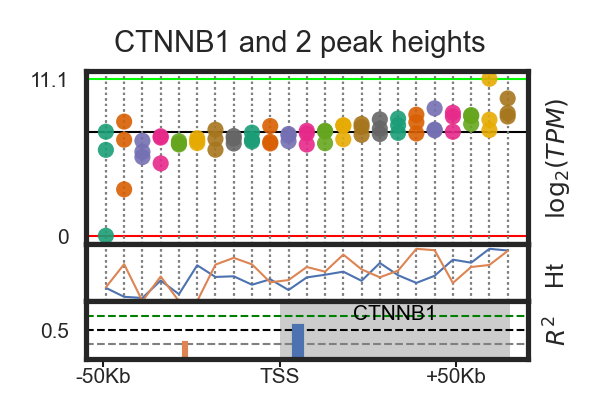

In [247]:
def quick_vis(gene, protein='', window=50000, trans=False):
    peaklist = peaks_near(gene, window=window)
    pcw = peak_corr_with(gene)
    peaklist = [peak for peak in peaklist if peak in pcw.index]
    peaklist = [peak for peak in peaklist if peak_corr_with(gene).loc[peak]**2 > 0.2]
    quickvis_gp(gene,peaklist, protein=protein, window=window, trans=trans)

quick_vis('CTNNB1')

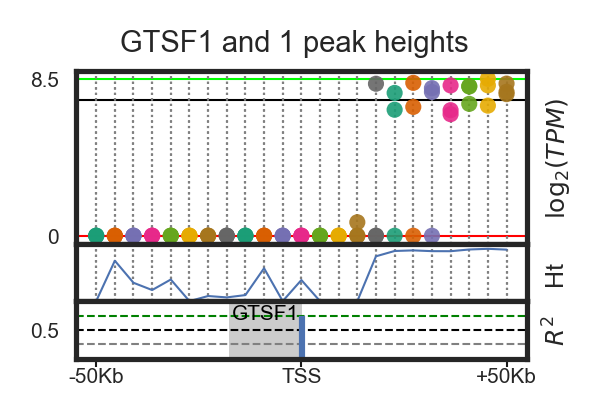

In [248]:
quick_vis('GTSF1')

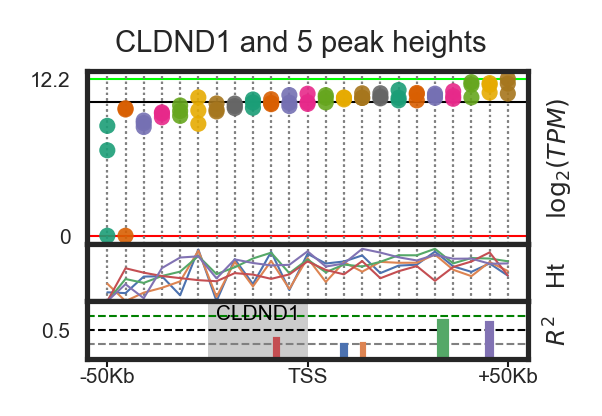

In [249]:
quick_vis('CLDND1')

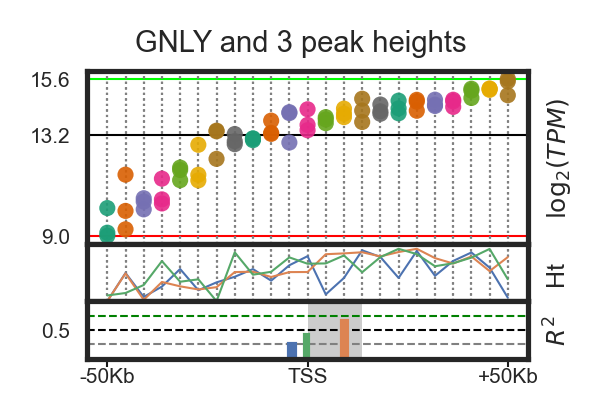

In [250]:
quick_vis('GNLY')

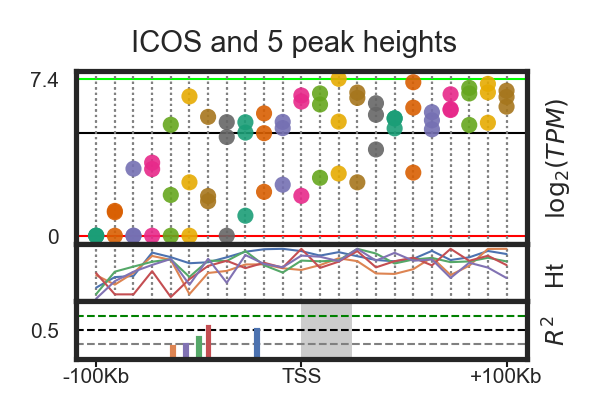

In [251]:
quick_vis('ICOS', window=100000)

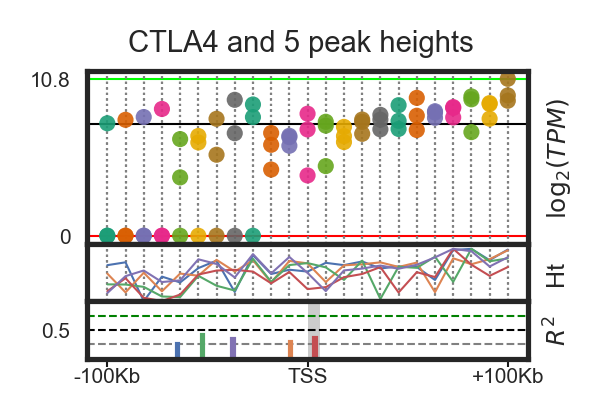

In [252]:
quick_vis('CTLA4', window=100000)

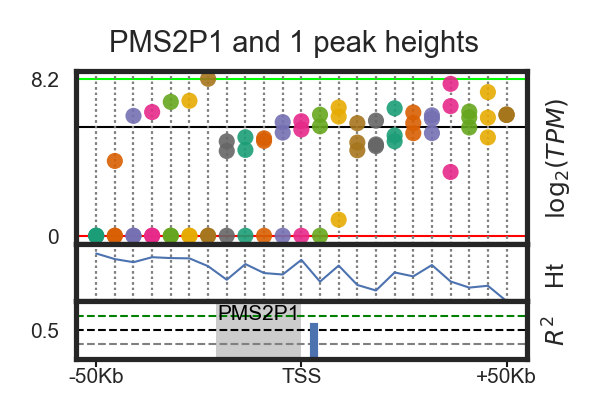

In [253]:
quick_vis('PMS2P1')

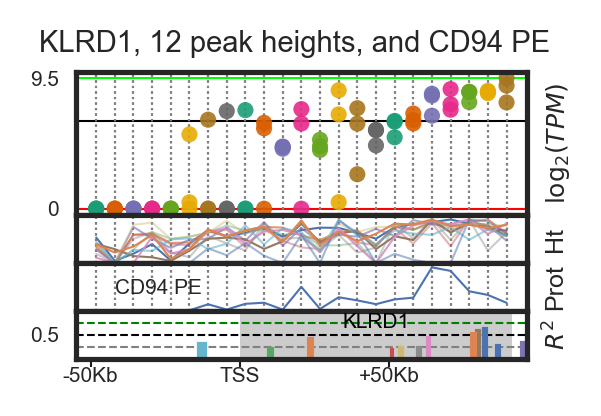

In [254]:
quick_vis('KLRD1', protein='CD94 PE', trans=True)

In [255]:
get_ensg('PLS3', multiple='all')

['ENSG00000102024', 'ENSG00000268767']

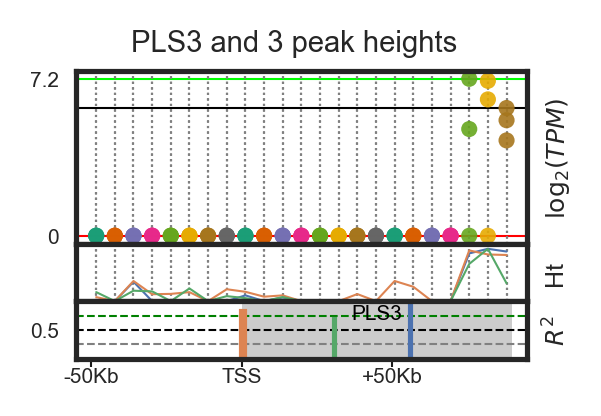

In [256]:
quick_vis('ENSG00000102024')

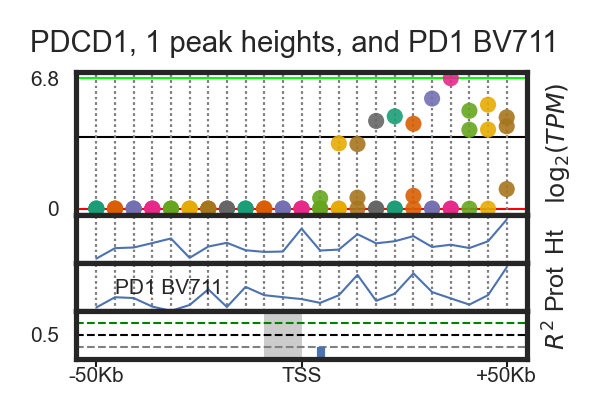

In [257]:
quick_vis('PDCD1', protein='PD1 BV711')

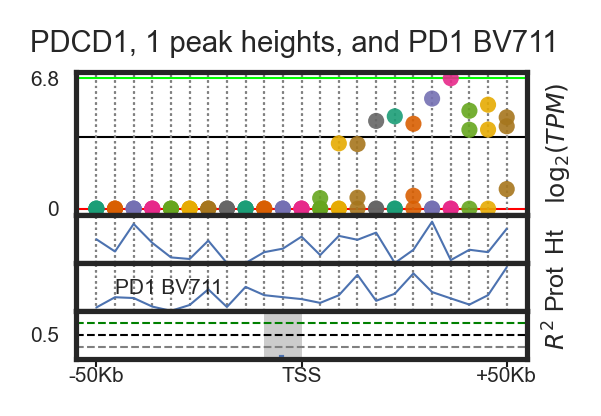

In [258]:
quickvis_gp('PDCD1',['Interval_43302'], 
            protein='PD1 BV711')

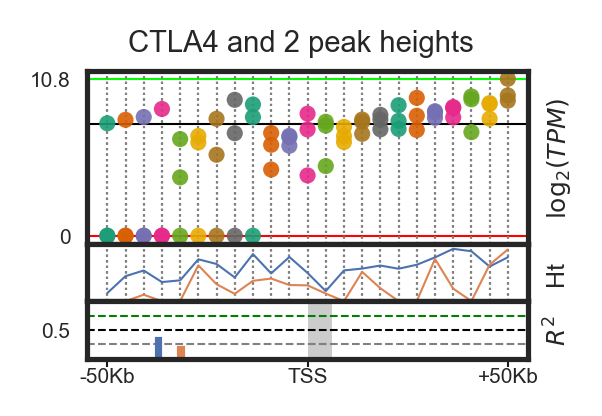

In [259]:
quickvis_gp('CTLA4',['Interval_42077', 'Interval_42078'])

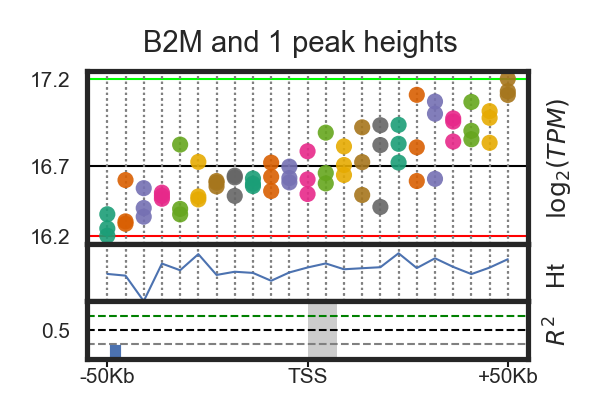

In [260]:
quick_vis('B2M', window=50000)

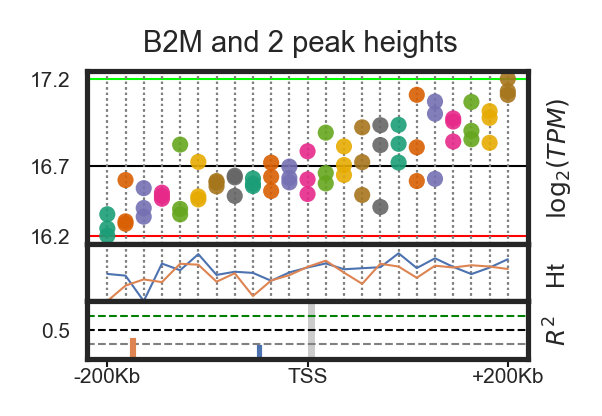

In [261]:
quick_vis('B2M', window=200000)

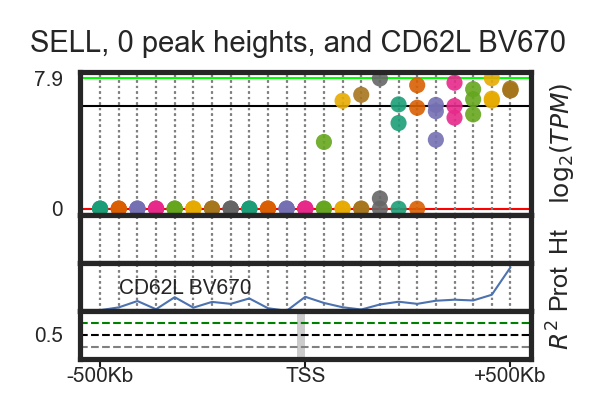

In [262]:
quick_vis('SELL', protein='CD62L BV670', window=500000)

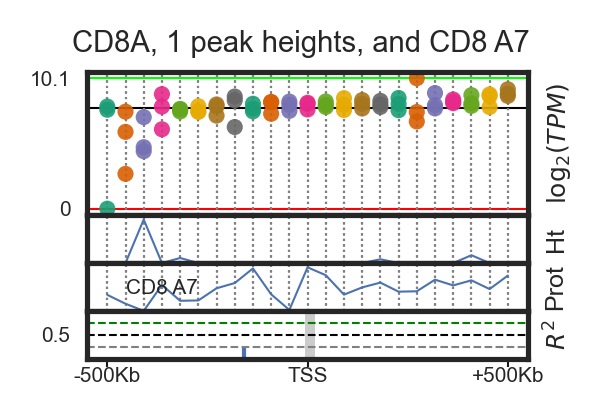

In [263]:
quick_vis('CD8A', protein='CD8 A7', window=500000)

# Quick search for strong negative correlations

In [264]:
neg_corrs = []
for j,gene in enumerate(EM.columns):
    if j%500 == 0:
        print('Looking for negative correlations.  {} genes processed.'.format(j))
    pn = peaks_near(gene)
    if len(pn) > 0:
        pcw = peak_corr_with(gene)[peaks_near(gene)]
        pcw = pcw[pcw < -0.633] # Negative, with R^2 > 0.4
        if len(pcw) > 0:
            neg_corrs = neg_corrs + ([[gene, peak] for peak in pcw.index])
            print('Found one!')

Looking for negative correlations.  0 genes processed.
Found one!
Found one!
Found one!
Found one!
Found one!
Looking for negative correlations.  500 genes processed.
Found one!
Found one!
Found one!
Found one!
Looking for negative correlations.  1000 genes processed.
Found one!
Found one!
Found one!
Looking for negative correlations.  1500 genes processed.
Found one!
Found one!
Looking for negative correlations.  2000 genes processed.
Looking for negative correlations.  2500 genes processed.
Found one!
Found one!
Looking for negative correlations.  3000 genes processed.
Found one!
Found one!
Looking for negative correlations.  3500 genes processed.
Found one!
Found one!
Found one!
Looking for negative correlations.  4000 genes processed.
Found one!
Found one!
Looking for negative correlations.  4500 genes processed.
Found one!
Found one!
Found one!
Looking for negative correlations.  5000 genes processed.
Found one!
Found one!
Found one!
Looking for negative correlations.  5500 genes 

In [267]:
print('{} negative correlations found with R^2 > 0.4'.format(len(neg_corrs)) )

43 negative correlations found with R^2 > 0.4


We filter these further, to avoid very low peak heights and very low expressions.

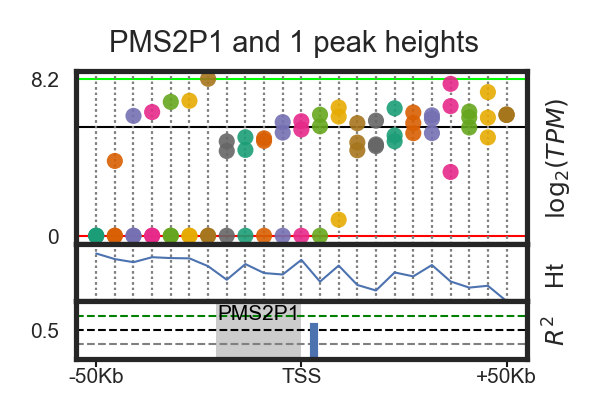

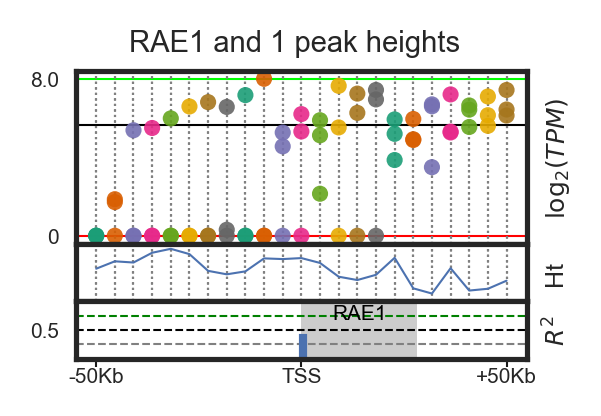

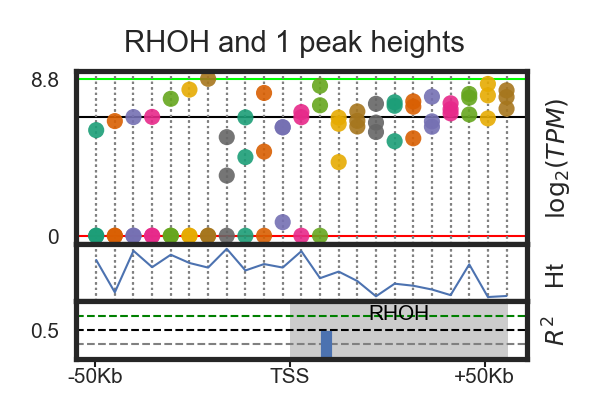

In [266]:
for gp in neg_corrs:
    gene = gp[0]
    peak = gp[1]
    if (EM[gene].mean() > log2p(10)) and (AM[peak].mean() > log2p(5)):
        quickvis_gp(gene,[peak])

# Old exploratory visualization

In [270]:
def pg_analyze(gn):
    desetfontsize()
    if gn[:4] == 'ENSG':
        gene = gn
    else:
        gene = get_ensg(gn)
    peaklist = peaks_near(gene)
    peakcorrs = peak_corr_with(gn)[peaklist]**2
    peakmetas = peak_meta.loc[peaklist]
    xmin = peakmetas['start'].min()
    xmax = peakmetas['end'].max()
    gs_kw = dict(width_ratios=[1], height_ratios=[1,0.5,0.2], hspace=0.05)
    sns.set_style("whitegrid")
    fig,ax = plt.subplots(3,1, figsize=(12,5), gridspec_kw=gs_kw, sharex=True)
    
    ax_gene = ax[2]
    ax_peak = ax[2]
    ax_heights = ax[1]
    ax_R2 = ax[0]
    
    # Axis 0 = gene bar.
    geneloc = gene_locs.loc[gene]
    generect = Rectangle((geneloc['start'],0),geneloc['end'] - geneloc['start'],1,
                         linewidth=0,edgecolor=None,facecolor=(0.8,0.8,0.8,1)) # Rectangle for gene location.
    
    ax_gene.set_xticks([geneloc['TSS'] - 50000, geneloc['TSS'], geneloc['TSS']+50000])
    ax_gene.set_xticklabels(['TSS - 50Kb', 'TSS', 'TSS + 50Kb'])
    ax_gene.add_patch(generect)
    xmin=geneloc['TSS'] - 50000
    ax_gene.set_xlim(xmin,xmax)
    ax_gene.set_ylim(0,1)
    
    ax_peak.set_xlim(xmin,xmax)
    
    ax_R2.set_xlim(xmin,xmax)
        
    for peak in peaklist:
        
        # Peak bars.
        pm = peakmetas.loc[peak]
        left = pm['start']
        bottom = 0
        width = pm['end'] - left
        top = 1
        if pm.itype == 'promoter-TSS':
            rcolor = (0,1,0,0.5)
        else:
            rcolor = (0,0,1,0.2)
        rect = Rectangle((left,bottom),width,top,linewidth=0,edgecolor=None,facecolor=rcolor)
        ax_peak.text(left-width, 0.1, peak.split('_')[1], rotation=-90)
        ax_peak.add_patch(rect)
        ax_peak.set_ylim(0,1)
        ax_peak.set_yticklabels([])
        
        # Axis 1 = peak heights
        height = np.log1p(ATAC_df.loc[peak].max())
        rect = Rectangle((left,bottom),width,height,linewidth=0,edgecolor=None,facecolor='red')
        ax_heights.add_patch(rect)
        
        
        # Axis 2 = peak R^2 values with gene expression
        height = peakcorrs[peak]
        rect = Rectangle((left,bottom),width,height,linewidth=0,edgecolor=None,facecolor='blue')
        ax_R2.add_patch(rect)
        
    
    ax_heights.set_ylabel('Max height')
    ymax = np.log1p(ATAC_df.loc[peaklist].values.flatten().max())
    ax_heights.set_ylim(0,1.2*ymax)
    
    rect = Rectangle((xmin,0),xmax - xmin,np.log1p(15),linewidth=0,edgecolor=None,facecolor=(0.5,0.5,0.5,0.7))
    ax_heights.add_patch(rect)
    ax_heights.set_yticks(range(0,))
    
    
    ax_R2.set_ylim(0,1)
    ax_R2.set_ylabel('$R^2$ with {}'.format(gn))
    
    plt.suptitle('Correlation between peak heights near and expression of {}'.format(gn))
    plt.show()
    

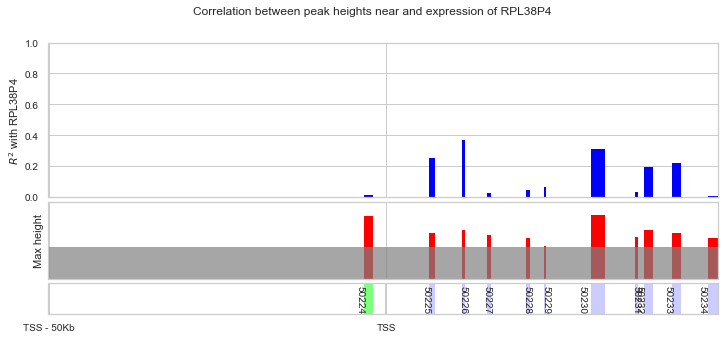

In [271]:
pg_analyze('RPL38P4')

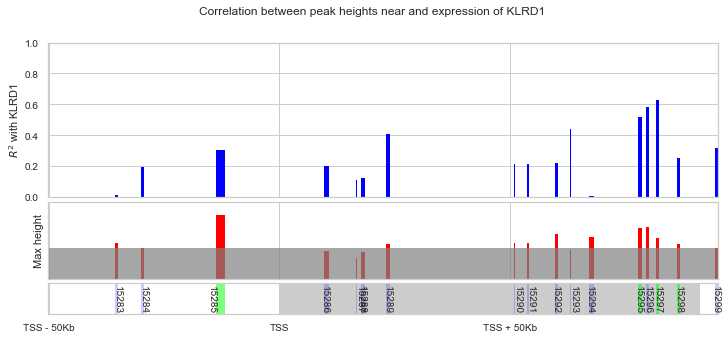

In [272]:
pg_analyze('KLRD1')

# Heatmaps

This is where we make the heatmaps for ATAC peaks.  This could really come much sooner.

In [274]:
cutoff = 0.0001
sig_peaks = ATAC_p[ATAC_p < cutoff].index
print('{} significant peaks used in heatmap.  {} expected by chance.'.format(len(sig_peaks), cutoff*len(ATAC_p)))

869 significant peaks used in heatmap.  8.0599 expected by chance.


In [275]:
peak_meta.loc[sig_peaks].itype.value_counts()

intron          328
promoter-TSS    249
Intergen        187
TTS              53
exon             52
Name: itype, dtype: int64

For the heatmap, we order the peaks in such a way that the heatmap looks blocky along the diagonal.

In [276]:
def blockord(df, row_list, keepkeys = False):
    colkey = {col : j for j,col in enumerate(df.columns)}
    keycol = {j:col for j,col in enumerate(df.columns)}
    if keepkeys:
        block_df = df.loc[row_list].idxmax(axis=1).map(colkey).sort_values()
        return block_df.map(keycol)
    return df.loc[row_list].idxmax(axis=1).map(colkey).sort_values().index

peak_blocks = blockord(ATAC_df, sig_peaks, keepkeys=True)
peak_blocks.head()

data_block = ATAC_df.reindex(blockord(ATAC_df, sig_peaks))
#data_block = np.log1p(data_block)
data_block.head()

clone1_R1  clone1_R2  clone10_R1  clone11_R1  clone13_R1  \
PeakID                                                                      
Interval_41146  107.724509  98.795887   97.390313   24.210865   27.725908   
Interval_31923   98.595313  90.916460   24.347578   10.760385   30.036401   
Interval_42714   94.030715  82.430924    0.000000   16.140577    0.000000   
Interval_665     98.595313  75.157607   39.841492   67.252404   53.141324   
Interval_72825   91.291956  81.218704   84.109816   24.210865   55.451817   

                clone14_R1  clone15_R1  clone15_R2  clone16_R1  clone17_R1  \
PeakID                                                                       
Interval_41146   86.958901   76.115221   75.999557   54.504125  106.246402   
Interval_31923   92.176435   73.961017   86.081131   75.178103   46.147427   
Interval_42714   38.261916   43.802156   26.367193    0.000000   55.806191   
Interval_665     67.827943    5.744545    4.653034   77.997282   75.123719   
Interval_72825   59.132053   36.621474   34.897756   78.937008   32.195880   

                ...  clone24_R1   clone3_R1  clone4_R1  clone5a_R1  \
PeakID          ...                                                  
Interval_41146  ...   99.022888  107.313068  62.762271   87.959722   
Interval_31923  ...   88.259530   51.592821  84.280764   64.040850   
Interval_42714  ...   47.358772   41.274257  46.623402   16.974683   
Interval_665    ...   19.374043   47.465396  19.725285   52.467203   
Interval_72825  ...   88.259530   47.465396  48.416609   68.670309   

                clone5b_R1  clone7_R1  clone8_R1  clone8_R2  clone9_R1  \
PeakID                                                                   
Interval_41146   93.460408  94.378101  59.231882  73.188294  29.574116   
Interval_31923   52.227875  52.355735  36.723767  47.007116  63.996448   
Interval_42714    1.374418   0.000000   0.000000   0.000000   8.241967   
Interval_665     54.976711  79.222494  47.385506  51.767330  29.574116   
Interval_72825   89.337155  77.844711  59.824201  61.287758  26.180365   

                clone9_R2  
PeakID                     
Interval_41146  24.687169  
Interval_31923  69.535527  
Interval_42714   6.994698  
Interval_665    28.390245  
Interval_72825  34.562037  

[5 rows x 29 columns]

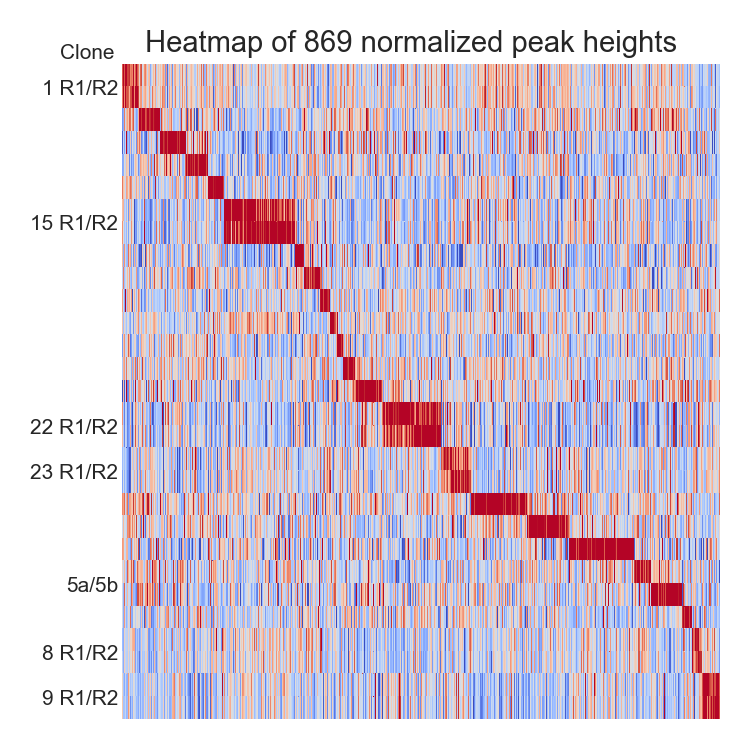

In [278]:
sns.set_style("white")

fig, ax = plt.subplots(figsize=(2.5,2.5), dpi=300)
setfontsize()

sns.heatmap(data_block.T.apply(zscore), cmap='coolwarm', vmin=-2, vmax=2, ax=ax,
           xticklabels=False, cbar=False)

#sns.heatmap(data_block.T / data_block.T.max(), ax=ax, xticklabels=False, cbar=False, cmap = 'magma')


ytl = data_block.columns  #ax.get_yticklabels()
jlist = []
llist = []
for j,yt in enumerate(ytl):
    yt_text = yt #.get_text()
    if yt_text[-1] == '2':
        jlist.append(j)
        cn = yt_text.split('_')[0][5:] # Clone number
        #ax.text(-2, j+0.5, 'Clone '+cn+' R1/R2')
        llist.append(cn+' R1/R2')
    if yt_text == 'clone5b_R1':
        jlist.append(j)
        #ax.text(-2, j+0.5, 'Clones 5a/5b')
        llist.append('5a/5b')

ax.set_yticks(jlist)
ax.set_yticklabels(llist)
ax.set_ylabel('')
ax.set_xlabel('')

ticklabelpad = plt.rcParams['ytick.major.pad']
ax.annotate('Clone', xy=(0,1), xytext=(-15, 5), ha='left', va='top',
            xycoords='axes fraction', textcoords='offset points')

ax.tick_params(axis='both', which='major', pad=-5)

plt.suptitle('Heatmap of {} normalized peak heights'.format(len(data_block)), y=0.92)
set_size(fig, (2.5, 2.5))

plt.savefig("Figure4_panels/Heatmap_peaks.pdf", bbox_inches='tight')

plt.show()

# Old TF-related stuff below.

In [ ]:
TF_list = interval_df.columns[35:]
TF_df = interval_df[TF_list]
TF_df.head()

In [ ]:
TF_ratios = TF_df.sum() / len(TF_df)
TF_ratios.head()

In [ ]:
def check_enriched(peaklist, adjusted=True):
    num_TFs = TF_df.loc[peaklist].sum()
    n = len(peaklist)
    p = 1 - ss.binom.cdf(num_TFs-1, n, TF_ratios)
    adj = len(TF_ratios)
    if adjusted:
        p = (p * len(TF_ratios)).clip(0,1)
    return pd.Series(p, index=TF_ratios.index)

In [ ]:
def motif_name(mid):
    mn = mid.split('_')[1]
    mn_list = mn.split('::')
    mn_list = [m.split('(')[0] for m in mn_list]
    return mn_list

TF_llist = [motif_name(m) for m in block_enriched.columns]
TF_list = []
for TF_l in TF_llist:
    TF_list += TF_l
TF_list = list(set(TF_list))

In [ ]:
block_enriched = pd.DataFrame(index=ATAC_df.columns, columns=TF_df.columns)
Asig_df = ATAC_df.loc[sig_peaks]
Aquants = Asig_df.quantile(0.8, axis=1)
for clone in block_enriched.index:
    peakhigh = Asig_df[clone] > Aquants
    peaklist = peakhigh[peakhigh].index
    block_enriched.loc[clone] = -np.log10(check_enriched(peaklist))
block_enriched.head()

In [ ]:
be_df = pd.DataFrame(0, index=block_enriched.index, columns=sorted(TF_list))

for block in block_enriched.index:
    be = block_enriched.loc[block]
    for MA in be.index:
        motifs = motif_name(MA)
        for motif in motifs:
            be_df.loc[block, motif] = max(be_df.loc[block,motif], be[MA])
            
be_TFs = (be_df.sum() > 0)
be_TFs = be_TFs[be_TFs]
be_df = be_df[be_TFs.index] # Filter out TFs with all False
be_df.head()

In [ ]:
TF_expr = pd.Series(index=TF_list)
for TF in TF_list:
    genelist = gene_names[gene_names == TF].index
    genelist = [gene for gene in genelist if gene in EM_clonal.columns]
    if len(genelist) > 0:
        TF_expr[TF] = EM_clonal[genelist].values.flatten().max()
TF_expr = TF_expr.dropna()

In [ ]:
TF_expressed = TF_expr[TF_expr > np.log1p(20)].index
TF_expressed = [TF for TF in TF_expressed if TF in be_df.columns]
be_df = be_df[TF_expressed]

In [ ]:
TF_ord = blockord(be_df.T, be_df.T.index)

In [ ]:
sns.set_style("white")

fig, ax = plt.subplots(1,2,figsize=(6,3), 
                       gridspec_kw={'width_ratios':[3,7]}, 
                       sharey=True, dpi=300)
setfontsize()

sns.heatmap(data_block.T.apply(zscore), cmap='coolwarm', vmin=-2, vmax=2, ax=ax[0],
           xticklabels=False, cbar=False)

sns.heatmap(be_df[TF_ord], ax=ax[1], cbar=False, vmin=0, vmax=10)

ytl = ax[0].get_yticklabels()
jlist = []
llist = []
for j,yt in enumerate(ytl):
    yt_text = yt.get_text()
    if yt_text[-1] == '2':
        jlist.append(j)
        cn = yt_text.split('_')[0][5:] # Clone number
        #ax.text(-2, j+0.5, 'Clone '+cn+' R1/R2')
        llist.append('Cl.'+cn+' R1/R2')
    if yt_text == 'clone5b_R1':
        jlist.append(j)
        #ax.text(-2, j+0.5, 'Clones 5a/5b')
        llist.append('Cl.5a/5b')

ax[0].set_yticks(jlist)
ax[0].set_yticklabels(llist)

ax[0].set_xlabel('')

ax[0].tick_params(axis='both', which='major', pad=-5)
ax[1].tick_params(axis='both', which='major', pad=-5)

fig.subplots_adjust(wspace=0, hspace=0)

plt.suptitle('Clustered heatmap from {} peaks and {} associated TFs.'.format(len(data_block), len(be_df.T)), y=0.95)
set_size(fig, (4.5, 3.0))

plt.savefig("Figure4_panels/Heatmap_peaks.pdf", bbox_inches='tight')

plt.show()